# Телеком. Оптимизация тарифов клиентов

**МАТЕРИАЛЫ**<br>
[Презентация](https://disk.yandex.ru/i/fnsE-aawWY8tdA) <br> 
[Дашборд](https://public.tableau.com/app/profile/altov.iv/viz/TelecomdashaltovDA53/Dashboard1?publish=yes)<br>



В нашем распоряжении данные телеком провайдера "Нупозвони!", в которых содержится информация о клиентах, операторах и звонках, которые совершают операторы по заказу клиентов. Также мы располагаем сеткой тарифных планов, которые телеком провайдер предлагает своим клиентам. По заказу коммерческого отдела телеком провайдера "Нупозвони!" мы должны провести исследование данных и предложить пути решения вопроса об эффективности тарифов, используемых клиентами, дабы предлагая им более выгодные тарифы повысить ratantion rate, вместе с тем LTV, а в конечном счете чистую прибыль. 

**Цели исследования**<br> 
Увеличить удержание активных клиентов путем предложения эффективного, более выгодного тарифа, наметив пути сохранения, а в долгосрочной перспективе и увеличения выручки.

**Задачи исследования** 
1. Определить среди активных клиентов тех, кто неэффективно использует свой тариф (количество, id).
2. Выяснить какой тариф будет более экономически выгодным для таких клиентов.
3. Определить на сколько возможно падение показателя выручки компании при ротации тарифов клиентов согласно п.2 
4. Предложить возможные пути решения проблемы с уменьшением выручки из-за оптимизации расходов клиентов

**Практическое применение**<br>
Используя результаты исследования коммерческим отделом могут быть приняты меры по удержанию клиентов, за счет адресного, индивидуально подобранного экономически выгодного тарифа. При этом рекомендации, полученные из исследования, в долгосрочной перспективе могу поднять уровень LTV и в целом лояльность клиентов к компании.

# Ход исследования

## Обзор данных


In [2]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from itertools import chain
from plotly.offline import plot
import plotly.offline as pyp
from plotly import tools
from plotly.offline import iplot,init_notebook_mode
from IPython.core.display import HTML
import plotly.io
import scipy.stats as stats
import scipy
import math
from statistics import mean
import plotly.io as pio

In [4]:
pio.renderers.default = 'png'

Данные берем из файлов telecom_clients и telecom_data. В пером содержится информация о тарифах клиентов и дате их оформления, во втором информация о звонках (количество, продолжительность, входящие/исходящие, внутренние/внешние) и операторах, к которым направляются клиенты и которые эти звонки осуществляют.

In [5]:
try:
    clients = pd.read_csv('/datasets/telecom_clients.csv')
    data = pd.read_csv('/datasets/telecom_dataset.csv')
except:
    clients = pd.read_csv('telecom_clients.csv')
    data = pd.read_csv('telecom_dataset.csv')

Проведем первичное знакомство с данными таблицами

In [6]:
clients.head(10)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


Согласно документации к данным:
* user_id — идентификатор клиента;
* tariff_plan — тарифный план клиента;
* date_start — дата регистрации клиента в сервисе.

Выведем информацию о количестве строк, столбцов, пропусках и типах данных.

In [7]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


В таблице `clients` 732 строки и три столбца. Пропусков нет. Типы данных: числовой и два текстовых. Заметим дату в текстовом формате. Исправим в предобработке.

Готово. Далее таблица `data`

In [8]:
data.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


Согласно документации к данным:

* user_id — идентификатор клиента;
* date — дата статистики;
* direction — направление вызовов: out — исходящий вызов, in — входящий;
* internal — маркер внутренних и внешних вызовов;
* operator_id — идентификатор оператора;
* is_missed_call — маркер пропущенных вызовов;
* calls_count — количество звонков;
* call_duration — длительность звонка без учёта времени ожидания (сек);
* total_call_duration — длительность звонка с учётом времени ожидания (сек).

Сразу замечаем дату в формате дата, время + часовой пояс. Стоит разобраться учитывается ли время в дате статистики (есть ли статистика почасовая). Если нет, то отбросим часы и часовой пояс. Также заметим пропуск в столбце `operator_id`, что делать - решим позже.

Выведем информацию о количестве строк, столбцов, пропусках и типах данных.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


В таблице 9 столбцов, 5 из которых содержат числовые данные, 3 текстовые, 1 булевый. Дата статистики имеет формат object - исправим в предобработке. Также отметим пропуски в столбцах `internal` (примерно 0,2%) и `operator_id` (примерно 15%).

**ВЫВОДЫ** 

* В нашем распоряжении два датафрейма `data` и `clients`. 
* В первом данные об активности клиентов и использовании ими услуг компании по осуществлению звонков и приему звонков операторами компании. Даты активности, количество звонков, тип вызова и его продолжительность включая время ожидания и самого разговора.
* Во втором данные о дате регистрации клиента и его тарифном плане.
* В документации к данным есть тарифная сетка с тремя тарифами А, В, С. В ней расписаны стоимости абонентской платы, стоимость секунд разговора, стоимость одного оператора.
* При обзоре были обнаружены пропуски в столбцах `internal`, `operator_id`.
* А также столбцы, которые требуют изменения типов данных - `date_start`, `date`, `operator_id`.

## Предобработка данных

О качестве данных ничего неизвестно, поэтому выполняем предобработку данных. 

### Изменение типов данных

На этапе обзора данных заметили даты в формате строк. Исправим, приведем столбцы `date_start` и `date` таблиц `clients` и `data` соответственно к `datetime64`.

In [10]:
clients['date_start'] = pd.to_datetime(clients['date_start']).dt.date
data['date'] = pd.to_datetime(data['date'])

Готово. Заметим, что в столбце `date` таблицы `data` указаны также часы:минуты:секунды+разница UTC. Посмотрим есть ли необходимость в учете часов, минут, секунд и часового пояса. Для этого "отрежем" от даты только часы, минуты, секунды + разницу UTC и запишем в столбец `date_time`, а затем проверим этот столбец на количество уникальных значений.

In [11]:
data['date_time'] = data['date'].apply(lambda x: x.strftime('%H:%M:%S%z'))
display(data.head(1))
print('Количество уникальных значений столбца date_time:', data['date_time'].nunique())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_time
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,00:00:00+0300


Количество уникальных значений столбца date_time: 1


Как видим, в столбце `date_time` уникальная запись, а значит часы-минуты-секунды+разница UTC у всех дат одинаковая 00:00:00+03:00. А значит минимальная представленная в данных единица времени - день. Отбросим лишнее.

In [12]:
data['date'] = pd.to_datetime(data['date']).dt.date
data = data.drop(columns='date_time')
data.head(3)         

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Готово. Также обратим внимание на значения столбца `operator_id`. Он имеет тип числа `float64`, и мы видим id операторов в формате `число.0`. Проверим, не одинаковые ли у всех этих id дробные части, не равны ли они 0.

In [14]:
data['operator_id'].apply(lambda x: x%1).sum()

0.0

Cумма всех дробных частей столбца `operator_id` равно 0, значит все дробные части 0 (не считая Nan), а значит можно избавиться от дробной части, привести столбец к типу `Int64` (так как там есть пропуски).

In [15]:
data['operator_id'] =data['operator_id'].astype('Int64')

In [16]:
data['user_id'] = data['user_id'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              53902 non-null  object
 1   date                 53902 non-null  object
 2   direction            53902 non-null  object
 3   internal             53785 non-null  object
 4   operator_id          45730 non-null  Int64 
 5   is_missed_call       53902 non-null  bool  
 6   calls_count          53902 non-null  int64 
 7   call_duration        53902 non-null  int64 
 8   total_call_duration  53902 non-null  int64 
dtypes: Int64(1), bool(1), int64(3), object(4)
memory usage: 3.4+ MB


**ВЫВОДЫ**

* Привели столбцы `date_start`, `date` к `datetime64`. Время и разницу UTC отбросили
* Привели столбец `operator_id` к целочисленному `Int64`
* Для удобства при построении гистограмм преобразовали `user_id` к `object`

### Дубликаты

Проверим обе таблицы на явные дубликаты. 

In [17]:
print('Дубликатов в таблице clients:', clients.duplicated().sum())
print('Дубликатов в таблице data:', data.duplicated().sum())


Дубликатов в таблице clients: 0
Дубликатов в таблице data: 4900


В `data` 4900 строк дубликатов, что около 9% от количества всех строк таблицы. Скорее всего "задвоение" в таком количестве - техническая ошибка при выгрузке данных. Удалим.

In [18]:
data = data.drop_duplicates().reset_index(drop=True)
data.shape[0]

49002

Готово.

**ВЫВОДЫ**

Обнаружили и удалили явные дубликаты в таблице `data` (минус 4900 строк из 53902, примерно 9%).

### Аномалии

Исследуем данные на предмет аномальных значений в количестве и продолжительности звонков. 

Создадим функцию, получающую на вход столбец таблицы, а на выходе - диаграмму размаха значений и статистические характеристики набора значений столбца.

In [19]:
def animals(df_t, column, y_title):
    fig = px.box(df_t, x=column)
    fig.update_layout(
                  autosize=False,
                  width=900,
                  height=400,
                  title= 'Диаграмма размаха'+' '+column,
                  xaxis_title=y_title,
                  yaxis_title=column,
                  margin=dict(l=0, r=0, t=60, b=0))
    
    fig.show()
    return df_t[column].describe()

Готово. Начнем с общего времени звонков в день `total_call_duration`, которое совершает один оператор (из документации к данным знаем, что за одним `operator_id` в конкретно выбранный день, стоит один человек и что рабочий день такого оператора равен 12 часам или 43200 секундам). 

Применим к столбцу `total_call_duration` функцию `animals`.

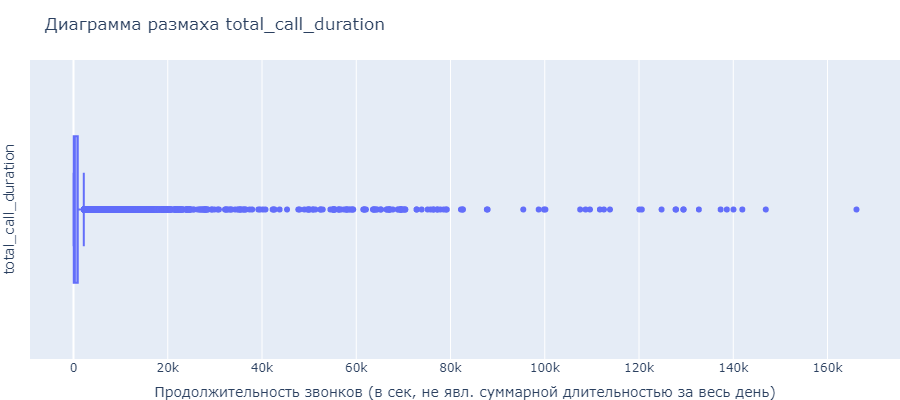

count     49002.000000
mean       1156.558202
std        4451.473661
min           0.000000
25%          46.000000
50%         208.000000
75%         901.000000
max      166155.000000
Name: total_call_duration, dtype: float64

In [20]:
animals(data, 'total_call_duration', 'Продолжительность звонков (в сек, не явл. суммарной длительностью за весь день)')

Среди 49002 записей в таблице `data` максимальное значение длительности звонков конкретной записи (не суммарная за день) равно 166155 сек или 46 часов. Что естественно является выбросом и сбоем в подсчете и записи данных. 

Возможные причины: задвоение при выгрузке, не срабатывание прерывания счетчика  секунд после завершения звонка, суммирование с другим оператором и т.п. 

Остается только догадываться. Но и оставить мы эти записи в таблице не можем, так как они сильно будут искажать общую картину данных о длительности звонков. 

Рассмотрим клиентов и их операторов, которые в день "наговаривают" больше, чем продолжительность трудового дня. Учтем, что могут быть и переработки. Примем максимальное число часов переработки за 4 (итого 16 часов или 57600 сек).

In [21]:
df_anorm = data[data['total_call_duration'] > 57600].sort_values(by='total_call_duration')

display(df_anorm.tail())

print('Количество таких строк:', df_anorm.shape[0])

print(df_anorm['user_id'].value_counts())
print()
print(df_anorm['operator_id'].value_counts())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6216,166582,2019-09-12,out,False,885876,False,696,125286,138643
6266,166582,2019-09-18,out,False,885876,False,1013,121664,140050
6192,166582,2019-09-09,out,False,885876,False,1138,121093,141930
6322,166582,2019-09-26,out,False,885876,False,843,132206,146903
6318,166582,2019-09-25,out,False,885876,False,1230,144395,166155


Количество таких строк: 82
166582    81
168361     1
Name: user_id, dtype: int64

885890    37
885876    35
925922     9
945278     1
Name: operator_id, dtype: Int64


Интересно, 82 записи, и все кроме одной принадлежат одному клиенту с `user_id` **166582** со 2.09 по 10.10.. Хороший повод чтобы отправить баг-репорт тех отделу по этому клиенту. 

Посмотрим на этого абонента отдельно. Выведем динамику продолжительности звонков (не суммарная за день) по датам.

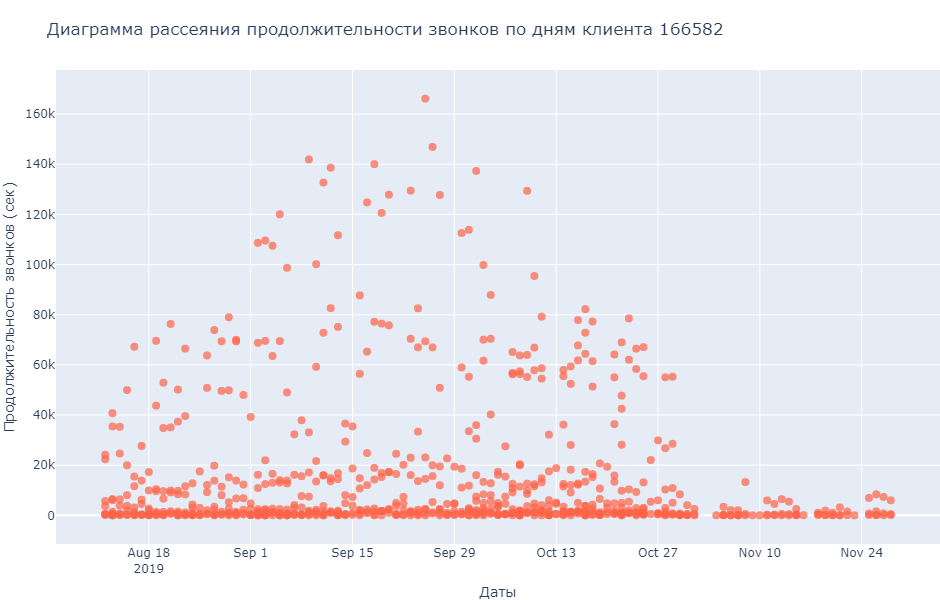

In [22]:
list_anorm = df_anorm['user_id'].unique().tolist()

df_user = data[data['user_id'] == list_anorm[0]].sort_values(by='date')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_user['date'], y=df_user['total_call_duration'], mode='markers', marker=dict(size=8, opacity=0.7, color='tomato')))
fig.update_layout(
                  autosize=False,
                  width=940,
                  height=600,
                  title="Диаграмма рассеяния продолжительности звонков по дням клиента 166582",
                  yaxis_title='Продолжительность звонков (сек)',
                  xaxis_title="Даты",
                  margin=dict(l=0, r=0, t=70, b=0))
fig.show()

На диаграмме видим, что аномально высокие значения длительности звонков у этого клиента начали появляться еще в конце августа. Пик таких выбросов пришелся на период с 1.09 по 13.10 примерно. А далее начиная с 4.11 активность клиента упала на порядок.

Проблема в том, что у нас нет возможности определить какая часть трафика повлияла на значение измеряемой величины так, что она превзошла порог. К тому же, убрав отдельные значения (опять же без обоснования почему именно эти) мы сильно влияем на показатели расхода конкретного пользователя. Значит придется удалить информацию по клиенту c 12.08.19 по 31.10.19 и в тех отдел направить баг-репорт с информацией о нем.

In [23]:
# выбираем уникальные даты клиента 166582 с августа по ноябрь
dt = df_user['date'].unique()
dt = dt[:82]

# получаем индексы строк клиента с выбранными днями
de = data[data['user_id'] == list_anorm[0]]
de = de[de['date'].isin(dt)]
de = de.index
len(de)

# очищаем data от указанных выше строк
data = data.drop(np.where((data.index.isin(de)))[0])

# посмотрим на потери
print('Осталось строк после удаления части записей клиента 166582:', data.shape[0])
print('Удалили', 49002 - data.shape[0], 'строк после удаления части записей клиента 166582')
print('Процент удаленных строк от всего чилсла:', round((1-data.shape[0]/49002)*100, 2))

Осталось строк после удаления части записей клиента 166582: 48344
Удалили 658 строк после удаления части записей клиента 166582
Процент удаленных строк от всего чилсла: 1.34


Посмотрим на второго клиента 168361

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
47526,168361,2019-11-04,out,False,945278,False,103,11553,58027


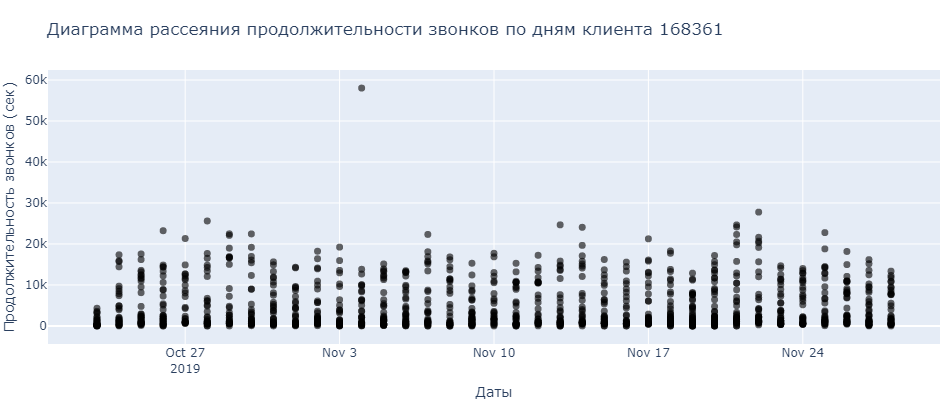

In [24]:
df_61 = data[data['user_id'] == list_anorm[1]]

display(data[data['total_call_duration'] > 57600])

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_61['date'], y=df_61['total_call_duration'], mode='markers', marker=dict(size=7, opacity=0.6, color='black')))
fig.update_layout(
                  autosize=False,
                  width=940,
                  height=400,
                  title="Диаграмма рассеяния продолжительности звонков по дням клиента 168361",
                  yaxis_title='Продолжительность звонков (сек)',
                  xaxis_title="Даты",
                  margin=dict(l=0, r=0, t=70, b=0))
fig.show()

С эти клиентом дела обстоят лучше. заметим, что он был активен только с конца октября по конец ноября. Видим 4.11 выброс. Варианта два. 1 - убрать данного клиента из дальнейшего исследования, так как удалять отдельное значение не имеет смысла. 2 - принять как исключение по переработке, так как остальные данные в порядке. 

Примем пока вариант 2.

Далее рассмотрим суммарные значения продолжительности разговоров в день по каждому оператору.

In [25]:
# группируем по дате и id оператора, и суммируем общие продолжительности звонков
df_2 = data.groupby(['date', 'operator_id', 'user_id']).agg({'total_call_duration' : 'sum', 'calls_count' : 'sum'}).reset_index().sort_values(by='total_call_duration', ascending=False)
df_2['mean_duration'] = round(df_2['total_call_duration']/df_2['calls_count'])
# записываем в отдельную таблицу операторов что превзошли порог в 57600 сек в день
df_anomal = df_2[df_2['total_call_duration'] > 57600].sort_values(by='total_call_duration', ascending=False)
display(df_anomal)
print('Количество строк в таблице:', df_anomal.shape[0])
print()
print(df_anomal['operator_id'].value_counts())
print()
print(df_anomal['user_id'].value_counts())

,date,operator_id,user_id,total_call_duration,calls_count,mean_duration
5893,2019-10-10,929424,167827,63253,1491,42.0
11505,2019-11-04,945278,168361,61611,227,271.0


Количество строк в таблице: 2

929424    1
945278    1
Name: operator_id, dtype: int64

167827    1
168361    1
Name: user_id, dtype: int64


Два оператора 945278 и 929424 и два клиента, уже знакомый 168361 и еще 167827. 

Рассмотрим подробнее 10.10.2019 и 4.11.2019 этих клиентов и операторов соотвественно.

In [26]:
list_anomal = df_anomal[['user_id', "operator_id"]]


dt1 = datetime.date(2019, 10, 10)
dt2 = datetime.date(2019, 11, 4)

df_27 = data[data['user_id'] == list_anomal.iloc[0,0]]

display(data[(data['date'] == dt1) 
             & (data['user_id'] == list_anomal.iloc[0,0]) 
             & (data['operator_id'] == list_anomal.iloc[0,1])])

display(data[(data['date'] == dt2) 
             & (data['user_id'] == list_anomal.iloc[1,0]) 
             & (data['operator_id'] == list_anomal.iloc[1,1])])

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
36847,167827,2019-10-10,out,False,929424,True,495,0,10489
36852,167827,2019-10-10,in,False,929424,False,26,259,298
36853,167827,2019-10-10,out,False,929424,False,970,41344,52466


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
47520,168361,2019-11-04,out,False,945278,True,124,0,3584
47526,168361,2019-11-04,out,False,945278,False,103,11553,58027


Продолжаем придерживаться плана 2. Считаем переработкой. Но запомним id этих клиентов и обязательно оставим упоминание о них в баг репорте.

Посмотрим на продолжительность вызовов в разрезе операторов по дням клиента 167827

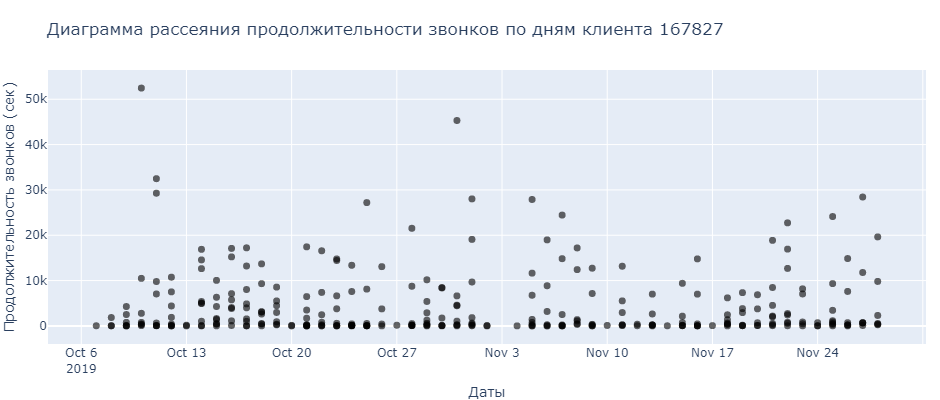

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_27['date'], y=df_27['total_call_duration'], mode='markers', marker=dict(size=7, opacity=0.6, color='black')))
fig.update_layout(
                  autosize=False,
                  width=940,
                  height=400,
                  title="Диаграмма рассеяния продолжительности звонков по дням клиента 167827",
                  yaxis_title='Продолжительность звонков (сек)',
                  xaxis_title="Даты",
                  margin=dict(l=0, r=0, t=70, b=0))
fig.show()

Может быть баг, может очередная переработка "усердного" оператора. Добавляем, как уже и было сказано, в баг-репорт, и по прежнему придерживаемся плана 2.

Готово. Запомним, что у клиентов 166582, 168361 и 167827 были выявлены аномалии в данных, и давать рекомендации по оптимизации использования тарифов для них стоит с осторожностью (или вовсе воздержаться).

Так же посмотрим на количество звонков (столбец `calls_count`) в день, которое совершает каждый оператор. Помним, что данный столбец содержит агрегированные значения (общее количество звонков `сумму` в день данным оператором для данного клиента). Учитывая, что за одним `operator_id` в конкретно выбранный день, стоит один человек, рассмотрим записи с количеством звонков превосходящих 400. Помним, что на расходы клиентов и на выручку компании этот показатель не влияет.

 <font size = 1> Информация о среднем количестве звонков в день одним оператором и из группы "Операторы call-центра" https://vk.com/topic-3441578_5989789. Исследование SMARTIS и I-Brand в области разработки и внедрения "предварительного оператора", бота снимающего бесполезную нагрузку с оператора  http://smartis.bi/faq/kak-priedvaritielnyi-opierator-chistit-call-tsientr-zastroishchika/.

In [28]:
# Отбираем записи с количеством звонков сверх 400
df_sort_call = data[data['calls_count'] > 400].sort_values(by='calls_count', ascending=False)

display(df_sort_call.head(10))
print('Количество строк в таблице:', df_sort_call.shape[0])
print()
print(df_sort_call['operator_id'].value_counts())
print()
print(df_sort_call['user_id'].value_counts())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
37046,167827,2019-11-11,out,False,929428,True,4817,0,5529
36993,167827,2019-10-31,out,False,929428,True,2614,0,45312
33709,167626,2019-10-07,in,False,<NA>,True,2168,0,2361
33737,167626,2019-10-08,in,False,<NA>,True,1917,0,2044
34151,167626,2019-10-15,in,False,<NA>,True,1914,0,2063
33917,167626,2019-10-11,in,False,<NA>,True,1705,0,2455
46242,168252,2019-11-25,in,False,<NA>,True,1679,0,42251
33570,167626,2019-10-04,in,False,<NA>,True,1641,0,1210
46290,168252,2019-11-26,in,False,<NA>,True,1590,0,42667
37009,167827,2019-11-05,out,False,929428,True,1533,0,27889


Количество строк в таблице: 86

908640    14
929428     9
929426     9
929424     4
Name: operator_id, dtype: Int64

168361    27
167827    22
167626    18
167285    14
168252     3
166405     2
Name: user_id, dtype: int64


4817 звонков в день выполнил/принял оператор 929428 для клиента 167827. Это абсолютный топ количества звонков, второе место топа также за этим оператором и клиентом. Далее идут клиенты с неопределенными операторами.

Обратим внимание, что в столбце `call_duration` нули, что означает "разговор не состоялся" + большая часть из топ-10 имеют значение `in` в `direction`, `is_missed_call` `True` и пропуск в `operator_id`, что означает "входящие, пропущенные, на которые система не назначила никакого оператора".

In [29]:
# Отбираем входящие, внутренние, пропущенные звонки
df_in_0 = data[(data['direction'] == 'in') \
               & (data['call_duration'] == 0) & data['is_missed_call'] == True] \
                    .sort_values(by='calls_count', ascending=False)

# Находим среднюю продолжительность таких звонков
df_in_0['mean_calls'] = round(df_in_0['total_call_duration']/df_in_0['calls_count'])


display(df_in_0.sort_values(by='mean_calls', ascending=False).head(5), df_in_0.shape[0])
print('Количество строк:', df_in_0.shape[0])

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_calls
2793,166485,2019-09-22,in,False,<NA>,True,1,0,465,465.0
17904,166983,2019-11-28,in,False,<NA>,True,1,0,366,366.0
3850,166503,2019-10-27,in,False,<NA>,True,1,0,354,354.0
5233,166536,2019-09-05,in,False,<NA>,True,1,0,332,332.0
11481,166732,2019-10-30,in,False,<NA>,True,2,0,588,294.0


7498

Количество строк: 7498


7498 строк активности клиентов не приносящей никакой прибыли. Среди которых в топе по средней длительности звонки на 7 минут. Настойчивый звонящий. И снова не назначенный оператор.

Рассмотрим какие разбросаны значения средней продолжительности таких вызовов.

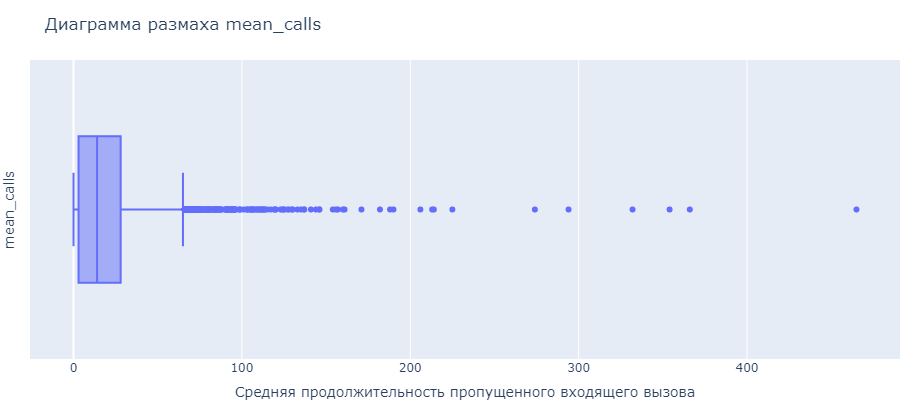

count    7498.000000
mean       19.037077
std        21.869829
min         0.000000
25%         3.000000
50%        14.000000
75%        28.000000
max       465.000000
Name: mean_calls, dtype: float64

In [30]:
animals(df_in_0, 'mean_calls', 'Средняя продолжительность пропущенного входящего вызова')

Достаточно интересно. Есть пропущенные входящие, средняя длительность которых превосходит 7 мин. Не слишком правдоподобно. Однако, стоит заметить, что входящие бесплатно, поэтому эти значения никак не повлияют ни на траты клиента, ни на доход компании. Но это еще один пункт в баг-репорт.

Рассмотрим теперь те из строк таблицы `data`, в которых `direction` принимает значение `out` т.е. исходящие (за такие звонки клиент платит согласно тарифу). 

In [31]:
# таблица исходящий, неотвеченных звонков с общим временем ожидания более 2 часов
df_out_0 = data[(data['direction'] == 'out') \
                & (data['call_duration'] == 0) \
                & (data['is_missed_call'] == True)] \
                    .sort_values(by='total_call_duration', ascending=False)
df_out_0['mean_calls'] = round(df_out_0['total_call_duration']/df_out_0['calls_count'])


display(df_out_0.head(7))
print('Количество строк:',  df_out_0.shape[0])
#display(df_out_0.mean_calls.median())

#display(data[(data['date'] == datetime.date(2019, 11, 11)) & (data['operator_id'] == 929428)])

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_calls
36993,167827,2019-10-31,out,False,929428,True,2614,0,45312,17.0
36999,167827,2019-11-01,out,False,929428,True,1529,0,28017,18.0
37009,167827,2019-11-05,out,False,929428,True,1533,0,27889,18.0
37023,167827,2019-11-07,out,False,929428,True,1365,0,24450,18.0
37016,167827,2019-11-06,out,False,929428,True,1045,0,18978,18.0
27451,167285,2019-10-22,out,False,908640,True,1141,0,16994,15.0
37099,167827,2019-11-22,out,False,929426,True,1020,0,16942,17.0


Количество строк: 13354


13354 записей с данным типом звонков (почти 28%). И снова в топ-5 оператор 929428 и клиент 167827 (занимают все первые 5 строк). Большое количество звонков и минут продолжительности вызовов при среднем значении длительности одного звонка 20 сек.

In [32]:
# Таблицу с исходящими, пропущенными группируем по дате, операторам и пользователем
df_3 = (
    df_out_0.groupby(['date', 'operator_id', 'user_id'])
                .agg({'total_call_duration' : 'sum', 'calls_count' : 'sum'})
                        .reset_index().sort_values(by='total_call_duration', ascending=False)
)
# Отбираем с общей продолжительностью звонков более часа
df_3 = df_3[df_3['total_call_duration'] > 3600]
df_3['mean_calls'] = round(df_3['total_call_duration'] / df_3['calls_count'])

display(df_3.head(6))
print('Количество строк:',  df_3.shape[0])
print()
print('Уникальные операторы с пропущенными исходящими более 1 часа и их количество:\n', df_3['user_id'].value_counts().head())

df_user_sum = df_3.groupby('user_id').agg({'total_call_duration':'sum', 'date':'count'})
df_user_sum['mean'] = round(df_user_sum['total_call_duration']/df_user_sum['date'])

df_user_sum.sort_values(by='mean', ascending=False)

,date,operator_id,user_id,total_call_duration,calls_count,mean_calls
6511,2019-10-31,929428,167827,45312,2614,17.0
6717,2019-11-01,929428,167827,28017,1529,18.0
7093,2019-11-05,929428,167827,27889,1533,18.0
7566,2019-11-07,929428,167827,24450,1365,18.0
7321,2019-11-06,929428,167827,18978,1045,18.0
5081,2019-10-22,908640,167285,16994,1141,15.0


Количество строк: 78

Уникальные операторы с пропущенными исходящими более 1 часа и их количество:
 167827    39
167626    15
167285    11
168361    10
168062     2
Name: user_id, dtype: int64


,total_call_duration,date,mean
user_id,,,
167827,394373,39,10112.0
167285,86906,11,7901.0
168361,42323,10,4232.0
167626,60155,15,4010.0
168018,3929,1,3929.0
168062,7766,2,3883.0


 `total_call_duration` 7-12 часов в день, которые уходят на непринятые звонки. Непродуктивно. 
 
 Для себя отметим клиентов 167827 (в среднем почти 3 часа в день исходящих, не взятых звонков), 167285 (2 часа). 
 Список операторов передадим вместе с результатами исследования. 
 
 Также вызывают интерес, исходящие, неотвеченные с малой средней продолжительностью (менее 3 секунд). 

In [33]:
df_report_call_out_missed = df_out_0[df_out_0['mean_calls'] < 3] \
                            .sort_values(by=['total_call_duration'], ascending=False)

df_report_call_out_missed.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,mean_calls
37046,167827,2019-11-11,out,False,929428,True,4817,0,5529,1.0
10014,166680,2019-11-25,out,False,960296,True,53,0,119,2.0
37043,167827,2019-11-11,out,False,929424,True,28,0,64,2.0
15289,166916,2019-11-06,out,True,906396,True,83,0,64,1.0
41616,168064,2019-11-03,out,False,939762,True,26,0,54,2.0


Например у вышеупомянутого клиента 167827, среднее время таких звонков 1 сек. Значит ожидание было 1 сек. Т.е. опретор ожидал ответ 1 сек. С какой целью он вообще совершал это звонок, а точнее более 4 тыс таких звонков.

С другой стороны посмотрим на максимальную среднюю продолжительность (время ожидания при исходящем звонке)

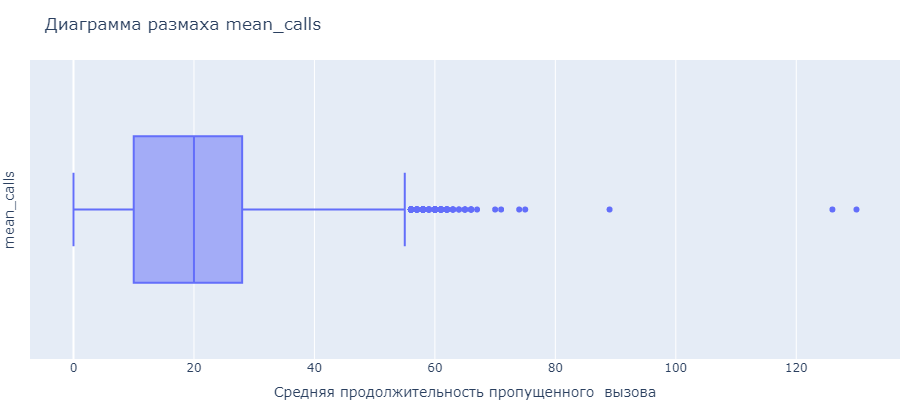

count    13354.000000
mean        20.241800
std         13.437441
min          0.000000
25%         10.000000
50%         20.000000
75%         28.000000
max        130.000000
Name: mean_calls, dtype: float64

In [34]:
animals(df_out_0, 'mean_calls', 'Средняя продолжительность пропущенного  вызова')

Тут другая "сторона медали". 2 минуты ожидания - настойчивый оператор, заинтересованный получить ответ.

Но с другой стороны, если посмотреть на суммарные значения времени ожидания и средние уже по ним, то картина несколько выравнивается

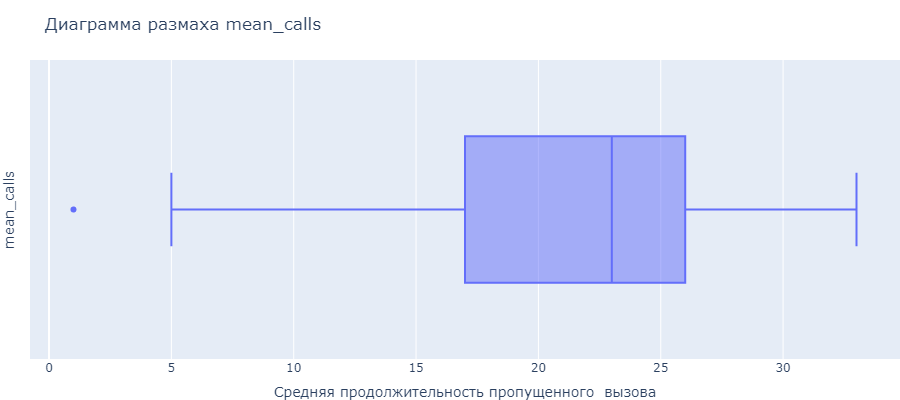

count    78.000000
mean     21.564103
std       6.224355
min       1.000000
25%      17.250000
50%      23.000000
75%      25.750000
max      33.000000
Name: mean_calls, dtype: float64

In [35]:
animals(df_3, 'mean_calls', 'Средняя продолжительность пропущенного  вызова')

Также при обработке данных заметили, что есть вызовы отмеченные маркером `is_missed_call` как `True` т.е пропущенные, но имеющие в `call_duration` ненулевые значения. Получается, что звонок отмечен как пропущенный, но разговор был. Видимо какая-то ошибка маркера пропущенных звонков. 

In [36]:
# Пропущенные с ненулевым временем разговора
anomal_df_missed = (
    data[(data.call_duration !=0) & (data.is_missed_call ==True)]
    .sort_values(by='call_duration', ascending=False)
)
display(anomal_df_missed.head())
print('Количество таких записей', anomal_df_missed.shape[0], 'и клиентов', anomal_df_missed['user_id'].nunique())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
46214,168252,2019-11-25,in,False,940630,True,2,741,747
45605,168252,2019-10-28,in,False,940658,True,3,670,681
45872,168252,2019-11-12,in,False,940588,True,3,638,651
45609,168252,2019-10-28,in,False,940630,True,4,636,652
45938,168252,2019-11-14,in,False,940588,True,4,601,624


Количество таких записей 282 и клиентов 60


От 12 минут длился такой разговор "пропущенного" вызова. Имеем 282 такие записи в `data`, в которых 60 уникальных клиентов. Тоже заметку отправляем в баг-репорт.

**ВЫВОДЫ**

* Рассмотрели разброс длительности звонков `total_call_duration`. Нашли выбросы (записи о длительности звонков на одного клиента, превышающие 24 часа)
* Выяснили, что большая их часть принадлежит клиенту 166582 и пик выбросов пришелся на 1.09 - 13.10.
* Удалили информацию об этом клиенте с 12.08 по 31.10, так как удалять отдельные значения не имеет смысла. Удаленные строки составили всего один процент.
* Клиент 168361 4.11 имел значение длительности звонка сильно выбивающиеся из остальных. Решено было оставить, считая переработкой, но информацию по нему отправили в баг-репорт.
* Рассмотрели суммарные за день значения продолжительности звонков. Нашли еще одного клиента 167827 с аномально высоким значение 10.10. 
* Интересно что эти выбросы, переработки у клинтов 168361 и 167827 принадлежат одному оператору 945278.
* По клиенту 167827 принято решение аналогично предыдущему клиенту. Считаем переработкой, записываем в баг-репорт, имеем ввиду далее.
* Исследовали и количество звонков. Наибольшее их количество у входящих внутренних пропущенных звонков. В топ-3 операторов по количеству звонков стоит отметить оператора 929428 совершающего 4817 звонков в первой записи и 2614 во второй (в разные дни) и 1533 звонка в третий день, и кстати все для клиента 167827. На третьем месте NA, id оператора неопределенно. С 3 по 9 места в топ-10 операторов по количеству звонков идет неопределенный оператор принимающий внутренний звонок. Во всех звонках из топ-10 всего три клиента - 167827 (3 записи), 167626 (5 записей) и 168252 (2 записи).
* Рассмотрели входящие, пропущенные, внутренние звонки. Таких записей оказалось 7612 (или 16% от числа оставшихся строк). Средняя их продолжительность 19 сек, но есть отдельные записи от 1 мин. до 7 мин.
*  Определили клиентов, у которых исходящих, с нулевой длительностью разговора более часа в одной записи, и количество таких записей: клиент 167827 - 39 записей, 167626 - 15 записей, 167285 - 11 записей, 168361 и 168062 - 10 и 2 записи соответственно.к
* Помимо длительных исходящих пропущенных, есть и совсем короткие (1-2 сек), например клиент 167827 11.11 имел 4817 таких звонков, средней продолжительности 1 сек (929428). Стоит упомянуть об этом в баг-репорте. 
* Определили максимальное время ожидания при исходящем пропущенном и среднее по суммарному значению времени ожидания. Они составили 2 минуты и 22 сек соответственно.
* Выяснили, что в данных есть еще одна ошибка - пропущенные звонки (`internal` со значением `True`) с ненулевой продолжительностью РАЗГОВОРА. 282 записи (около 0.6%), в которых 60 клиентов. Еще одна заметка для баг-репорта.

### Обработка пропусков

* Выдвинем предположения о возможных причинах появления пропусков (технический сбой или действительное отсутствие значения параметра). 
* Определим какие пропуски стоит оставить без изменений, какие стоит заполнить, а какие удалить (строки с пропусками).

Выведем общую информацию по пропускам в data.

In [37]:
df_null = sum(data.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
print('Количество строк с пропуском хотя бы в одном столбце:', df_null)
print('Процент строк с пропуском хотя бы в одном столбце:', round(df_null / len(data) * 100, 2), '%')

for name in data:
    missed_values = data[name].isna().sum() / len(data)
    print(name, f'{missed_values:.2%}')

Количество строк с пропуском хотя бы в одном столбце: 7420
Процент строк с пропуском хотя бы в одном столбце: 15.35 %
user_id 0.00%
date 0.00%
direction 0.00%
internal 0.23%
operator_id 15.23%
is_missed_call 0.00%
calls_count 0.00%
call_duration 0.00%
total_call_duration 0.00%


Как и отмечалось в обзоре данных, пропуски в столбцах `internal` и `operator_id`. Оба столбца важны при расчете расходов клиента по тарифному плану, так как входящие звонки бесплатны, а за каждого оператора клиент платит 100 руб в месяц.

Также отметим, что в разделе поиска аномалий, отмечались пропуски в столбце `operator_id`, для которых в столбце call_duration нули ("разговор не состоялся"),а в `direction` и `is_missed_call` значения `in` и  `True` соответственно. Такие пропуски означают входящий непринятый звонок, на который просто не был назначен оператор. Значит за ним не скрывается оператор, и это никак не влияет на расходы клиента.

Посмотрим, сколько таких пропусков в `operator_id`, которые никак не влияют на расходы клинта.

In [38]:
print('Количество пропусков в operator_id:', 
      data[data.operator_id.isnull()].shape[0])

print('Количество записей о входящих звонках с пропусками в operator_id:', 
      data[(data.operator_id.isnull()) & (data.direction == 'in')].shape[0])

print('Количество записей о входящих звонках с пропусками в operator_id, являющиеся пропущенными:', 
      data[(data.operator_id.isnull()) & (data.is_missed_call == True) & (data.direction == 'in')].shape[0])

print('Количество записей об исходящих звонках с пропусками в operator_id и нулевым временем ожидания:', 
      data[(data.operator_id.isnull()) & (data.total_call_duration == 0) & (data.direction == 'out')].shape[0])

Количество пропусков в operator_id: 7365
Количество записей о входящих звонках с пропусками в operator_id: 7188
Количество записей о входящих звонках с пропусками в operator_id, являющиеся пропущенными: 7120
Количество записей об исходящих звонках с пропусками в operator_id и нулевым временем ожидания: 87


Видим, что лишь в 177 строках, содержащих информацию о исходящих звонках, присутствуют пропуски в `operator_id`, среди которых 87 записей с нулями в `total_call_duration`.

Сначала создадим список клиентов с пропущенными входящими. На эти вызовы просто могли не назначить оператора. Обрыв связи, прекращение звонка звонившим и т.п.

In [39]:
# Таблица с пропусками в operator_id с пропущенными входящими вызовами
oper_null_missed = data[(data.operator_id.isnull()) 
                 & (data.is_missed_call == True) 
                 & (data.direction == 'in')]
# Группируем по user_id и считаем общую продолжительность вызовов, количество записей
oper_null_missed_user_count = oper_null_missed.groupby('user_id', as_index=False) \
        .agg({'total_call_duration':'sum', 'date':'count'}) \
        .rename(columns={'date':'count_rec'}) \
        .sort_values(by='count_rec', ascending=False)


display(oper_null_missed_user_count.head(9))
print('Пользователей с неопределенным количеством операторов:', oper_null_missed_user_count.shape[0])
#oper_null_missed_user_count.user_id.to_list()

,user_id,total_call_duration,count_rec
4,166405,73891,111
30,166658,4727,98
80,166983,12656,89
51,166782,7055,87
68,166916,9838,81
19,166541,9695,77
161,167497,7992,76
42,166708,7760,76
16,166520,7809,74


Пользователей с неопределенным количеством операторов: 305


Много, но проблемы нет, не назначен - не оплачен. Все в порядке.

Посмотрим на пропуски в поле `operator_id` для непрощенных вызовов, продолжительность которых ненулевая.

In [40]:
df = data[(data.operator_id.isnull())&(data.is_missed_call == False)&(data.call_duration != 0)]
oper_null_error = df.groupby('user_id', as_index=False)['date'].count().sort_values(by='date', ascending=False)
display(oper_null_error)


,user_id,date
9,168252,83
2,166782,16
1,166503,3
8,168018,3
0,166399,2
3,166916,1
4,166946,1
5,167402,1
6,167819,1
7,167977,1


Вот тут уже другая история. звонок был, разговор был, оператора не было. Ошибка. Список этих пользователей в баг-репорт. В случает одного пропуска вопрос 100р, не большая разница (если итоговый расход конечно не 1000). В случае 83 пропусков - ощутимая разница в любом случае!

Пропуски на входящих с ненулевым значением длительности разговора.

In [41]:
oper_null_in = data[(data.operator_id.isnull()) 
                 & (data.call_duration != 0) 
                 & (data.direction == 'in')]

oper_null_in_user_count = oper_null_in.groupby('user_id', as_index=False) \
        .agg({'total_call_duration':'sum', 'date':'count'}) \
        .rename(columns={'date':'count_rec'}) \
        .sort_values(by='count_rec', ascending=False)


display(oper_null_in_user_count)
print('Клиентов с неопределенным количеством операторов при входящих с ненулевой длительностью разговора:', oper_null_in_user_count.user_id.nunique())
oper_null_in_user_count.user_id.head(9).to_list()

,user_id,total_call_duration,count_rec
8,168252,321346,43
2,166782,2197,16
0,166399,170,2
1,166503,405,1
3,166916,54,1
4,166946,180,1
5,167402,52,1
6,167819,372,1
7,167977,136,1
9,168336,174,1


Клиентов с неопределенным количеством операторов при входящих с ненулевой длительностью разговора: 10


[168252, 166782, 166399, 166503, 166916, 166946, 167402, 167819, 167977]

Аналогичная история. Кстати клиенты 168252 и 166782 были замечены и ранее, и вошли в топ-3 по количеству пропусков.

Пропуски на исходящих с ненулевым значением длительности разговора.

In [42]:
oper_null = data[(data.operator_id.isnull()) 
                 & (data.call_duration != 0) 
                 & (data.direction == 'out')]

oper_null_user_count = oper_null.groupby('user_id', as_index=False) \
        .agg({'total_call_duration':'sum', 'date':'count'}) \
        .rename(columns={'date':'count_rec'}) \
        .sort_values(by='count_rec', ascending=False)


display(oper_null_user_count)
print('Пользователей с неопределенным количеством операторов:', oper_null_user_count.shape[0])
oper_null_user_count.user_id.to_list()

,user_id,total_call_duration,count_rec
2,168252,177875,40
1,168018,1828,3
0,166503,617,2


Пользователей с неопределенным количеством операторов: 3


[168252, 168018, 166503]

3 пользователя. И снова один из них 16852. А сколько же у него всего таких пропусков. 

In [43]:
data[(data.operator_id.isnull()) & (data.call_duration != 0)& (data.user_id == 168252)].shape[0]
                 

83

Причем среди этих 83 нет ни одного с пометкой "пропущенный". 

In [44]:
data = data[data.user_id != 168252]
data= data[data.user_id != 166782]


Удалили, записали в баг-репорт.

Посмотрим на пропуски в столбце `internal`. И снова, в случае входящих вызовов, никаких негативных последствий эти пропуски не несут. Посмотрим на исходящие.

In [45]:
int_null = data[(data.internal.isnull()) & (data.direction == 'out')]
int_null

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
19099,167016,2019-10-23,out,NaN,<NA>,True,3,0,196
46717,168291,2019-11-28,out,NaN,<NA>,True,3,0,93


Всего два клиента, с общим временем звонков 3 и 1.5 минуты. При любом значении `internal` это не окажет существенного влияния на их расходы. 

**ВЫВОДЫ**
    * В `data` были обнаружены пропуски в столбцах `internal` и `operator_id` 0.2% и 15.2% соответственно.
    * Среди пропусков в `operator_id` есть записи со входящими звонками, входящими пропущенными (примерно одинаковое количество близкое к общему числу пропусков), записи с исходящими звонками менее 2% от числа пропусков в `operator_id`, среди них 87 с исходящими и нулевым значением времени ожидания.
    * Выявили 305 уникальных клиентов с не назначенным оператором (входящий, пропущенный звонок)
    * По входящим с ненулевой длительностью 10 клиентов.
    * Создали список клиентов с пропусками в operator_id при непропущенных, ненулевых звонках. `oper_null_erroe` хранит информацию об id клиента и количестве пропусков в `operator_id`. Всего 11 клиентов с количеством пропусков от 1 до 83.
    * Имеем 10 клиентов с пропусками операторов при входящих с ненулевой длительностью разговора с количеством пропусков от 1 до 43.
    * Выделили двух клиентов 168252 и 166782 с 83 и 16 пропусками по непропущенным ненулевым и 43 и 16 пропусками входящим ненулевым соответственно. 
    * Рассмотрели пропуски операторов по исходящим ненулевым. Клиентов таких всего три, и первое место с 40 пропусками снова занимает 168252.
    * Удалили из `data` этих пользователей.
    * Вывели пропуски в `internal` для исходящих звонков. Всего два клиента с несущественными продолжительностями звонков.

## Исследовательский анализ данных

### Анализ общей информации о клиентах

#### Уникальные пользователи и операторы

* Узнаем какое количество уникальных клиентов и операторов содержится в данных. 
* Сколько операторов приходится на каждого клиента.

In [46]:
print('Количество уникальных клиентов таблицы clients:', clients.user_id.nunique())
print('Количество уникальных клиентов таблицы data:', data.user_id.nunique())
print('Общее количество уникальных операторов:', data.operator_id.nunique())

Количество уникальных клиентов таблицы clients: 732
Количество уникальных клиентов таблицы data: 305
Общее количество уникальных операторов: 1057


Посмотрим какое количество опертаоров приходится на каждого клиента.

In [47]:
operators_count = data.groupby('user_id')['operator_id'].nunique().reset_index()
display(operators_count.sort_values(by='operator_id', ascending=True).head(10))
print('Клиентов без операторов:', operators_count[operators_count['operator_id'] == 0]['user_id'].nunique())

,user_id,operator_id
98,167077,0
188,167721,0
176,167631,0
216,167939,0
225,167981,0
235,168013,0
240,168024,0
23,166584,0
21,166554,0
136,167265,0


Клиентов без операторов: 17


Наибольшее количество операторов 50 (без учета количества пропусков в столбце `operator_id`). Помним, что в `oper_null_user_count` хранятся id тех клиентов, у которых есть пропуски в `operator_id`.

**ВЫВОДЫ**

* Количество уникальных клиентов таблиц clients и data 732 и 305 соответственно (после удаления двух клиентов)
* Количество уникальных операторов - 1057
* Наибольшее количество операторов приходится на клиента 168187 - 50.
* Клиентов без операторов - 17, или 6%.

#### Даты регистрации и активности

Изучим информацию о датах регистрации клиентов в сревисе. Выведем дату первой регистрации и последней.

In [48]:
print('Дата первой регистрации:', clients['date_start'].min().strftime('%d.%m.%Y'))
print('Последняя дата регистрации:', clients['date_start'].max().strftime('%d.%m.%Y'))


Дата первой регистрации: 01.08.2019
Последняя дата регистрации: 31.10.2019


Рассмотрим данне об активности клиентов. Данными за какой промежуток времени мы располагаем?

In [49]:
first_dt = data['date'].min()
last_dt = data['date'].max()
print('Дата первой активности клиентов:', first_dt.strftime('%d.%m.%Y'))
print('Дата последней активности клиентов:', last_dt.strftime('%d.%m.%Y'))
print('Временной интервал данных в днях:', (last_dt - first_dt).days)

Дата первой активности клиентов: 02.08.2019
Дата последней активности клиентов: 28.11.2019
Временной интервал данных в днях: 118


Значит в нашем распоряжении данные почти за 4 месяца (с начала августа по конец ноября), а регистрировались пользователи на протяжении трех месяцем (с начала августа по конец октября).

Определим сколько дней пользователь является клиентом компании, а сколько дней пользовался ее услугами (последним днем - горизонтом, будем считать 28.11.2019)

In [50]:
final_dt = datetime.date(2019,11,28)
#final_dt = '2019-11-28'
#user_dt_client = clients
clients['span_days'] = (final_dt - clients['date_start'])
clients['span_days'] = clients['span_days'].apply(lambda x: x.days)

display(clients.sort_values('span_days', ascending=False).sample(5))
clients.span_days.describe()

,user_id,tariff_plan,date_start,span_days
510,166591,B,2019-08-09,111
409,166391,C,2019-08-01,119
590,166532,B,2019-08-07,113
39,166465,A,2019-08-05,115
657,166594,B,2019-08-09,111


count    732.000000
mean      74.306011
std       26.446483
min       28.000000
25%       51.000000
50%       73.000000
75%       97.000000
max      119.000000
Name: span_days, dtype: float64

Как видим есть те, кто с компанией все исследуемое время, есть те кто всего лишь около месяца (28 дней). В среднем пользователь является клиентом компании чуть больше двух месяцев. 

Всех клиентов можем разделить на 4 категории:
1. С компанией только месяц
2. С компанией больше месяца, но меньше двух
3. С компанией больше двух месяцев, но меньше 3
4. С компанией от 3 до 4 месяцев.

Применим такую категоризацию и посмотрим количество клиентов в каждой из категорий.

In [51]:
# функция для категоризации клиентов
def count_m(x):
    if x <= 31:
        return 'one'
    elif 31<x and x<=62:
        return 'one_or_two'
    elif 62<x and x<=93:
        return 'two_or_three'
    elif 93<x and x<=124:
        return 'three_or_four'

In [52]:
# Применяем к таблице clients
clients['month'] = clients['span_days'].apply(lambda x: count_m(x))

clients.head(3)

,user_id,tariff_plan,date_start,span_days,month
0,166713,A,2019-08-15,105,three_or_four
1,166901,A,2019-08-23,97,three_or_four
2,168527,A,2019-10-29,30,one


Готово. Теперь посмотрим на количество клиентов в каждой категории. Отберем сразу тех из них, по кому у нас информация в таблице data

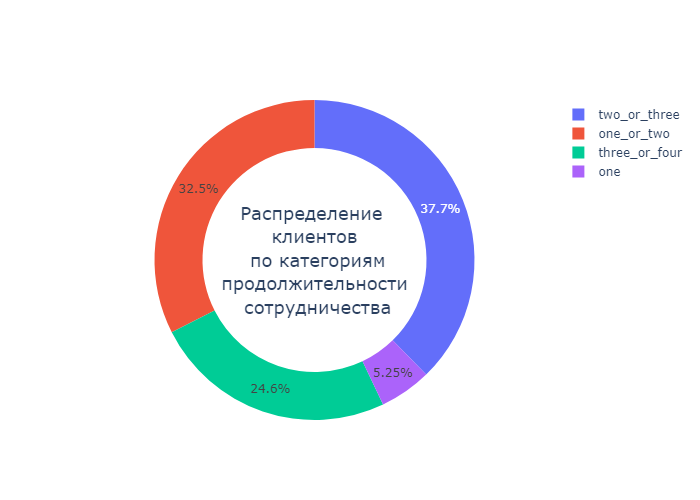

In [53]:
# Количество клиентов по категориям из таблицы clients
cl = clients['month'].value_counts().reset_index().rename(columns={'index':'category'})

# Составим список уникальных клиентов таблицы data
us = data['user_id'].to_list()
set_us = set(us) 
list_users = (list(set_us))

# Отберем из таблицы cl только тех клиентов, что есть в data, так как исследуем мы ее
df_clients = clients[clients['user_id'].isin(list_users)]
cl_data = df_clients['month'].value_counts().reset_index().rename(columns={'index':'category'})

fig = go.Figure()
fig.add_trace(go.Pie(values=cl_data['month'], labels=cl_data['category'], hole=0.7))

fig.update_layout(
    annotations=[dict(text='Распределение <br> клиентов <br>  по категориям <br> продолжительности <br> сотрудничества',
                      x=0.5, y=0.5, font_size=18, showarrow=False)])
fig.show()

Как видим из диаграммы, наибольшее количество клиентов с компанией от двух до трех месяцев - 115, от месяца до двух - 100 клиентов, от трех до четырех месяцев - 76 и один месяц - 36 клиентов.

Теперь посчитаем какой промежуток времени каждый клиент пользовался услугами компании (в днях). 

Готово. Теперь найдем первую и последнюю даты активности клиента и их разницу.

In [54]:
min_days = []
max_days = []

'''Пройдем по списку уникальных user_id из data, 
найдем первые и последние даты активности клиентов из таблицы data'''
for user in list_users:
    
    min_dt = data[data.user_id == user]['date'].min()
    max_dt = data[data.user_id == user]['date'].max()
    
    min_days.append(min_dt)
    max_days.append(max_dt)

Есть. Осталось собрать датафрейм из этих списков.

In [55]:
# Создаем датафрейм df_duration_days 
df_duration_days = pd.DataFrame({'user_id': list_users, 'min_days': min_days, 'max_days':max_days})
df_duration_days['span_days'] = df_duration_days.max_days - df_duration_days.min_days 

# Убираем "days" из записи значений в span_days, оставляем только количество дней
df_duration_days['span_days'] = df_duration_days['span_days'].apply(lambda x: x.days)

df_duration_days.sort_values(by='span_days', ascending=False).head(5)

,user_id,min_days,max_days,span_days
4,166406,2019-08-02,2019-11-28,118
300,166392,2019-08-02,2019-11-28,118
3,166405,2019-08-03,2019-11-28,117
292,166377,2019-08-04,2019-11-28,116
19,166428,2019-08-05,2019-11-28,115


Теперь у нас есть таблица с датой первой и датой последней активностей клиента. Категоризируем продолжительности (временной интервал в месяцах) активности клиентов.

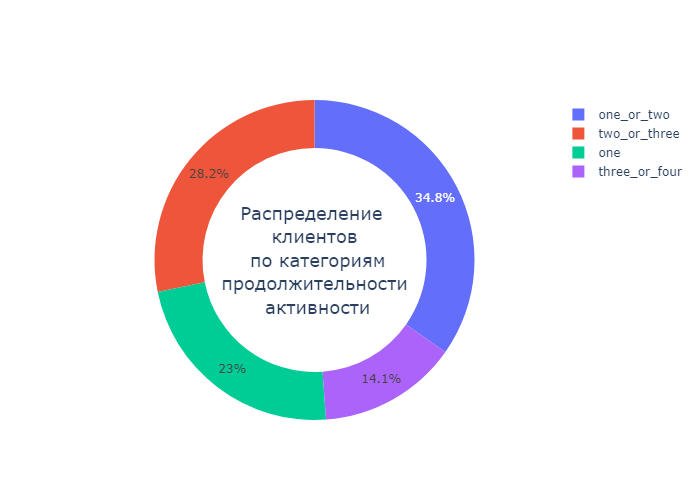

In [56]:
# Применяем ранее созданную функцию count_m(), категоризирующую промежутки активности, к таблице df_duration_days
df_duration_days['month'] = df_duration_days['span_days'].apply(lambda x: count_m(x))
dates_spans = df_duration_days['month'].value_counts().reset_index().rename(columns={'index':'category'})

# Строим торовую диаграмму
fig = go.Figure()
fig.add_trace(go.Pie(values=dates_spans['month'], labels=dates_spans['category'], hole=0.7))

fig.update_layout(
    annotations=[dict(text='Распределение <br> клиентов <br>  по категориям <br> продолжительности <br> активности',
                      x=0.5, y=0.5, font_size=18, showarrow=False)])
fig.show()

Продолжительность активности клиентов распределилась несколько иначе, нежели продолжительность сотрудничества. Теперь наибольшее количество клиентов попали в категорию от месяца до двух - 107, 86 - от двух до трех месяцев, 70 - один месяц и меньше, и 44 - от трех до четырех месяцев. 

Однако стоит отметить, что мы указали промежутки активности, а не количество дней, в которые клиент пользовался услугами компании. Для получения этой информации нужно посчитать количество дней для каждого пользователя в data.

In [57]:
# Сгруппируем data по user_id и date, посчитав общую сумму total_call_duration
data_days = data.groupby(['user_id', 'date']).agg({'total_call_duration':sum}).reset_index()


count_days_users = data_days.groupby('user_id')['date'].count().reset_index().rename(columns={'date':'count_days'})
count_days_users = count_days_users.sort_values(by='count_days', ascending=False)

display(count_days_users.head(7))

print('Процент пользователей с количеством рабочих дней не более 1 месяца:',
      int(count_days_users[count_days_users['count_days'] <= 31].shape[0]/count_days_users.shape[0]*100))


,user_id,count_days
4,166405,111
30,166658,101
13,166503,99
39,166691,96
5,166406,91
36,166678,90
79,166983,88


Процент пользователей с количеством рабочих дней не более 1 месяца: 54


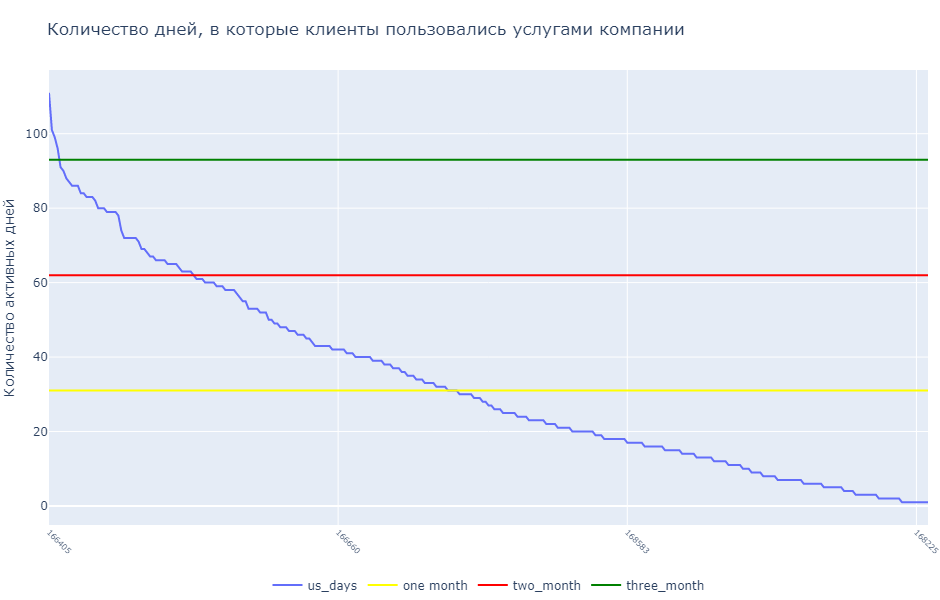

In [58]:
count_days_users['user_id'] = count_days_users['user_id'].apply(lambda x: str(x))


fig = make_subplots(rows=1, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)


fig.add_trace(go.Scatter(
        x=count_days_users['user_id'],
        y=count_days_users['count_days'],
        mode='lines',
        name='us_days'))

# Три линии, разделяющие продолжительность активность по меяцам (1, 2 и 3 месяца)
fig.add_trace(go.Scatter(
        name='one month',
        x = ['166405','167139'],
        y = [31, 31],
        mode = "lines",
        marker = dict(color = 'yellow')
    ),row=1, col=1)

fig.add_trace(go.Scatter(
        name='two_month',
        x = ['166405','167139'],
        y = [62, 62],
        mode = "lines",
        marker = dict(color = 'red')
    ),row=1, col=1)

fig.add_trace(go.Scatter(
        name='three_month',
        x = ['166405','167139'],
        y = [93, 93],
        mode = "lines",
        marker = dict(color = 'green')
    ),row=1, col=1)

fig.update_layout(
                  autosize=False,
                  width=940,
                  height=600,
                  title="Количество дней, в которые клиенты пользовались услугами компании",
                  yaxis_title='Количество активных дней',
                  legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=70, b=0))

fig.update_xaxes(dtick=100,
    tickangle=45,
                tickfont=dict(size=8))

fig.show()

Как видно из графика, большая часть клиентов пользовались услугами компании меньше месяца. 

Далее найдем для каждого клиента не просто количество рабочих дней за все время сотрудничества, а именно число рабочих дней в каждом месяце.

Разделим датафрейм data на 4 датафрейма df_aug, df_sep, df_oct, df_nov по месяцам активности клиентов.

In [59]:
m_list = ['aug', 'sep', 'oct', 'nov']

# data по месяцам
df_aug = data.query("datetime.date(2019,8,2) <= date <= datetime.date(2019,8,31)")
df_sep = data.query("datetime.date(2019,9,1) <= date <= datetime.date(2019,9,30)")
df_oct = data.query("datetime.date(2019,10,1) <= date <= datetime.date(2019,10,31)")
df_nov = data.query("datetime.date(2019,11,1) <= date <= datetime.date(2019,11,28)")

# Пустые датафреймы
df_aug_group = pd.DataFrame()
df_sep_group = pd.DataFrame()
df_oct_group = pd.DataFrame()
df_nov_group = pd.DataFrame()

# Листы с именами таблиц
df_list = [df_aug_group, df_sep_group, df_oct_group, df_nov_group]
df_month = [df_aug, df_sep, df_oct, df_nov]

# Цикл по созданию таблиц по месяцам с агрегированными данными клиентов
df_full_list = []

for df_x, df_m in zip(df_list, df_month):
    df_x = (
        df_m.groupby(['user_id', 'direction', 'internal'])
        .agg({'calls_count' : 'sum', 
              'total_call_duration' : 'sum'})
        .reset_index()
    )
    df_full_list.append(df_x)

Готово. В нашем распоряжении 4 таблицы по месяцам активности клиентов (август, сентябрь, октябрь, ноябрь). Они содержат информацию о типах вызова (вход/внутр, вход/внеш, исх/внутр, исх/внешн), а также агрегированные значения количества звонков и общей продолжительности звонков для каждого клиента по этим типам звонков в данном месяце.

Теперь мы можем детализировать активность клиентов в днях по месяцам.

In [60]:
df_nov.groupby('user_id', as_index=False)['date'].nunique()

,user_id,date
0,166377,19
1,166391,3
2,166392,19
3,166405,28
4,166406,17
...,...,...
254,168583,16
255,168598,17
256,168601,23
257,168603,5


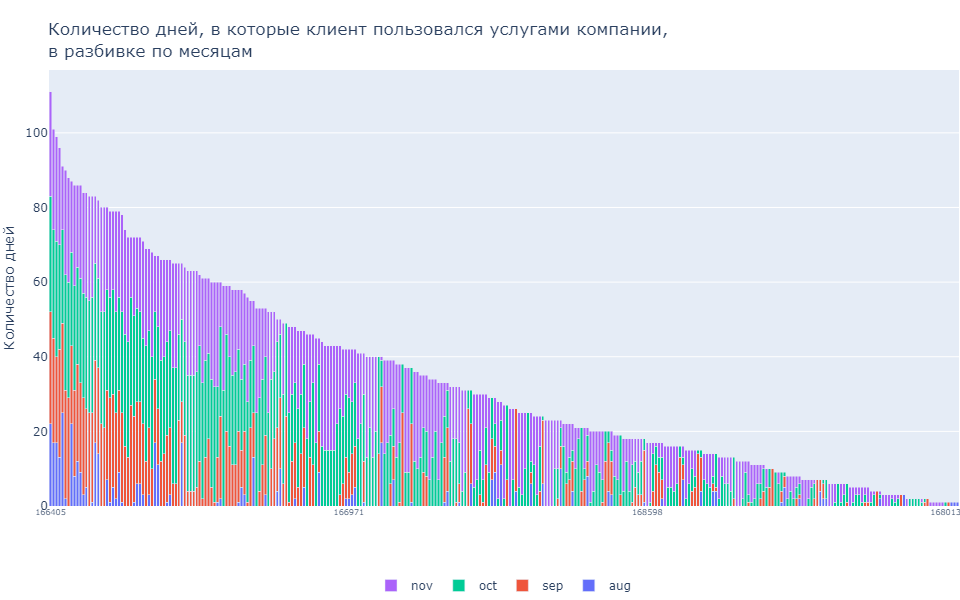

In [61]:
# Группируем каждую таблицу по user_id 
# и считаем количество уникальных дат активности клиента (рабочие дни в месяце)
df_date_aug = df_aug.groupby('user_id', as_index=False)['date'].nunique()
df_date_sep = df_sep.groupby('user_id', as_index=False)['date'].nunique()
df_date_oct = df_oct.groupby('user_id', as_index=False)['date'].nunique()
df_date_nov = df_nov.groupby('user_id', as_index=False)['date'].nunique()

# Id в строки, чтобы не упорядочивать по номеру id
for m in m_list:
    globals()['df_date_' + m]['user_id'] = globals()['df_date_' + m]['user_id'].apply(lambda x : str(x))

fig=go.Figure()

for m in m_list:
    fig.add_trace(go.Bar(
        x=globals()['df_date_' + m]['user_id'],
        y=globals()['df_date_' + m]['date'],
        #orientation='h',
        name=m))


fig.update_layout(
                  barmode='stack',
                  autosize=False,
                  width=960,
                  height=600,
                  title="Количество дней, в которые клиент пользовался услугами компании,<br>в разбивке по месяцам",
                  yaxis_title='Количество дней',
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center", y=-.15),
                  margin=dict(l=0, r=0, t=70, b=0))

fig.update_xaxes(#tickangle=45,
                dtick=100,
                tickfont=dict(size=8))

fig.show()

По графику видим:
* Наибольшее количество рабочих дней приходится на ноябрь, октябрь.
* Не более 7 клиентов были стабильно активны все 4 исследуемых месяца.
* По больше часть клиенты активны 3 и менее месяцев.
* Август - месяц наименьшего числа рабочих дней
* Есть клиенты с одним рабочим днем, в одном месяце
* Примерно у половины клиентов число рабочих дней за все 4 месяца не превышает 30
* У четверти число рабочих дней в месяце менее двух недель

Соберем данные о рабочих днях во всех месяцах в одну таблицу `months_days`.

In [62]:
# Количество рабочих дней по месяцам у клиентов (срез с >= 14 раб дней или 0)

for m in m_list:
    globals()['ul_'+m] = globals()['df_date_'+m][globals()['df_date_'+m]['date'] >= 10]

nov_oct = ul_nov.merge(ul_oct, on='user_id', how='outer', suffixes=('_nov', '_oct'))
sep_aug = ul_sep.merge(ul_aug, on='user_id', how='outer', suffixes=('_sep', '_aug'))
months_days = nov_oct.merge(sep_aug, on='user_id', how='outer').fillna(0)

months_days.head()

,user_id,date_nov,date_oct,date_sep,date_aug
0,166377,19.0,25.0,21.0,22.0
1,166392,19.0,22.0,15.0,11.0
2,166405,28.0,31.0,30.0,22.0
3,166406,17.0,25.0,24.0,25.0
4,166407,19.0,26.0,18.0,0.0


И мы еще на шаг ближе к составлению портрета активного пользователя. На данный момент он - имеет не только входящие, но и обязательно исходящие вызовы, контактирует более чем с 10 операторами, рабочих дней не менее 10 и скорее всего есть рабочие дни в ноябре.

**ВЫВОДЫ**
* В нашем распоряжении информация о клиентах, регистрировавшихся с 1.08.19 по 31.10.19
* Активность клиентов отражена в таблице `data`, события в которой принадлежат временному отрезку со 2.08.19 по 28.11.19
* Общий временной интервал активности почти 4 месяца или 118 дней точно.
* Определили как долго с компанией клиенты. Максимальная продолжительность сотрудничества 119 дней, минимальная - 28, средняя - 74 (от даты регистрации до последней даты в `data`)
* Разделили клиентов на 4 категории: 1.) С компанией только месяц; 2.) С компанией больше месяца, но меньше двух; 3.) С компанией больше двух месяцев, но меньше 3; 4.) С компанией от 3 до 4 месяцев.
* Наибольшее количество клиентов сотрудничают с компанией от двух до трех месяцев их 37.7%, от месяца до двух - 32.5%, от трех до четырех - 24.6% и меньше всего клиентов с продолжительностью сотрудничества в один месяц - 5.2%.
* Аналогично категоризировали время активности клиента (по таблице `data`). От месяца до двух - 34.8% клиентов, от двух до трех - 28.2%, не более одного месяца - 23% и 14% - от трех до четырех месяцев активности.
* Посчитали количество рабочих дней для каждого пользователя. Выяснили, что у 54% этот показатель не превосходит 1 месяц.
* Создали четыре таблицы по четырем месяцам с агрегированными данными клиентов.
* Определили, что наибольшее количество рабочих дней в ноябре и октябре, таких клиентов больше всего.
* Активность в августе самая низкая. 
* Примерно половина клиентов за 4 месяца имеют не более 30 рабочих дней.
* Определили ,что активным в данном месяце, можно считать клиента, если у него набралось не менее 10 рабочих дней.

### Активность клиентов

Конечный результат данного этапа - понимание динамики использования клиентами услуг компании и список активных клиентов.

Для исследования динамики использования услуг мы уже выяснили:
* Временные промежутки сотрудничества клиентов с компанией  и активности клиентов.
* Общее число рабочих дней клиента за весь исследуемый период и число "рабочих" дней клиентов в каждом месяце.

Нам осталось:
* Отдельно рассмотрим клиентов только с входящими звонками (количество исп. операторов этими клиентами)
* Отдельно те же показатели у клиентов с вход/исход звонками
* Общую продолжительность вызовов в разбивке по месяцам и типу вызова (вход/внутр, вход/внеш, исх/внутр, исх/внешн)



#### Клиенты только с вход вызовами и клиенты с вход/исход вызовами

Посмотрим подробнее как распределились по месяцам клиенты, у которых были только входящие звонки и клиенты с входящими и исходящими звонками.

,month,clients_in_call,clients_out_call
0,august,35,48
1,september,54,117
2,october,105,165
3,november,82,177


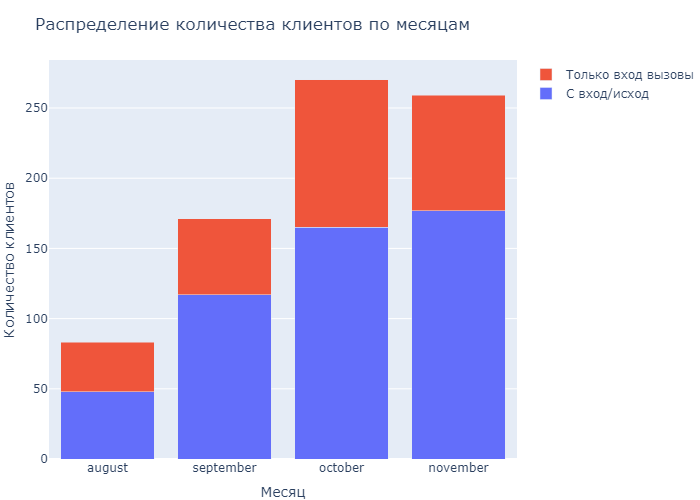

In [63]:
# Создадим таблицу с количеством клиентов указаннм категориям и месяцам
df_count_clients = (
    pd.DataFrame
    (
        {'month': ['august', 'september', 'october', 'november'],
         'clients_in_call': [df_aug.user_id.nunique() - df_aug[df_aug.direction == 'out']['user_id'].nunique(),
                           df_sep.user_id.nunique() - df_sep[df_sep.direction == 'out']['user_id'].nunique(),
                           df_oct.user_id.nunique() - df_oct[df_oct.direction == 'out']['user_id'].nunique(),
                           df_nov.user_id.nunique() - df_nov[df_nov.direction == 'out']['user_id'].nunique()],
         
         'clients_out_call' : [df_aug[df_aug.direction == 'out']['user_id'].nunique(),
                               df_sep[df_sep.direction == 'out']['user_id'].nunique(),
                               df_oct[df_oct.direction == 'out']['user_id'].nunique(),
                               df_nov[df_nov.direction == 'out']['user_id'].nunique()]
        }
    )
)

display(df_count_clients)

# Представим данные по количеству клиентов по месяцам в разбивке по типам вызовов (1. Все; 2. Только исходящие)
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x = df_count_clients.month,
        y = df_count_clients.clients_out_call,
        name = 'С вход/исход')
            )

fig.add_trace(
    go.Bar(
        x = df_count_clients.month,
        y = df_count_clients.clients_in_call,
        name = 'Только вход вызовы')
            )

fig.update_layout(
    barmode='stack', 
    title="Распределение количества клиентов по месяцам",
    yaxis_title='Количество клиентов',
    xaxis_title="Месяц",
    margin=dict(l=0, r=0, t=60, b=0),
    yaxis={'categoryorder':'total ascending'}
)
                         
fig.show()

Как видим самый "активный" (наибольшее число клиентов) месяц - октябрь (272 клиента). Далее по убыванию: ноябрь (261 клиент), сентябрь (172 клиента), и почти с двукратным отставанием август (84 клиента). 

Наибольшая доля клиентов только с исходящими звонками в августе - около 42% от числа всех клиентов, пользующихся услугами компании в этом месяце. Наименьшая  - около 31% в ноябре и сентябре.

#### Общее количество звонков по месяцам

Найдем и визуализируем общее количество звонков, совершенных операторами в каждом месяце (сделаем разбивку по типу вызова)

In [64]:
# Вводим пустые датафреймы, чтобы использовать их в цикле
call_aug = pd.DataFrame()
call_sep = pd.DataFrame()
call_oct = pd.DataFrame()
call_nov = pd.DataFrame()

call_list = [call_aug, call_sep, call_oct, call_nov]
res_list_call = []

# Создаем датафреймы по категориям звонков, 
# с агрегированными значениями calls_count и total_call_duration по месяцам
for call,i in zip(call_list, range(4)):
    call =  (
        df_full_list[i].groupby(['direction', 'internal'], as_index=False)
        .agg({'calls_count':'sum',
              'total_call_duration':'sum'})
    )
    res_list_call.append(call)

# Заменяем маркеры вход/исх и внутр/внеш вызовов для удобства воприятия на визуализации
for i in range(4):
    res_list_call[i].loc[res_list_call[i].internal == False, 'internal'] = 'external_call'
    res_list_call[i].loc[res_list_call[i].internal == True, 'internal'] = 'internal_call'

    res_list_call[i].loc[res_list_call[i].direction == 'in', 'direction'] = 'direction_in'
    res_list_call[i].loc[res_list_call[i].direction == 'out', 'direction'] = 'direction_out'

    res_list_call[i]['dir/int'] = res_list_call[i]['direction'] +' & '+ res_list_call[i]['internal'] 

    res_list_call[i] = res_list_call[i][['calls_count', 'total_call_duration', 'dir/int']]
    display(res_list_call[i])

,calls_count,total_call_duration,dir/int
0,3131,214939,direction_in & external_call
1,90,1965,direction_in & internal_call
2,11598,988482,direction_out & external_call
3,161,4132,direction_out & internal_call


,calls_count,total_call_duration,dir/int
0,19193,1344950,direction_in & external_call
1,313,9588,direction_in & internal_call
2,60589,5093107,direction_out & external_call
3,2095,83779,direction_out & internal_call


,calls_count,total_call_duration,dir/int
0,71875,3769107,direction_in & external_call
1,376,10849,direction_in & internal_call
2,173353,11734282,direction_out & external_call
3,4129,177442,direction_out & internal_call


,calls_count,total_call_duration,dir/int
0,77319,5300190,direction_in & external_call
1,668,46255,direction_in & internal_call
2,195234,13215313,direction_out & external_call
3,6432,363881,direction_out & internal_call


Готово.

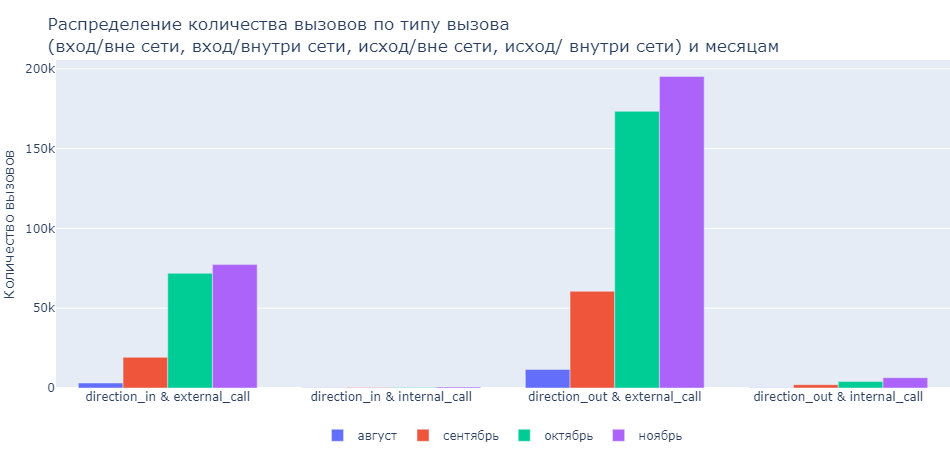

In [65]:
# Представим данные по количеству клиентов по месяцам в разбивке по типам вызовов
fig = go.Figure()

list_month = ['август', 'сентябрь', 'октябрь', 'ноябрь']
for i, month in zip(range(4), list_month):
    fig.add_trace(
        go.Bar(
            x = res_list_call[i]['dir/int'],
            y = res_list_call[i]['calls_count'],
            name = month)
            )


fig.update_layout(
    autosize=False,
    width=950,
    height=450,
    title="Распределение количества вызовов по типу вызова <br>(вход/вне сети, вход/внутри сети, исход/вне сети, исход/ внутри сети) и месяцам",
    yaxis_title='Количество вызовов',
    #xaxis_title="Тип вызова",
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"),
    margin=dict(l=0, r=0, t=60, b=0),
    yaxis={'categoryorder':'total ascending'}
)
                         
fig.show()

На гистограмме видим:
* Количество вызовов в месяц растет от сентября к ноябрю.
* Внутренних вызовов в каждом месяце на порядки меньше внешних.
* Рост количества вызовов с сентября по октябрь более чем двукратный.
* Абсолютный лидер по количеству совершенных вызовов - ноябрь.

#### Общая продолжительность вызовов по месяцам

Посмотрим теперь общее время звонков, которые совершили клиенты по месяцам. Определим самый "разговорный" месяц.

Есть. Получили 4 таблицы с общим количеством звонков и их продолжительностью по категориям вызовов.

Построим соответствующую визуализацию.

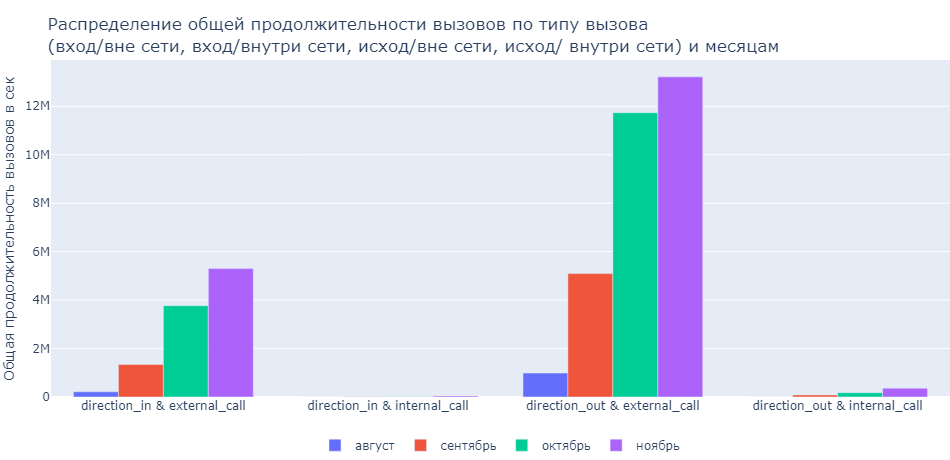

In [66]:
# Представим данные по количеству клиентов по месяцам в разбивке по типам вызовов (1. Все; 2. Только исходящие)
fig = go.Figure()

list_month = ['август', 'сентябрь', 'октябрь', 'ноябрь']
for i, month in zip(range(4), list_month):
    fig.add_trace(
        go.Bar(
            x = res_list_call[i]['dir/int'],
            y = res_list_call[i]['total_call_duration'],
            name = month)
            )


fig.update_layout(
    autosize=False,
    width=950,
    height=460,
    title="Распределение общей продолжительности вызовов по типу вызова <br>(вход/вне сети, вход/внутри сети, исход/вне сети, исход/ внутри сети) и месяцам",
    yaxis_title='Общая продолжительность вызовов в сек',
    #xaxis_title="Тип вызова",
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"),
    margin=dict(l=0, r=0, t=60, b=0),
    yaxis={'categoryorder':'total ascending'}
)
                         
fig.show()

На гистограмме видим:
* Ноябрь - уверенный лидер по всем типам звонков, самый "разговорный" месяц
* Август - абсолютный аутсайдер
* На втором месте октябрь, на третьем сентябрь.
* Входящих вызовов намного (до 4 раз) меньше исходящих
* Наибольшее число вызовов (вне зависимости от месяца) - внешние исходящие вызовы
* Наименьшее число - внутренние входящие
* Самый большой "скачек" в общей продолжительности внутренних и внешних звонков произошел с августа на сентябрь (в 4 и в 5 раз соответственно) 

#### Количество операторов у клиентов только с входящими вызовами

Теперь отдельно посмотрим на показатели клиентов у которых в данном месяце были только входящие вызовы

In [67]:
# Пустые списки для клиентов с исх вызовами по месяцам
list_out_user_aug = []
list_out_user_sep = []
list_out_user_oct = []
list_out_user_nov = []

list_list = [list_out_user_aug, list_out_user_sep, list_out_user_oct, list_out_user_nov]
lst_out = []

# Собираем в список клиентов с исходящими вызовами
for i, name_list in zip(range(4), list_list):
    name_list = df_full_list[i][df_full_list[i].direction == 'out']['user_id'].unique().tolist()
    lst_out.append(name_list)

# Фильтруем клиентов, оставляя только с входящими вызовами
for i in range(4):
    globals()['in_user_' + str(i)] = df_full_list[i].drop(np.where(df_full_list[i]['user_id'].isin(lst_out[i]))[0])

# Создаем список клиентов, у которых только исходящие вызовы
for i in range(4):
    globals()['in_us_lst_' + str(i)] =  globals()['in_user_' + str(i)]['user_id'].unique().tolist()

Готово. Список клиентов, у которых были только входящие вызовы (они по тарифной сетке бесплатные) получили. 

Посмотрим на количество операторов этих клиентов по месяцам, а также на минимальное, среднее и максимальные значения количества звонков и их продолжительности (с учетом времени ожидания)

In [68]:
m_list = ['aug', 'sep', 'oct', 'nov']

# создаем 4 таблицы по месяцам 
# с агрегированными значениями calls_count, total_call_duration и operator_id 
# для клиентов, у которых только входящие звонки
for i, month in zip(range(4), m_list):
    
    globals()['in_user_' + month] = (
        
    globals()['df_' + month]
        [
        globals()['df_' + month].user_id.isin(globals()['in_us_lst_' + str(i)])
        ]
            .groupby('user_id', as_index=False)
            .agg({'calls_count' : 'sum',
                  'total_call_duration': 'sum',
                  'operator_id':'nunique'})
            .sort_values(by=['operator_id'])
)

pd.options.display.float_format ='{:,.0f}'.format

for m in m_list:
    
    display(globals()['in_user_' + m].sort_values(by='operator_id', ascending=False).head(3))
    display(globals()['in_user_' + m][['calls_count', 'total_call_duration', 'operator_id']]
            .describe().loc[['min', 'mean', 'max']])

,user_id,calls_count,total_call_duration,operator_id
30,166975,10,552,3
24,166896,171,711,3
0,166392,31,277,2


,calls_count,total_call_duration,operator_id
min,1,2,0
mean,16,286,1
max,171,"2,736",3


,user_id,calls_count,total_call_duration,operator_id
21,167059,189,23815,7
39,167497,7,364,5
14,166837,70,2248,4


,calls_count,total_call_duration,operator_id
min,1,2,0
mean,24,"1,573",1
max,189,"23,815",7


,user_id,calls_count,total_call_duration,operator_id
19,166837,147,3545,7
31,167059,206,27224,5
27,166975,23,3574,4


,calls_count,total_call_duration,operator_id
min,1,0,0
mean,26,"1,825",1
max,206,"27,224",7


,user_id,calls_count,total_call_duration,operator_id
21,167059,301,40326,5
50,167976,54,9537,4
19,166975,18,1946,3


,calls_count,total_call_duration,operator_id
min,1,1,0
mean,52,"4,220",1
max,744,"112,726",5


Как видим число операторов таких пользователей не превосходит 7, а среднее количество звонков в месяц с августа по ноябрь 16 - 54 (16 в августе и 54 в октябре) со средней продолжительностью вызовов 286 - 4220 сек. 

Так как количество звонков и их продолжительность не влияют на расходы клиента (речь о входящих звонках), то визуализируем только количество операторов таких клиентов по месяцам.

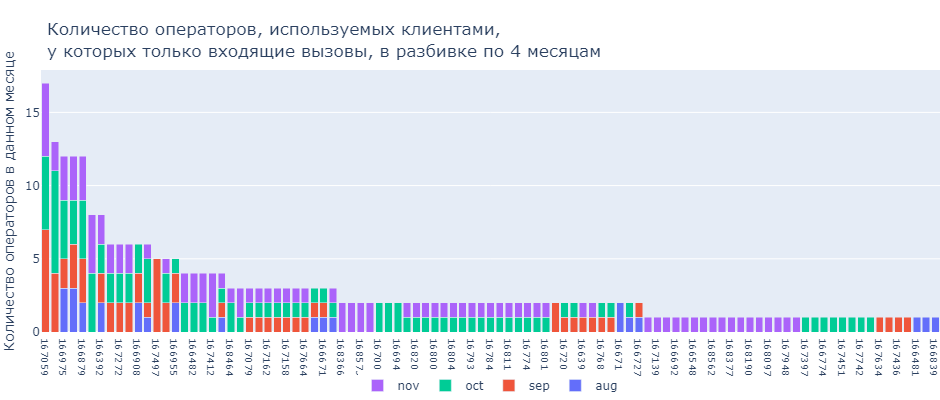

In [69]:
# user_id к object и  уберем клиентов без операторов
for m in m_list:
    
    globals()['in_user_' + m]['user_id'] = globals()['in_user_' + m]['user_id'].apply(lambda x : str(x))
    globals()['in_user_' + m] = globals()['in_user_' + m].query('operator_id != 0')
    

fig=go.Figure()

for m in m_list:
    fig.add_trace(go.Bar(
        x=globals()['in_user_'+m]['user_id'],
        y=globals()['in_user_'+m]['operator_id'],
       # mode='markers',
        name=m))

fig.update_layout(
                  barmode='stack',
                  autosize=False,
                  width=940,
                  height=400,
                  title="Количество операторов, используемых клиентами, <br>у которых только входящие вызовы, в разбивке по 4 месяцам",
                  yaxis_title='Количество операторов в данном месяце',
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center", y=-.15),
                  margin=dict(l=0, r=0, t=70, b=0))

fig.update_xaxes(#tickangle=45,
                tickfont=dict(size=10))

fig.show()

Заметим что, большое количество клиентов с нулевым количеством операторов (в октябре их больше чем в остальные месяцы) мы не выводим.

На графике видим:

* Большая часть клиентов пользовалась услугами компании используя только одного оператора в месяц.
* Наибольшее число операторов у клиентов в ноябре, октябре, меньше всего в сентябре

В целом расходы таких клиентов будут невелики, из-за бесплатности входящих и их малой активности.

#### Количество операторов у клиентов  с вход/исход вызовами

Рассмотрим клиентов, у которых были и исходящие вызовы, помимо входящих.

In [70]:
# создаем таблицы по месяцам с информацией о клиентах, у которых были исходящие вызовы
for m in m_list:
    
    globals()['out_users_' + m] = globals()['df_' + m][globals()['df_' + m].direction == 'out']['user_id'].unique()
    globals()['out_users_' + m] = globals()['out_users_' + m].tolist ()
    globals()['df_out_users_' + m] = globals()['df_' + m][globals()['df_' + m]['user_id'].isin(globals()['out_users_' + m])]
    
    # Заранее подумаем о списке активных, 
    # нам не нужны минуты разговоров входящих звонков и внутренних
    # создадим для этого отдельную таблицу, которая пригодится позже!
    globals()['only_out_users_' + m] = (
    globals()['df_out_users_' + m]\
        [(globals()['df_out_users_' + m]['direction'] == 'out')
        &(globals()['df_out_users_' + m]['internal'] == False)].groupby('user_id')
        .agg({'total_call_duration':'sum'})
        .reset_index()
    )
    
    globals()['ou_users_' + m] = (
    globals()['df_out_users_' + m].groupby('user_id')
    .agg(
        {'calls_count':'sum',
         'operator_id': 'nunique',
         'date':'nunique'})
    .reset_index()
    )
    
    globals()['o_a_users_'+m] = globals()['ou_users_' + m].merge(globals()['only_out_users_' + m], on='user_id', how='inner')
    
    globals()['df_out_users_' + m] = (
    globals()['df_out_users_' + m].groupby('user_id')
    .agg(
        {'total_call_duration':'sum',
         'calls_count':'sum',
         'operator_id': 'nunique',
         'date':'nunique'})
    .reset_index()
    )
    
    

Выведем первые три строки каждой таблицы

In [71]:
for m in m_list:
    print('Месяц:', m)
    display(globals()['df_out_users_' + m].sort_values(by=['operator_id'], ascending=False).head(3))

Месяц: aug


,user_id,total_call_duration,calls_count,operator_id,date
16,166658,385596,2154,15,17
10,166520,50892,983,8,17
37,166901,3049,140,7,7


Месяц: sep


,user_id,total_call_duration,calls_count,operator_id,date
111,167626,1322567,22184,44,7
81,167176,35637,574,15,18
16,166658,788016,3630,15,28


Месяц: oct


,user_id,total_call_duration,calls_count,operator_id,date
103,167626,3329438,71222,48,20
155,168187,468444,6637,37,16
93,167497,110039,1295,29,31


Месяц: nov


,user_id,total_call_duration,calls_count,operator_id,date
155,168187,1107275,14761,46,28
144,168062,1070122,25332,27,22
167,168361,4373184,65353,25,28


Естественно совсем другая картина. И по количеству операторов, времени звонков и по количеству звонков - значения выше на порядок. 

Значит, при поиске активных клиентов, будем рассматривать тех, у кого помимо входящих, обязательно есть исходящие звонки.  

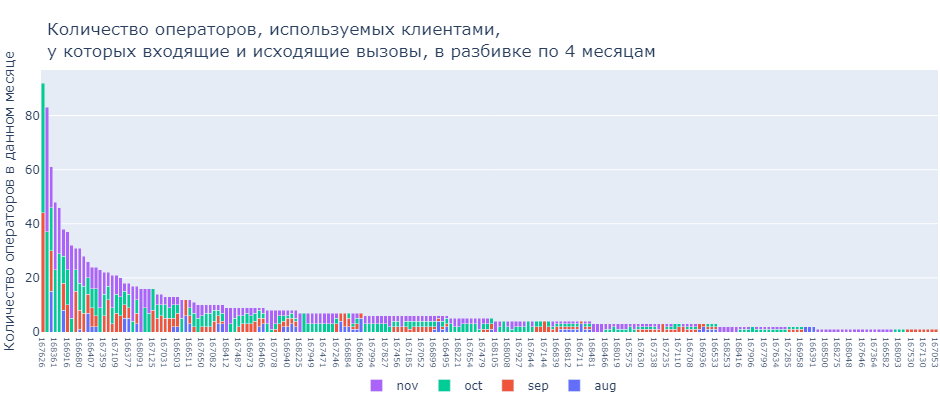

In [72]:
# оставим только тех клиентов, у которых больше 3 операторов за все время (можно разные срезы рассмотреть)
us_op = data.groupby('user_id', as_index=False)['operator_id'].nunique()
#us_op = us_op[us_op.operator_id > 3]
us_op['user_id'] = us_op['user_id'].apply(lambda x: str(x)) 
us_op = us_op['user_id'].to_list()

for m in m_list:
    globals()['df_out_users_' + m]['user_id'] = globals()['df_out_users_' + m]['user_id'].apply(lambda x : str(x))
    
# Построим гистограммы количества операторов клиентов по месяцам
fig=go.Figure()

for m in m_list:
    fig.add_trace(go.Bar(
        x=globals()['df_out_users_' + m][globals()['df_out_users_' + m].user_id.isin(us_op)]['user_id'],
        y=globals()['df_out_users_' + m][globals()['df_out_users_' + m].user_id.isin(us_op)]['operator_id'],
        #orientation='h',
        name=m))


fig.update_layout(
                  barmode='stack',
                  autosize=False,
                  width=940,
                  height=400,
                  title="Количество операторов, используемых клиентами, <br>у которых входящие и исходящие вызовы, в разбивке по 4 месяцам",
                  yaxis_title='Количество операторов в данном месяце',
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center", y=-.15),
                  margin=dict(l=0, r=0, t=70, b=0))

fig.update_xaxes(#tickangle=45,
                tickfont=dict(size=8))

fig.show()

На гистограмме видим:
* Больше половины клиентов имеют суммарное число операторов менее 10.
* В сентябре только единожды число операторов клиента перевалило за 8, чаще их от 2-5. 
* Наибольшее число операторов у клиентов в октябре и ноябре.
* Только два клиента, у которых хотя бы в одном месяце число операторов больше 40
* Только один клиент, у которого число операторов в каждом из 4 месяцев не менее 15 и один - не менее 8.

#### Общее и среднее количество звонков в день клиента

Количество вызовов конечно может являться одним из парамтров активности клиента, но так как клиент платит только за время вызова, а не за их количество, то мы рассмотрим средние значения количества звонков в месяц у клиентов, причем у тех из них, у кого были вход/исход вызовы.

Рассмотрим как общее количество звонков, так и относительные показатели (в день и на одного оператора).

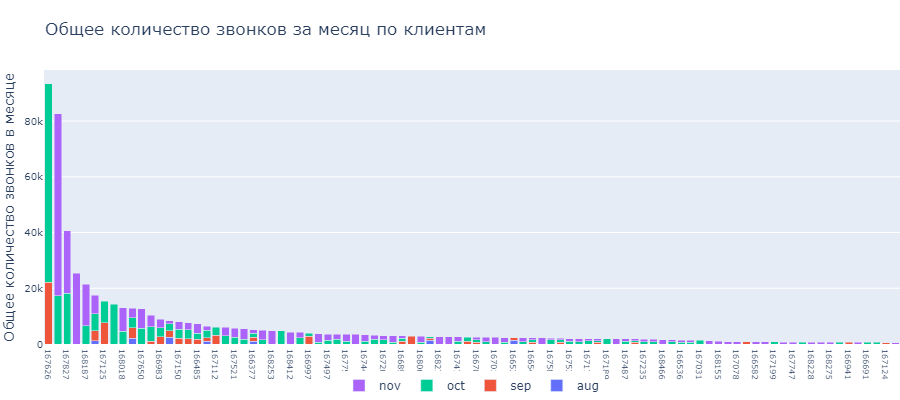

In [73]:
# Общее число звонков у клиента за весь месяц
for m in m_list:
    globals()['df_call_'+m] = (
    globals()['df_'+m][globals()['df_'+m]['user_id'].isin(globals()['out_users_'+m])]
    .groupby(['user_id'], as_index=False)['calls_count']
    .sum().rename(columns={'calls_count':'calls_total'})
)

# ограничим диапазон снизу числом 500 
for m in m_list:
    globals()['df_c_'+m] = globals()['df_call_'+m].query('calls_total >= 500')

fig=go.Figure()

for m in m_list:
    fig.add_trace(go.Bar(
    x = globals()['df_c_'+m]['user_id'].apply(lambda x: str(x)),
    y = globals()['df_c_'+m]['calls_total'],
    #mode = 'markers',
    name = m,
    #marker=dict(size=6, opacity=0.7)
    ))
    

fig.update_layout(barmode='stack',
                  autosize=False,
                  width=900,
                  height=400,
                  title="Общее количество звонков за месяц по клиентам",
                  yaxis_title='Общее количество звонков в месяце',
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=70, b=0))
fig.update_xaxes(#tickangle=45,
                tickfont=dict(size=8))
fig.update_yaxes(#tickangle=45,
                tickfont=dict(size=10))

fig.show()

Даже несмотря на то, что мы вывели не все данные, а срез (не менее 500 звонков в месяц), видим, что есть 5-6 очень больших, на порядок превосходящий остальные, значений (в сравнении с более чем с 85% всех) и около 30-40 значений в десятки раз превосходящих остальные. Однако заметим, что снова доминирующий цвет - фиолетовый, месяц - ноябрь, на втором месте - октябрь. Также заметны отдельные значения в сентябре. Август практически неразличим.

По самым скромным подсчетам один оператор в день за 12 часовую смену может спокойно делать 200 вызовов, это еще и с перерывом на обед, за 14 дней месяца итого около 2800 вызовов. Мы видим, что менее четверти клиентов имеют такое количество звонков в месяц.

Выведем статистику по месяцам и посмотрим соответствующие процентили; какая же часть клиентов перешагивает этот порог.

In [74]:
for m in m_list:
    print('Месяц:', m)
    display(globals()['df_call_'+m]['calls_total'].describe().loc[['min','50%', 'mean','max']])


print('Не более чем',\
      100 - 96, '% клиентов имеют более',\
      int(np.percentile(df_call_sep['calls_total'], [96])), 'звонков в сентябре')
print('Не более чем',\
      100 - 90, '% клиентов имеют более',\
      int(np.percentile(df_call_oct['calls_total'], [90])), 'звонков в октябре')
print('Не более чем',\
      100 - 89, '% клиентов имеют более',\
      int(np.percentile(df_call_nov['calls_total'], [89])), 'звонков в ноябре')

Месяц: aug


min        1
50%       70
mean     301
max    2,480
Name: calls_total, dtype: float64

Месяц: sep


min         4
50%       154
mean      692
max    22,184
Name: calls_total, dtype: float64

Месяц: oct


min         6
50%       211
mean    1,497
max    71,222
Name: calls_total, dtype: float64

Месяц: nov


min         1
50%       303
mean    1,556
max    65,353
Name: calls_total, dtype: float64

Не более чем 4 % клиентов имеют более 2935 звонков в сентябре
Не более чем 10 % клиентов имеют более 2846 звонков в октябре
Не более чем 11 % клиентов имеют более 2626 звонков в ноябре


С таким порогом нам просто некого будет исследовать!

Теперь посмотрим на количество звонков в день.

In [75]:
df_out_users_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              48 non-null     object
 1   total_call_duration  48 non-null     int64 
 2   calls_count          48 non-null     int64 
 3   operator_id          48 non-null     int64 
 4   date                 48 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.0+ KB


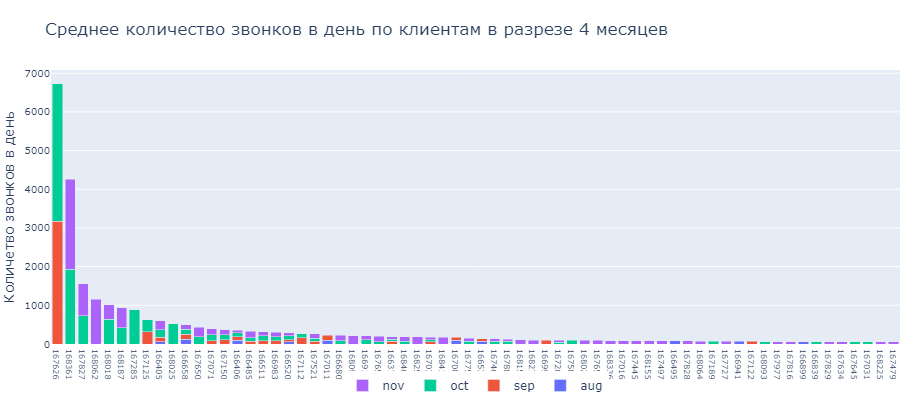

In [76]:
for m in m_list:
    globals()['df_call_'+m]['calls_count/days'] = (
        globals()['df_out_users_'+m]['calls_count']/globals()['df_out_users_'+m]['date']
    )
for m in m_list:
    globals()['df_c_'+m] = globals()['df_call_'+m][globals()['df_call_'+m]['calls_count/days'] >= 50]
    
fig=go.Figure()

for m in m_list:
    fig.add_trace(go.Bar(
    x = globals()['df_c_'+m]['user_id'].apply(lambda x: str(x)),
    y = globals()['df_c_'+m]['calls_count/days'].apply(lambda x: int(x)),
    #mode = 'markers',
    name = m,
    #marker=dict(size=6, opacity=0.7)
    ))
    

fig.update_layout(barmode='stack',
                  autosize=False,
                  width=900,
                  height=400,
                  title="Среднее количество звонков в день по клиентам в разрезе 4 месяцев",
                  yaxis_title='Количетво звонков в день',
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=70, b=0))
fig.update_xaxes(#tickangle=45,
                tickfont=dict(size=8))
fig.update_yaxes(#tickangle=45,
                tickfont=dict(size=10))

fig.show()

Как видим, не более 20 клиентов имеют в среднем более 200 звонков в день. Ноябрь и октябрь на лид позициях. Август почти пропал окончательно. Посмотрим на наименьшие, наибольшие, медианы и средние значения числа звонков в день по месяцам. 

In [77]:
for m in m_list:
    print('Месяц', m)
    print(globals()['df_call_'+m]['calls_count/days'].describe().loc[['min', '50%', 'mean', 'max']])
    print()

Месяц aug
min      1
50%     11
mean    26
max    127
Name: calls_count/days, dtype: float64

Месяц sep
min        1
50%       12
mean      55
max    3,169
Name: calls_count/days, dtype: float64

Месяц oct
min        1
50%       13
mean      81
max    3,561
Name: calls_count/days, dtype: float64

Месяц nov
min        1
50%       16
mean      64
max    2,334
Name: calls_count/days, dtype: float64



Как видим в августе такой максимум всего 127 (около 10 звонков в час). В сентябре, октябре и ноябре дела обстоят лучше. Кстати в ноябре среднее значение меньше октябрьского (69 против 83), максимальное аналогично (2334 против 3561). Т.е. не считая среднего, в октябре лучшие показатели по среднему количеству звонков в день. Скорее связано с наличием нескольких отдельных больших значений (о чем и говорят график, средние и медианы) этих месяцев.

In [78]:
print('Не более чем',\
      round(100 - 98.6, 1), '% клиентов имеют более',\
      int(np.percentile(df_call_sep['calls_count/days'], [98.6])), 'звонков в сентябре')
print('Не более чем',\
      100 - 95, '% клиентов имеют более',\
      int(np.percentile(df_call_oct['calls_count/days'], [95])), 'звонков в октябре')
print('Не более чем',\
      100 - 95.5, '% клиентов имеют более',\
      int(np.percentile(df_call_nov['calls_count/days'], [95.5])), 'звонков в ноябре')

Не более чем 1.4 % клиентов имеют более 216 звонков в сентябре
Не более чем 5 % клиентов имеют более 196 звонков в октябре
Не более чем 4.5 % клиентов имеют более 185 звонков в ноябре


Аналогично предыдущему пункту и даже почти в два раза меньше доля тех клиентов, у кого в день в среднем 200 звонков.

#### Средняя продолжительность вызовов клиентов по месяцам

 В таблице `df_out_users_"месяц"` мы уже собрали агрегированные значения продолжительности вызовов клиентов с вход/исход звонками. Рассмотрим эти значения подробнее.

In [79]:
for m in m_list:
    globals()['df_duration_'+m] = globals()['df_out_users_'+m][['user_id', 'total_call_duration', 'date']]
    print('Месяц', m)
    print(globals()['df_duration_'+m]['total_call_duration'].describe().loc[['min', '50%', 'mean', '75%', 'max']])
    print()

Месяц aug
min         13
50%      3,145
mean    24,990
75%     16,436
max    385,596
Name: total_call_duration, dtype: float64

Месяц sep
min           50
50%        9,309
mean      55,113
75%       32,126
max    1,322,567
Name: total_call_duration, dtype: float64

Месяц oct
min            4
50%       17,081
mean      93,957
75%       65,279
max    3,329,438
Name: total_call_duration, dtype: float64

Месяц nov
min            1
50%       23,779
mean     104,994
75%       77,071
max    4,373,184
Name: total_call_duration, dtype: float64



При 12 часовом рабочем дне и 10 рабочих днях в месяце значение `total_call_duration` будет близко к432000. Посмотрим какая доля клиентов в каждом месяце близка к этому показателю (в августе таких нет, так как максимум там 385596).

In [80]:
print('Не более чем',\
      100 - 97.5, '% клиентов имеют более',\
      int(np.percentile(df_duration_sep['total_call_duration'], [97.5])), 'продолжительности звонков в сентябре')
print('Не более чем',\
      100 - 96, '% клиентов имеют более',\
      int(np.percentile(df_duration_oct['total_call_duration'], [96])), 'продолжительности звонков в октябре')
print('Не более чем',\
      100 - 95.5, '% клиентов имеют более',\
      int(np.percentile(df_duration_nov['total_call_duration'], [95.5])), 'продолжительности звонков в ноябре')

Не более чем 2.5 % клиентов имеют более 408424 продолжительности звонков в сентябре
Не более чем 4 % клиентов имеют более 434346 продолжительности звонков в октябре
Не более чем 4.5 % клиентов имеют более 360963 продолжительности звонков в ноябре


Столь небольшие доли можно объяснить лишь превалирующим числом дней с низкой общей продолжительностью звонков. Возможно есть смысл снизить параметры рабочего дня и количества рабочих дней в месяце.

Последний параметр - средняя продолжительность звонков у клиента в день по месяцам.

In [81]:
for m in m_list:
    globals()['df_duration_'+m] = globals()['df_duration_'+m].copy()
    globals()['df_duration_'+m]['duration/day'] = globals()['df_duration_'+m]['total_call_duration'] / globals()['df_duration_'+m]['date']
    globals()['df_duration_'+m]['duration/day'] = globals()['df_duration_'+m]['duration/day'].astype('int')
 


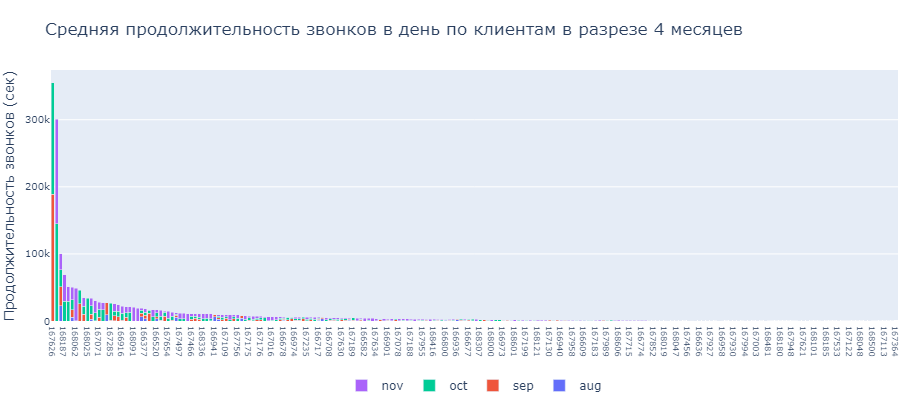

In [82]:
fig=go.Figure()

for m in m_list:
    fig.add_trace(go.Bar(
    x = globals()['df_duration_'+m]['user_id'].apply(lambda x: str(x)),
    y = globals()['df_duration_'+m]['duration/day'].apply(lambda x: int(x)),
    #mode = 'markers',
    name = m,
    #marker=dict(size=6, opacity=0.7)
    ))
    

fig.update_layout(barmode='stack',
                  autosize=False,
                  width=900,
                  height=400,
                  title="Средняя продолжительность звонков в день по клиентам в разрезе 4 месяцев",
                  yaxis_title='Продолжительность звонков (сек)',
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center", y=-.2),
                  margin=dict(l=0, r=0, t=70, b=0))
fig.update_xaxes(#tickangle=45,
                #dtick=100,
                tickfont=dict(size=8))
fig.update_yaxes(#tickangle=45,
                tickfont=dict(size=10))

fig.show()

Аналогичная картина тем, что мы видели с количеством звонков и средним количеством звонков в день. Правда здесь куда более заметен октябрь, и даже встречаются отдельные на порядок превосходящие остальные, значения. 

Подробнее рассмотрим среднее, медиану, 75 процентиль и максимальные значения средней продолжительности звонков в день по месяцам.

In [83]:
for m in m_list:
    print('Месяц', m)
    print(globals()['df_duration_'+m]['duration/day'].describe().loc[['std', 'min', '50%', 'mean', '75%', 'max']])
    print()

Месяц aug
std     3,739
min        13
50%       474
mean    1,893
75%     2,001
max    22,682
Name: duration/day, dtype: float64

Месяц sep
std     17,773
min         15
50%        842
mean     3,801
75%      2,152
max    188,938
Name: duration/day, dtype: float64

Месяц oct
std     17,723
min          2
50%        980
mean     4,863
75%      2,975
max    166,471
Name: duration/day, dtype: float64

Месяц nov
std     13,051
min          1
50%      1,225
mean     4,260
75%      3,556
max    156,185
Name: duration/day, dtype: float64



При 12 часов рабочем дне (предположим 2 часа на перерыв) продолжительность звонков может составлять до 36000 сек. Посмотрим на доли таких клиентов в указанных месяцах. Август снова "в пролете" (максимальное значение 22682)

In [84]:
print('Не более чем',\
      round(100 - 99.2, 1), '% клиентов имеют более',\
      int(np.percentile(df_duration_sep['duration/day'], [99.2])), 'продолжительности звонков в день в сентябре')
print('Не более чем',\
      round(100 - 98.8, 1), '% клиентов имеют более',\
      int(np.percentile(df_duration_oct['duration/day'], [98.8])), 'продолжительности звонков в день в октябре')
print('Не более чем',\
      round(100 - 98.2, 1), '% клиентов имеют более',\
      int(np.percentile(df_duration_nov['duration/day'], [98.2])), 'продолжительности звонков в день в ноябре')

Не более чем 0.8 % клиентов имеют более 39720 продолжительности звонков в день в сентябре
Не более чем 1.2 % клиентов имеют более 37556 продолжительности звонков в день в октябре
Не более чем 1.8 % клиентов имеют более 23751 продолжительности звонков в день в ноябре


От критерия к критерию доли все меньше и меньше. И везде медиана в 3-4 раза меньше среднего, следовательно значения распределены с положительной асимметрией, причем с ярко выраженной. И значение стандартного отклонения тоже велико, значит разброс данных большой (много небольших значений и есть отдельные на порядок их превосходящие).

Дополнительно узнаем, кто из клиентов преодолел рубеж в 2000 бесплатных минут (120000 сек.) на исходящие звонки внутри сети.

In [85]:
for m in m_list:
    globals()['int_lim_'+m] = (
    globals()['df_'+m].query('(internal == True) & (direction == "out")')
    .groupby('user_id', as_index=False)['total_call_duration']
    .sum()
)

In [86]:
for m in m_list:
    print('Месяц', m)
    print(globals()['int_lim_'+m]['total_call_duration'].describe().loc[['mean', '50%', 'max']])
    print()

Месяц aug
mean     180
50%        7
max    1,566
Name: total_call_duration, dtype: float64

Месяц sep
mean    1,470
50%        52
max    16,260
Name: total_call_duration, dtype: float64

Месяц oct
mean    1,888
50%        46
max    24,055
Name: total_call_duration, dtype: float64

Месяц nov
mean    3,913
50%        53
max    83,569
Name: total_call_duration, dtype: float64



Вот так! Никто. Если конечно в документации к данных нет ошибки и там 2000 сек и не минут.


**ВЫВОДЫ**

Итак, мы рассмотрели динамику использования услуг компании клиентами. Выяснили:

* Наибольшая активность клиентов приходится на октябрь и ноябрь.
* Наименьшие показатели по всем параметрам в августе.
* Клиентов, которые были бы стабильно активны все 4 месяца порядка 10.
* В основном клиенты пользуются услугами компании 2-3 месяца.
* Самый разговорный месяц - ноябрь, на порядок превосходящий август и в разы сентябрь.
* В сентябре общая продолжительность вызовов по всем клиентам наименьшая (как и самих клиентов)
* Наибольшая доля клиентов только с исходящими звонками в августе - около 42% от числа всех клиентов, пользующихся услугами компании в этом месяце. Наименьшая - около 31% в ноябре и сентябре. 
* Количество клиентов с вход/исход от августа к ноябрю растет, клиентов только с вход вызовами - растет до октября и падает в ноябре.

Рассмотрели такие критерии активности клиента как количество операторов, общее (за месяц) и среднее (в день по месяцам) количество звонков, среднюю продолжительность звонков в день по месяцам. 
* Наибольшее число операторов у клиентов (с вход/исход вызовами)в ноябре и октябре, есть единицы клиентов с количеством операторов больше 40.
* У клиентов только с входящими вызовами эти показатели в разы меньше (там максимум 7)
* Всего не более чем 11%, 10%, 4% клиентов имеют более 2800 звонков в месяц. Причем в ноябре снова наибольшее число клиентов с количеством звонков более 2800
* Не более 5% в октябре и ноябре и не более 1% в сентябре имеют 200 и более звонков в день. 
* Общая продолжительность вызовов по каждому клиенту тоже росла от месяца к месяцу.
* Максимум августа 385596, а ноября уже 4,373,184! Среднее значение по прежнему больше медианы, что означает наличие отдельных больших значений, и большого числа клиентов с низким показателем общей продолжительности звонков за месяц.
* Распределение средних продолжительностей звонков в день клиентов также имеет положительную асимметрию.
* Чуть более стал заметен сентябрь на графике средней продолжительности звонков клиентов по дням, но в лидерах по прежнему октябрь и ноябрь.


#### Список активных клиентов

Из выше перечисленного можно сделать вывод, что целесообразно считать активным в данном месяце клиента:
1. Имеет входящие и исходящие вызовы.
3. От 1400 звонков в месяц
4. Общую продолжительность звонков в месяц более чем 100000 сек.
5. Продолжительность звонка в день не менее 3600
6. Имеет от 10 рабочих дней в месяце.

Заметим, что:
1. Порог активности, на самом деле, может быть любым. Даже просто наличие информации о клиенте из таблицы `clients` в таблице `data` уже может говорить о том, что это не "мертвый" клиент, что какое-то взаимодействие с компанией идет, какими-то услугами пользуется и т.д. А можно считать всех клиентов с исходящими звонками активными. И далее устанавливать все возможные пороги, на которые влияет длительность раб дня, производительность операторов, количество рабочих дней в месяце, а может быть, растущие показатели от месяца к месяцу. 
2. Определяющим для целей исследования безусловно должен быть последний месяц. Ведь какой смысл предлагать смену тарифа пользователю, который когда-то был активен, но последний (перед предложением) месяц "сбавил обороты" или вовсе отказался от услуг (решение вопроса о причинах отказа сейчас не выясняем). Поэтому одним из определяющих факторов будет безусловно активность в последний месяц (ноябрь) перед исследованием.


In [89]:
# Отберем из таблиц df_aug, df_sep, df_oct, df_nov строки по указанным выше параметрам
res_list = []
for m in m_list:
    globals()[m + '_list_users'] = (globals()['o_a_users_'+m]\
    [(globals()['o_a_users_'+m]['calls_count'] > 1400)\
         & (globals()['o_a_users_'+m]['total_call_duration'] > 100000)\
         & (globals()['o_a_users_'+m]['date'] > 10)
         & (globals()['o_a_users_'+m]['total_call_duration']/globals()['o_a_users_'+m]['date'] > 3600)   
         
        ]['user_id']
        .to_list()
    )
    globals()['res_list_'+m] = []
    globals()['res_list_'+m].append(globals()[m + '_list_users'])


In [90]:
# Превратим список списков в список элементов
for m in m_list:
    globals()['res_list_'+m] = list(chain.from_iterable(globals()['res_list_'+m]))
    globals()['activ_list_'+m] = list(set(globals()['res_list_'+m]))
    globals()['activ_list_'+m] = list(map(int, globals()['activ_list_'+m]))
    print(globals()['activ_list_'+m])

# Количетсво активных клиентов
total_act = []
for m in m_list:
    total_act.append(globals()['activ_list_'+m])

total_act = list(chain.from_iterable(total_act))
total_cat = (list(set(total_act)))
print()

[166658, 166406]
[166658, 167011, 166405, 166406, 166983, 167112, 166377, 166511, 166485, 166997, 167125]
[166658, 167650, 166405, 166406, 166983, 167112, 167626, 167150, 166511, 167888, 166680, 167827, 166485, 167125, 167285, 166520, 168187]
[166658, 166405, 168336, 167827, 166680, 168091, 168361, 167727, 167479, 166983, 167497, 167888, 168018, 166485, 168021, 168154, 168412, 167650, 167654, 167150, 166511, 168187, 168062]



Создадим таблицу `df_act` с информацией об активности отобранных клиентов по месяцам (0 - не явл активным в том месяце, 1 - является активным в этом месяце).

In [91]:
for m in m_list:
    globals()['act_'+m] = pd.DataFrame({'id': globals()['activ_list_'+m], 'month_'+m: 1})

df_act1 = act_aug.merge(act_sep, on='id', how='outer')
df_act2 = act_oct.merge(act_nov, on='id', how='outer')
df_act = df_act1.merge(df_act2, on='id', how='outer').fillna(0)

# Список всех активных клиентов
act_list_users = df_act['id'].to_list()

# Таблица с маркером активности (0 - нет, 1 - да) в каждом из 4 месяцев
df_act['month_count'] = df_act.iloc[:,1:6].sum(axis=1)

display(df_act.sort_values(by='month_count', ascending=False).head(15))
print('Количество активных клиентов при заданных критериях:', df_act.shape[0])
print('Список всех активных клиентов:', act_list_users)

,id,month_aug,month_sep,month_oct,month_nov,month_count
0,166658,1,1,1,1,4
3,166405,0,1,1,1,3
4,166983,0,1,1,1,3
1,166406,1,1,1,0,3
7,166511,0,1,1,1,3
8,166485,0,1,1,1,3
11,167650,0,0,1,1,2
19,168187,0,0,1,1,2
15,166680,0,0,1,1,2
14,167888,0,0,1,1,2


Количество активных клиентов при заданных критериях: 32
Список всех активных клиентов: [166658, 166406, 167011, 166405, 166983, 167112, 166377, 166511, 166485, 166997, 167125, 167650, 167626, 167150, 167888, 166680, 167827, 167285, 166520, 168187, 168336, 168091, 168361, 167727, 167479, 167497, 168018, 168021, 168154, 168412, 167654, 168062]


Вот они наши предварительные списки уникальных id активных клиентов (на этапе расчета расходов клиентов скорректируем их, так как располагая показателями расходов по категориям, будем точнее понимать как активность "разговорная" перешла в активность "платежную")

In [92]:
# Таблицы активных клиентов по месяцам
for m in m_list:
    globals()['df_act_users_'+m] = globals()['df_'+m][globals()['df_'+m]['user_id'].isin(globals()['activ_list_'+m])] 
        
for m in m_list:
    display(globals()['df_act_users_'+m].head(2))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1614,166406,2019-08-02,out,False,879898,True,4,0,53
1615,166406,2019-08-02,in,False,<NA>,True,1,0,4


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
107,166377,2019-09-02,in,False,880028,False,2,66,75
108,166377,2019-09-02,in,False,880026,False,1,31,34


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
988,166405,2019-10-01,out,True,902532,False,5,213,253
989,166405,2019-10-01,out,False,902532,False,22,5819,6145


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1283,166405,2019-11-01,in,False,882690,False,13,158,363
1284,166405,2019-11-01,out,False,902532,True,7,0,171


**ВЫВОДЫ** <br>
Учитывая динамику использования услуг компании клиентами по представленным месяцам, учитывая полученную информацию по датам активности клиентов, количеству рабочих дней в месяце, учитывая полученную информацию из этапа исследования активности клиентов по месяцам, количеству звонков, количеству минут, операторов был отобран список активных клиентов `act_list_users`, а также таблицы с активными клиентами по месяцам `df_act_users_"месяц"` и таблицу с маркерами активности по каждому месяцу `df_act`.

## Расходы клиентов по текущим тарифам

#### Таблица совершенных операций

Создадим таблицу, в которой будет агрегированная информация по всем совершенным операциям клиента за конкретный расчетный месяц. Заметим, что раннее было установлено отсутствие у клиентов превышения лимита на внутренние исходящие звонки в 2000 мин. Также учтем, что по тарифной сетке, все входящие бесплатные и что количество звонков никак не влияет на рассходы. Значит мы можем оставить только данные об общей продолжительности звонков в данном месяце и количеству уникальных операторов данного месяца.

In [93]:
# Таблицы по месяцам
for m in m_list:
    globals()['df_total_'+m] = (
    globals()['df_'+m][(globals()['df_'+m]['internal']==False)\
                       &(globals()['df_'+m]['direction'] == 'out')].groupby(['user_id'], as_index=False)
    .agg({'total_call_duration':'sum'})
    )
    # Перевел в минуты с округлением в большую сторону
    globals()['df_total_'+m]['total_call_duration'] = (
    (globals()['df_total_'+m]['total_call_duration']/60)
        .apply(lambda x: math.ceil(x))
    )
    
df_total_nov.head()

,user_id,total_call_duration
0,166377,1590
1,166405,6781
2,166406,789
3,166407,124
4,166485,3346


In [94]:
for m in m_list:
    globals()['df_op_'+m] = globals()['df_'+m].groupby('user_id', as_index=False)['operator_id'].nunique() 
    globals()['df_total_'+m] = globals()['df_total_'+m].merge(globals()['df_op_'+m], on='user_id', how='outer') 

In [95]:
for m in m_list:
    globals()['df_total_'+m].total_call_duration = globals()['df_total_'+m].total_call_duration.fillna(0)
    display(globals()['df_total_'+m].sample(3))

,user_id,total_call_duration,operator_id
44,167009,191,4
8,166511,333,3
69,166837,0,0


,user_id,total_call_duration,operator_id
16,166658,"11,127",15
12,166604,10,3
21,166680,136,7


,user_id,total_call_duration,operator_id
136,167999,105,3
22,166691,348,2
119,167828,368,7


,user_id,total_call_duration,operator_id
199,167077,0,0
147,168105,8,4
125,167947,560,4


In [96]:
# Фиксируем продолжительность исходящих внутренних
for m in m_list:
    globals()['df_int_'+m] = (
        globals()['df_'+m]
        .query('direction == "out" and internal == True')
        .groupby('user_id', as_index=False)['total_call_duration']
        .sum()
        .rename(columns={'total_call_duration':'int_out_duration'})
    )
    globals()['df_int_'+m]['int_out_duration'] = (
        (globals()['df_int_'+m]['int_out_duration']/60).apply(lambda x: math.ceil(x))
    )
    globals()['df_total_'+m] = (
        globals()['df_total_'+m]
        .merge(globals()['df_int_'+m][['user_id', 'int_out_duration']], on='user_id')
    )

In [97]:
for m in m_list:
    display(globals()['df_total_'+m].sample(3))

,user_id,total_call_duration,operator_id,int_out_duration
10,166658,"5,257",15,0
13,166803,21,3,3
0,166377,"1,301",5,2


,user_id,total_call_duration,operator_id,int_out_duration
11,166691,249,2,1
47,167479,304,1,1
22,166997,"3,951",6,60


,user_id,total_call_duration,operator_id,int_out_duration
16,166688,42,1,1
81,168064,220,2,9
6,166511,"3,386",3,5


,user_id,total_call_duration,operator_id,int_out_duration
22,166939,43,7,32
0,166377,"1,590",4,3
69,168047,47,1,1


Готово. В нашем распоряжении 4 таблицы по месяцам с агрегированными значениями соотвествующих полей.

**ВЫВОДЫ**<br>
Создали 4 таблицы с агрегированные по месяцам данными о количестве секунд звонков и количестве операторов в месяц. Так как по тарифной сетке входящие звонки бесплатные, то от таких записей взяли только количество уникальных операторов. Ранее было установлено, что ни один клиент не преодолел порог в 2000 бесплатных минут исходящих внутренних, поэтому эти вызовы тоже отфильтровали, взяв от них только количество уникальных операторов. 

#### Расходы клиентов по месяцам

Для начала добавим в ранее созданные таблицы поля с тарифами клиентов из таблицы clients и поле со значением абонентской платы.

In [98]:
for m in m_list:
    globals()['df_total_'+m] = globals()['df_total_'+m].merge(clients[['user_id', 'tariff_plan']], on='user_id', how='inner')

def subscr_fee(rate):
    if rate == 'A':
        return 5000
    if rate == 'B':
        return 2000
    if rate == 'C':
        return 1000

for m in m_list:
    globals()['df_total_'+m]['tariff_fee'] = globals()['df_total_'+m]['tariff_plan'].apply(subscr_fee) 

df_total_nov.head()

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee
0,166377,"1,590",4,3,B,2000
1,166405,"6,781",8,2,B,2000
2,166407,124,8,120,A,5000
3,166485,"3,346",5,218,B,2000
4,166487,114,1,0,C,1000


Посчитаем ежемесячные и общие расходы для каждого клиента по его текущему тарифу (используем тарифную сетку из документации).

Напишем функцию для расчета расходов клиента в конкретном месяце (учитывая бесплатные входящие, и бесплатные исходящие внутри сети, т.к. никто из клиентов ни в августе, ни в сентябре, ни в октябре и ноябре не достиг лимита в 120000 сек)

In [99]:
# Сетка тарифных планов
subscr_a = 5000
subscr_b = 2000
subscr_c = 1000

sec_a = 0.4
sec_b = 0.5
sec_c = 0.7

op_fee = 100
 
# Функция расчета общей стоимости услуг по тарифам провайдера
def formula(row):
    total = row['total_call_duration']
    operator = row['operator_id']
    tariff_plan = row['tariff_plan']
   
    
    if tariff_plan == 'A':
        total_a = subscr_a + total*sec_a + operator*op_fee 
        return total_a
    
    if tariff_plan == 'B':
        total_b = subscr_b + total*sec_b + operator*op_fee 
        return total_b
    
    if tariff_plan == 'C':
        total_c = subscr_c + total*sec_c + operator*op_fee 
        return total_c
   
    

# Применяем формулу к строкам каждой из 4 таблиц 
for m in m_list:
    globals()['df_total_'+m]['cost'] = globals()['df_total_'+m].apply(formula, axis=1)
    display(globals()['df_total_'+m].head(3))

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
0,166377,"1,301",5,2,B,2000,"3,150"
1,166405,843,2,1,B,2000,"2,622"
2,166406,"2,597",3,15,B,2000,"3,598"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
0,166377,"1,764",4,1,B,2000,"3,282"
1,166406,"1,859",2,1,B,2000,"3,130"
2,166407,40,7,90,A,5000,"5,716"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
0,166377,"1,654",5,1,B,2000,"3,327"
1,166405,"6,298",10,13,B,2000,"6,149"
2,166406,"1,856",2,14,B,2000,"3,128"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
0,166377,"1,590",4,3,B,2000,"3,195"
1,166405,"6,781",8,2,B,2000,"6,190"
2,166407,124,8,120,A,5000,"5,850"


Готово. Теперь в каждой из 4 таблиц есть поле `cost` - расходы клиента по тарифному плану в данном месяце. 

Осталось посчитать общие расходы клиентов за 4 месяца.

In [100]:
df_cost1 = df_total_aug[['user_id', 'cost']].merge(df_total_sep[['user_id', 'cost']], on='user_id', how='outer')
df_cost2 = df_total_oct[['user_id', 'cost']].merge(df_total_nov[['user_id', 'cost']], on='user_id', how='outer')

df_cost = df_cost1.merge(df_cost2, on='user_id', how='outer').fillna(0)
df_cost.columns = ['user_id', 'cost_aug', 'cost_sep', 'cost_oct', 'cost_nov']

# Столбец с общими расходами клиентов за 4 исследуемых месяца
df_cost['total_cost'] = df_cost['cost_aug'] + df_cost['cost_sep'] + df_cost['cost_oct'] + df_cost['cost_nov']
df_cost.sort_values(by='total_cost', ascending=False).head(10)

,user_id,cost_aug,cost_sep,cost_oct,cost_nov,total_cost
115,168361,0,0,"15,866","36,338","52,204"
62,167626,0,"17,870","30,481",0,"48,351"
10,166658,"6,128","9,064","8,761","8,084","32,036"
111,168187,0,0,"10,434","13,494","23,928"
16,166901,"5,704","5,713","5,620","5,653","22,690"
3,166407,"5,200","5,716","5,787","5,850","22,553"
29,166916,0,"6,048","6,891","6,975","19,914"
117,168062,0,0,"5,500","14,285","19,785"
43,167125,0,"8,880","7,611",0,"16,491"
24,166541,0,"5,422","5,323","5,254","15,999"


Отметим, что на первой строчке клиент 168361, который уже упоминался в п. 2.3 "аномалии", и имел 4.10 значение длительности звонков сильно выбивающееся из остальных (в районе 52 тыс сек.).

**ВЫВОДЫ**<br>
* Создали таблицы df_total_"месяц", которые содержат информацию о расходах клиентов по месяцам.
* Создали отдельную таблицу df_cost с расходами каждого клиента в каждом из четырех месяцев, и за все четыре месяца в сумме.
* Заметили, что в топ-10 по общим расходам за 4 месяца на первом месте клиент ранее упомянутый в п.2.3 с аномально высокими значениями длительности звонков отдельными операторами.
* В топ-10 по общим расходам за 4 месяца всего 3 клиента были активны все 4 месяца, 5 - два месяца и двое - 3 месяца.
* Более чем в 3 раза общий расход клиента на десятом месте меньше чем у клиента на первом. 


#### Средние расходы клиентов

Определим сколько в среднем клиенты тратят на услуги провайдера.

Месяц aug
min    1,110
max    6,128
mean   2,734
50%    2,378
Name: cost, dtype: float64

Месяц sep
min     1,100
max    17,870
mean    3,172
50%     2,300
Name: cost, dtype: float64

Месяц oct
min     1,101
max    30,481
mean    3,528
50%     2,455
Name: cost, dtype: float64

Месяц nov
min     1,100
max    36,338
mean    3,429
50%     2,338
Name: cost, dtype: float64



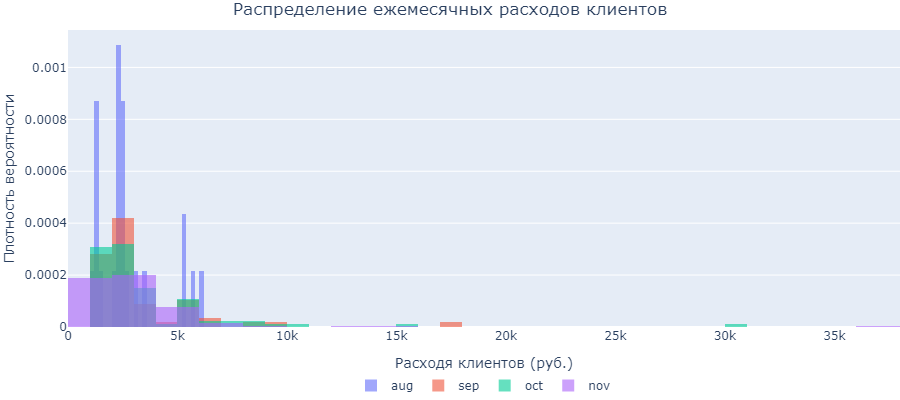

In [101]:
for m in m_list:
    print('Месяц', m)
    print(globals()['df_total_'+m]['cost'].describe().loc[['min', 'max', 'mean', '50%']])
    print()

fig = go.Figure()
for m in m_list:
    fig.add_trace(go.Histogram(x=globals()['df_total_'+m]['cost'], histnorm='probability density', opacity=0.6, name=m, nbinsx=30))

fig.update_layout(
    autosize=False,
    width=900,
    height=400,
    title="Распределение ежемесячных расходов клиентов",
    title_x = 0.5,
    xaxis_title="Расходя клиентов (руб.)",
    yaxis_title="Плотность вероятности",
    legend=dict(x=.5, xanchor="center", orientation="h", y=-.15),
    barmode='overlay',
    margin=dict(l=0, r=0, t=30, b=0))

fig.show()

Как ранее отмечалось, имеем большое количество клиентов с низкой активностью (редко, мало пользуются услугами компании). Отсюда и большое количество клиентов с низкими показателями расходов. Гистограмма подтверждает это наблюдение, ярок выраженная положительная асимметрия распределения. 

Снова среднее больше медианы. У отдельных клиентов расходы в разы больше всех остальных.

Что касается самих средних, то ситуация следующая:

|   Месяц    |     Среднее    |     Медиана    |   Максимум   |   Минимум   |
|:---:|:---:|:---:|:---:|:---:|
|     Август    |     2192 ₽    |     2000 ₽   |     6128 ₽    |     1000 ₽    |
|     Сентябрь    |     2337 ₽    |     2100 ₽   |     17 870 ₽    |     1000 ₽    |
|     Октябрь    |     2438 ₽    |     2000 ₽   |     30 481 ₽    |     1000 ₽    |
|     Ноябрь    |     2534 ₽    |     2000 ₽    |     36 338 ₽    |     1000 ₽    |


**ВЫВОДЫ**<br>
* Средние расходы клиентов больше медианных, что говорит о большом количестве клиентов с низким показателем расходов и отдельных с большими значениями. 
* По общему количеству расходов в лидерах октябрь, хотя максимальное и среднее значения больше в ноябре. 
* Интересно, что медиана в сентябре наибольшая и что минимальные значения везде одинаковые.

In [102]:
# ячейка тимлида:
display(df_cost.query('user_id == 166377'))

# проведем расчет вручную:
(data
 .assign(month = lambda x : x['date'].astype('datetime64[M]'))
 .query('user_id == 166377 and direction == "out" and internal == False')
 .groupby(['user_id','month'])
 .agg({'total_call_duration' : 'sum'})
 .reset_index()
 .merge((data
         .assign(month = lambda x : x['date'].astype('datetime64[M]'))
         .query('user_id == 166377')
         .groupby(['user_id','month']).agg({'operator_id' : 'nunique'}).reset_index()),
       on = ['user_id','month'])
 .assign(costs = lambda x : x['total_call_duration'] / 60 * 0.5 + x['operator_id'] * 100 + 2000)
)

,user_id,cost_aug,cost_sep,cost_oct,cost_nov,total_cost
0,166377,"3,150","3,282","3,327","3,195","12,954"


,user_id,month,total_call_duration,operator_id,costs
0,166377,2019-08-01,78029,5,"3,150"
1,166377,2019-09-01,105835,4,"3,282"
2,166377,2019-10-01,99207,5,"3,327"
3,166377,2019-11-01,95384,4,"3,195"


#### Клиенты с максимальными и минимальными расходами по месяцам

Посмотрим, какие клиенты обладают наибольшими и наименьшими показателями расходов в каждом месяце.

In [103]:
for m in m_list:
    globals()['df_min_max_total_'+m] = (
        globals()['df_total_'+m][(globals()['df_total_'+m].cost == globals()['df_total_'+m].cost.max())
                                     | (globals()['df_total_'+m].cost == globals()['df_total_'+m].cost.min())]
    )
    print('Месяц', m)
    display('Запись id клиента с max/min расходом в указанном месяце', 
            globals()['df_min_max_total_'+m])
    print(globals()['df_min_max_total_'+m].shape[0])
    print()

Месяц aug


'Запись id клиента с max/min расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
9,166619,15,1,1,C,1000,"1,110"
10,166658,"5,257",15,0,B,2000,"6,128"


2

Месяц sep


'Запись id клиента с max/min расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
51,167626,"21,175",44,0,A,5000,"17,870"
55,167412,0,1,1,C,1000,"1,100"


2

Месяц oct


'Запись id клиента с max/min расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
26,166993,1,1,0,C,1000,"1,101"
61,167626,"51,702",48,1,A,5000,"30,481"
83,168101,1,1,1,C,1000,"1,101"


3

Месяц nov


'Запись id клиента с max/min расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost
86,168361,"72,094",25,1,A,5000,"36,338"
92,166803,0,1,0,C,1000,"1,100"


2



Как видим минимальные значения 1100 = абонентская плата по тарифу С + плата за одного оператора, похоже на тестовый характер использования услуг. А В максимумах уже знакомые нам 168361 в ноябре, 167626 в октябре и сентябре и 166658 в августе 166619 с расходом в 6128 руб., что в 3 и в 5 раз меньше чем соответственно в сентябрьском максимуме и в октябрьском с ноябрьским.

Заметим, что максимальные расходы трех из четырех месяцев у клиентов с тарифом А. Минимумы соответствуют плате за тариф и оператора, а значит количество минут исходящих звонков равно нулю. У них были только входящие звонки (которые бесплатны, как и 120000 сек исходящих внутри сети) и исходящие внутри сети. Но! Плату за операторов никто не отменял! А показатель `0` в поле `operator_id` может означать как отсутствие назначенного на звонок оператора по причини пропуска звонка (`is_missed_call` принимает значение `True`), так и просто пропуск как потерю, ошибку в данных.

Проверим какого характера нули в поле `operator_id` этих клиентов. Начнем с пропусков, являющихся не назначенными операторами. Плата за них - `0`.

In [104]:
# Объединяем таблицы по полю user_id с ранее созданным листом id клиентов
# с количеством пропусков в operator_id (неназначенные операторы)
for m in m_list:
    globals()['df_min_max_missed_'+m] = (
        globals()['df_min_max_total_'+m].merge(oper_null_missed_user_count[['user_id', 'count_rec']], on='user_id', how='inner')
    )

# Посмотрим сколько клиентов из выше перечисленных имеют такого рода пропуски
for m in m_list:
    print('Месяц', m)
    display('Запись id клиента с максимальным расходом в указанном месяце', 
            globals()['df_min_max_missed_'+m].head())
    print(globals()['df_min_max_missed_'+m].shape[0])
    print()

Месяц aug


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,count_rec
0,166619,15,1,1,C,1000,"1,110",3
1,166658,"5,257",15,0,B,2000,"6,128",98


2

Месяц sep


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,count_rec
0,167626,"21,175",44,0,A,5000,"17,870",34
1,167412,0,1,1,C,1000,"1,100",23


2

Месяц oct


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,count_rec
0,166993,1,1,0,C,1000,"1,101",21
1,167626,"51,702",48,1,A,5000,"30,481",34
2,168101,1,1,1,C,1000,"1,101",8


3

Месяц nov


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,count_rec
0,168361,"72,094",25,1,A,5000,"36,338",42
1,166803,0,1,0,C,1000,"1,100",34


2



Ага. У всех клиентов были такого типа пропуски. Здесь все хорошо, дополнительно они ничего не должны.

Теперь проверим есть ли среди них те, у кого были ошибочные пропуски, и за пропуском скрывается работавший оператор.

In [105]:
oper_null_error

,user_id,date
9,168252,83
2,166782,16
1,166503,3
8,168018,3
0,166399,2
3,166916,1
4,166946,1
5,167402,1
6,167819,1
7,167977,1


In [106]:
# Объединяем таблицы по полю user_id с ранее созданным листом id клиентов
# с количеством пропусков в operator_id (пропуски из-за ошибки выгрузки, форматирования и т.п.)

oper_null_error = oper_null_error.reset_index()

for m in m_list:
    globals()['df_min_max_error_'+m] = (
        globals()['df_min_max_total_'+m].merge(oper_null_error, on='user_id', how='inner')
    )

# Посмотрим сколько клиентов из выше перечисленных имеют такого рода пропуски
for m in m_list:
    print('Месяц', m)
    display('Запись id клиента с максимальным расходом в указанном месяце', 
            globals()['df_min_max_error_'+m])
    print(globals()['df_min_max_error_'+m].shape[0])
    print()

Месяц aug


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,index,date


0

Месяц sep


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,index,date


0

Месяц oct


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,index,date


0

Месяц nov


'Запись id клиента с максимальным расходом в указанном месяце'

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,index,date


0



Супер. По 0. Вспомним, что на этапе предобработки мы удалили клиентов с количеством пропусков в `operator_id` равным 83 и 16, но остались с тремя, двумя и единичным. Хорошо что их нет среди "минимальных" клиентов, так как разница в 100-300 рублей означала бы для них разницу в 10-30%.

**ВЫВОДЫ**<br>
* Абсолютный максимум расходов в месяц был показан клиентом 168361 в ноябре и составил 36338 руб., что около 6% расходов всех клиентов в ноябре.
* Минимальные значения расходов равны 1100, принадлежат клиентам с тарифным планом С и говорят о том, что у этих клиентов были только входящие вызовы, им не были назначены операторы (причин может быть несколько). 
* Также дополнительно проверили клиентов с минимальными расходами на предмет их попадания в число тех, у кого были пропуски по операторам.

#### Категории расходов клиентов

Детализируем расходы клиентов по категориям: абонентская плата, расходы на исходящие внутри и вне сети, плата за операторов.

Ранее было установлено:
1. Никто из клиентов не преодолел порог в 2000 бесплатных минут на исходящие внутри сети => эти минуты бесплатные.
2. В сетке тарифов все входящие бесплатные.
3. Расходы клиентов только с входящими вызовами - расходы на абонентскую плату и на операторов.
4. Есть трудности с точным определением суммы для клиентов с пропусками в `operator_id` при ненулевых значениях `call_duration` (список оных в `oper_null_error`)

Значит остается детализировать расходы по абонентской плате, плате за операторов и плате за исходящие звонки вне сети. Эти данные также были собраны ранее в таблицах `df_total_aug`, `df_total_sep`, `df_total_oct`, `df_total_nov`.

In [107]:
# Для детализации расходов напишем функцию calls_fee

sec_a = 0.4
sec_b = 0.5
sec_c = 0.7

def calls_fee(row):
    total = row['total_call_duration']
    tariff = row ['tariff_plan']
    
    if tariff == 'A':
        total_a = total*sec_a
        return total_a
    
    if tariff == 'B':
        total_b = total*sec_b
        return total_b
    
    if tariff == 'C':
        total_c = total*sec_c
        return total_c


Применим функцию `calls_fee` к итоговым таблицам. Здесь же посчитаем расходы и на операторов.

In [108]:
for m in m_list:
    globals()['df_total_'+m]['calls_fee'] = globals()['df_total_'+m].apply(calls_fee, axis=1)
    globals()['df_total_'+m]['oper_fee'] = globals()['df_total_'+m]['operator_id']*op_fee
    display(globals()['df_total_'+m].sort_values(by='cost', ascending=False).head(3))

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
10,166658,"5,257",15,0,B,2000,"6,128","2,628",1500
16,166901,9,7,27,A,5000,"5,704",4,700
14,166843,13,2,1,A,5000,"5,205",5,200


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
51,167626,"21,175",44,0,A,5000,"17,870","8,470",4400
8,166658,"11,127",15,0,B,2000,"9,064","5,564",1500
32,167125,"10,114",8,4,C,1000,"8,880","7,080",800


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
61,167626,"51,702",48,1,A,5000,"30,481","20,681",4800
89,168361,"21,416",23,1,A,5000,"15,866","8,566",2300
85,168187,"4,336",37,30,A,5000,"10,434","1,734",3700


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
86,168361,"72,094",25,1,A,5000,"36,338","28,838",2500
70,168062,"16,462",27,524,A,5000,"14,285","6,585",2700
77,168187,"9,735",46,86,A,5000,"13,494","3,894",4600


Готово. Рассмотрим показатели средних расходов по тарифам и месяцам за звонки и оперторов.

In [109]:
# Создаем три таблицы рассходов по тарифам для каждого месяца.
for m in m_list:
    
    globals()['a_mean_median_'+m] = (
        globals()['df_total_'+m][globals()['df_total_'+m]['tariff_plan'] == 'A'][['calls_fee', 'oper_fee']]
        .describe().loc[['mean','50%']]
    )
    
    globals()['b_mean_median_'+m] = (
        globals()['df_total_'+m][globals()['df_total_'+m]['tariff_plan'] == 'B'][['calls_fee', 'oper_fee']]
        .describe().loc[['mean','50%']]
    )
    
    globals()['c_mean_median_'+m] = (
        globals()['df_total_'+m][globals()['df_total_'+m]['tariff_plan'] == 'C'][['calls_fee', 'oper_fee']]
        .describe().loc[['mean','50%']]
    )


Для каждого месяца создали три таблицы со средними и медианными значениями расходов клиентов на звонки и операторов. 

Теперь переименуем столбы и объединим тарифы по каждому месяцу.

In [110]:
for m in m_list:
    globals()['a_mean_median_'+m] = (
        globals()['a_mean_median_'+m]
        .rename(columns={
            'index':'means', 
            'calls_fee':'calls_fee_a',
            'oper_fee':'oper_fee_a'}).reset_index(drop=True)
            )

    globals()['b_mean_median_'+m] = (
        globals()['b_mean_median_'+m]
        .rename(columns={
            'index':'means', 
            'calls_fee':'calls_fee_b',
            'oper_fee':'oper_fee_b'}).reset_index(drop=True)
        )

    globals()['c_mean_median_'+m] = (
        globals()['c_mean_median_'+m]
        .rename(columns={
            'index':'means', 
            'calls_fee':'calls_fee_c',
            'oper_fee':'oper_fee_c'}).reset_index(drop=True)
    )

# Соединяем три тарифа в рамках месяца в одну таблицу
for m in m_list:
    
    globals()['df_des_'+m] = (
        pd.concat([globals()['a_mean_median_'+m], globals()['b_mean_median_'+m]], axis=1)
    )
                   
    globals()['df_des_'+m] = (
        pd.concat([globals()['df_des_'+m], globals()['c_mean_median_'+m]], axis=1)
    )
    print('Месяц', m)                                    
    display(globals()['df_des_'+m])
    print()

Месяц aug


,calls_fee_a,oper_fee_a,calls_fee_b,oper_fee_b,calls_fee_c,oper_fee_c
0,3,367,506,375,174,350
1,4,200,232,200,69,300



Месяц sep


,calls_fee_a,oper_fee_a,calls_fee_b,oper_fee_b,calls_fee_c,oper_fee_c
0,"1,079",975,440,383,883,380
1,23,550,93,200,113,300



Месяц oct


,calls_fee_a,oper_fee_a,calls_fee_b,oper_fee_b,calls_fee_c,oper_fee_c
0,"2,373","1,233",550,432,867,310
1,164,500,208,300,154,300



Месяц nov


,calls_fee_a,oper_fee_a,calls_fee_b,oper_fee_b,calls_fee_c,oper_fee_c
0,"3,024","1,193",592,485,567,327
1,335,650,198,300,289,300


Во всех месяцах снова замечаем, что медиана (вторые строки) меньше среднего (первые строки) и по звонкам и по операторам. Исключение составляет тариф А в сентябре. Но судя по значениям средней и медианы, этот тариф вообще не пользовался популярностью, с точки зрения активности и средние и медианные значения за операторов на порядок выше расходов на звонки. 

Вместе с тем: 
* Наибольшие расходы по всем показателям и тарифам у клиентов в октябре и ноябре.
* Расход по всем тарифам с сентября по ноябрь росли (или как минимум оставались на таком же или близком уровне), кроме тарифа С - у него заметено уменьшение средних расходов на звонки и увеличение медианных. При этом медианы на операторов постоянны, а средние - возрастают, убывают и т.д.
* Тариф А стабильно показывал рост расходов почти по всем показателям.


Относительно средних расходов на звонки:
* Кроме августа, в каждом месяце расходы на звонки по тарифу А наибольшие, далее С, наименьшие у В.
* В октябре и ноябре средние расходы по тарифу А превосходят средние расходы по тарифам В и С вместе взятым, как по звонкам, так и по операторам.

Посмотрим какую часть каждая категория составляет от общей величины расходов в месяц. 

In [111]:
list_list = []
fee_list = []
for m in m_list:
    globals()['sum_tariif_'+m] = globals()['df_total_'+m]['tariff_fee'].sum()
    globals()['sum_total_'+m] = globals()['df_total_'+m]['total_call_duration'].sum()
    globals()['sum_oper_'+m] = globals()['df_total_'+m]['oper_fee'].sum()
    globals()['sum_'+m] = [globals()['sum_tariif_'+m], globals()['sum_total_'+m],  globals()['sum_oper_'+m]]
    list_list.append(globals()['sum_'+m])
    fee_list.append(['tariff_total_'+m, 'duration_total_'+m, 'operator_total_'+m])

sum_list = list(chain.from_iterable(list_list))
item_list = list(chain.from_iterable(fee_list))

df_part = pd.DataFrame({'total_cost': sum_list, 'cost_item': item_list})

df_part.head()

,total_cost,cost_item
0,"47,000",tariff_total_aug
1,"14,155",duration_total_aug
2,"8,400",operator_total_aug
3,"113,000",tariff_total_sep
4,"74,252",duration_total_sep


Таблица `df_part` готова, построим визуализацию по ней.

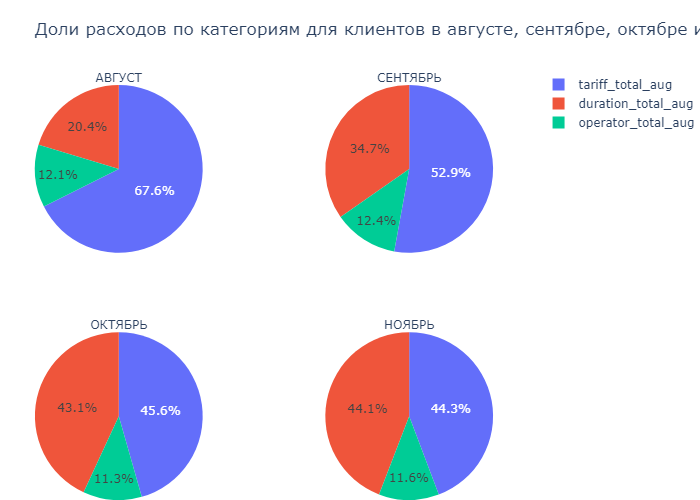

In [112]:
# Изобразим доли расходов на круговых диаграммах на одной странице
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}],[{"type": "pie"}, {"type": "pie"}]])


fig.add_trace(go.Pie(
     labels= df_part['cost_item'].iloc[:3],
     values= df_part['total_cost'].iloc[:3],
     #domain=dict(x=[0, 0.5]),
     title='АВГУСТ',
     name="Август"), 
     row=1, col=1)

fig.add_trace(go.Pie(
     labels= df_part['cost_item'].iloc[:3],
     values= df_part['total_cost'].iloc[3:6],
     #domain=dict(x=[0.5, 1.0]),
    title='СЕНТЯБРЬ',
     name="Сентябрь"),
     row=1, col=2)

fig.add_trace(go.Pie(
     labels= df_part['cost_item'].iloc[:3],
     values= df_part['total_cost'].iloc[6:9],
     #domain=dict(x=[0, 0.5]),
    title='ОКТЯБРЬ',
     name="Октябрь"), 
     row=2, col=1)

fig.add_trace(go.Pie(
     labels= df_part['cost_item'].iloc[:3],
     values= df_part['total_cost'].iloc[9:],
     #domain=dict(x=[0.5, 1.0]),
    title='НОЯБРЬ',
     name="Ноябрь"),
     row=2, col=2)

fig.update_layout(
                  title="Доли расходов по категориям для клиентов в августе, сентябре, октябре и ноябре",
                  xaxis={'categoryorder':'total descending'},
                  margin=dict(l=0, r=0, t=70, b=0),
)
fig.show()


**ВЫВОДЫ**<br>
* Сплитовали расходы клиентов по трем категориям - абонентская плата, длительность внешних исходящих, операторы.
* Доля расходов на абонентскую плату начиная с сентября и 68% постепенно снижалась и к октябрю, ноябрю составила 47% и 44% соответственно.
* Доля расходов на звонки наоборот, показывала стабильный рост с 20% в сентябре и далее до 44% в ноябре, т.е. к ноябрю сравнялась с долей расходов на абонентскую плату.
* Несмотря на меньшую активность клиентов в августе и наибольшие расходы клиентов в октябре и ноябре, доля расходов на операторов все 4 месяца находилась примерно в районе 11-12%.

#### Выручка компании до изменения тарифов

Посчитаем выручку компании по месяцам и общую за весь исследуемый период. 

Вспомним, что у нас были пропуски в `operator_id`. Клиентов с самыми большим количеством пропусков мы (83 и 16) мы исключили из исследования. Но остались клиенты (9 клиентов) с количеством пропусков в `operator_id` от 3 до 1 (двое с 3, один с 2 и шесть с 1). 

Значит суммарно эти пропуски могут означать, что за ними скрывается оператор уже работавший в этом месяце с клиентом, или это могут быть различные, еще не работавшие с этим клиентом операторы. 

Т.е. в лучшем случае к сумме ничего прибавлять не надо (лучший для объективности результатов исследования). В худшем надо учитывать, что мы "недосчитываем" 1400 руб, а во всех остальных случаях погрешность в вычислении итоговой суммы выручки компании принадлежит отрезку от 0 до 1400 руб.

Посмотрим как распределились пропуски (и сама погрешность) по месяцам.

In [113]:
# Выведем информацию по ошибочным пропускам в operator_id по месяцам
for m in m_list:
    globals()['df_nan_'+m] = globals()['df_'+m][(globals()['df_'+m].operator_id.isnull() == True)]
    globals()['df_nan_'+m] = globals()['df_nan_'+m][(globals()['df_nan_'+m].is_missed_call == False)
               &(globals()['df_nan_'+m].call_duration != 0)]

for m in m_list:
    display(globals()['df_nan_'+m].groupby('user_id', as_index=False)['direction'].count())


,user_id,direction
0,166399,1


,user_id,direction
0,166399,1
1,166503,1
2,166946,1
3,167402,1


,user_id,direction
0,166503,2
1,166916,1
2,167819,1


,user_id,direction
0,167977,1
1,168018,3
2,168336,1


А вот и они. Максимальное значение погрешности вычисления выручки:
* В августе - 100 руб.
* В сентябре - 400 руб
* В октябре - 400 руб.
* В ноябре - 500 руб

Посчитаем выручку по месяцам.

,month,total_sum
0,август,"62,873"
1,сентябрь,"180,776"
2,октябрь,"331,651"
3,ноябрь,"318,853"


Выручка компании за все 4 месяца: 894152.0


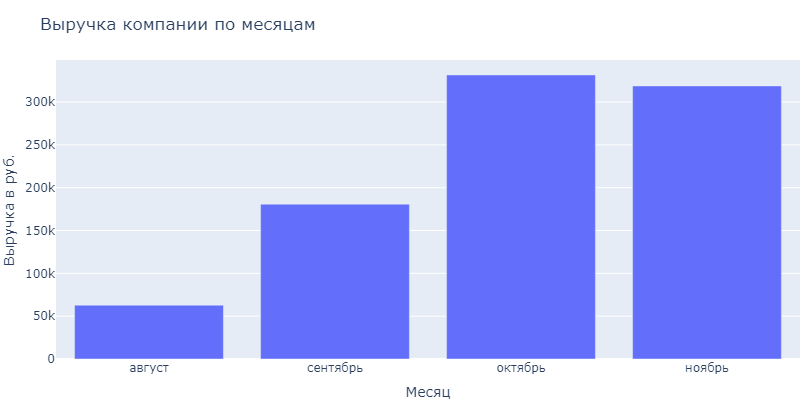

In [114]:
t_sum = []
# Считаем суммы по месяцам
for m in m_list:
    globals()['total_'+m] = globals()['df_total_'+m]['cost'].sum()
    t_sum.append(globals()['total_'+m])

list_month = ['август', 'сентябрь', 'октябрь', 'ноябрь']    
total_four_month = pd.DataFrame({'month':list_month, 'total_sum':t_sum})
# Таблица сумм выручки по месяцам готова
display(total_four_month)
print('Выручка компании за все 4 месяца:', total_four_month['total_sum'].sum())

# Визуализируем выручку по месяцам
fig = go.Figure()

fig.add_trace(
    go.Bar(
    x = total_four_month['month'],
    y = total_four_month['total_sum'],
    )
    )


fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    title="Выручка компании по месяцам",
    yaxis_title='Выручка в руб.',
    xaxis_title="Месяц",
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"),
    margin=dict(l=0, r=0, t=60, b=0),
    yaxis={'categoryorder':'total ascending'}
)
    

Ожидаемо. С августа на сентябрь скачок в 3 раза! Сентябрь - октябрь почти в 2 раза. С октября на ноябрь мы видим небольшой спад, всего около 13 тыс. руб.

Посмотрим какие доли по месяцам относительно всего квартала.

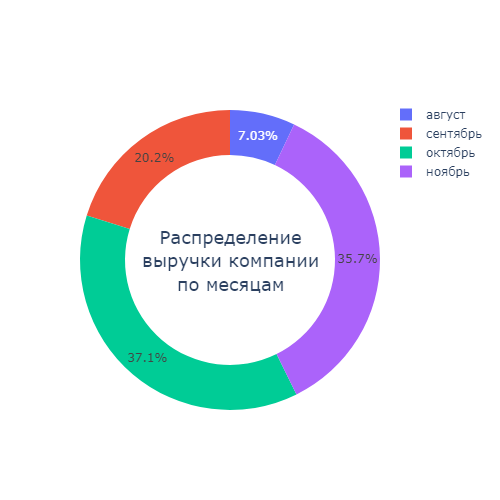

In [115]:
# Визуализируем доли выручки по месяцам
fig = go.Figure()
fig.add_trace(go.Pie(
    values=total_four_month['total_sum'], 
    labels=total_four_month['month'], 
    hole=0.7,
    sort=False))

fig.update_layout( autosize=False,
                  width = 500,
                  height = 500,
    annotations=[dict(text='Распределение<br>выручки компании<br>по месяцам',
                      x=0.5, y=0.5, font_size=18, showarrow=False)])
fig.show()

**ВЫВОДЫ**<br>
* Первое место за октябрем - 331.7 тыс. руб., что составило 37% всей выручки за квартал приходится на этот месяц.
* На втором месте ноябрь - 318.9 тыс. руб. и это 36%, очень близко к октябрю.
* На третьем месте сентябрь - 180.8 тыс. руб. т.е. примерно 1/5 всей выручки за квартал.
* На последнем месте август - 62.9 тыс. руб. или 7%.


#### Выручка компании по тарифам

Рассмотрим теперь выручку по тарифам. За весть период и по месяцам. 

In [116]:
df_total_nov
t_list = ['A', 'B', 'C']
sum_tariff_list = []
for m in m_list:
    for t in t_list:
        globals()[t+'_rev_'+m] = globals()['df_total_'+m][globals()['df_total_'+m]['tariff_plan'] == t]
        globals()[t+'sum_'+m] = globals()[t+'_rev_'+m]['cost'].sum()
        sum_tariff_list.append(round(globals()[t+'sum_'+m]))

In [117]:
# Создадим список месяцов для таблица выручки по тарифам и месяцам
month_list_repit = list(map(lambda x, y: [x] * y, ['август','сентябрь','октябрь', 'ноябрь'], [3,3,3,3]))
month_list_repit = list(chain.from_iterable(month_list_repit))

# Таблица выручки по тарифам в кадом месяце
sum_tariff = (
    pd.DataFrame(
        {
            'month':month_list_repit,
            'tariff_plan':t_list*4,
            'tariff_cost':sum_tariff_list
        }
    )
)

sum_tariff

,month,tariff_plan,tariff_cost
0,август,A,16109
1,август,B,34572
2,август,C,12192
3,сентябрь,A,56434
4,сентябрь,B,67762
5,сентябрь,C,56579
6,октябрь,A,129088
7,октябрь,B,113311
8,октябрь,C,89252
9,ноябрь,A,129036


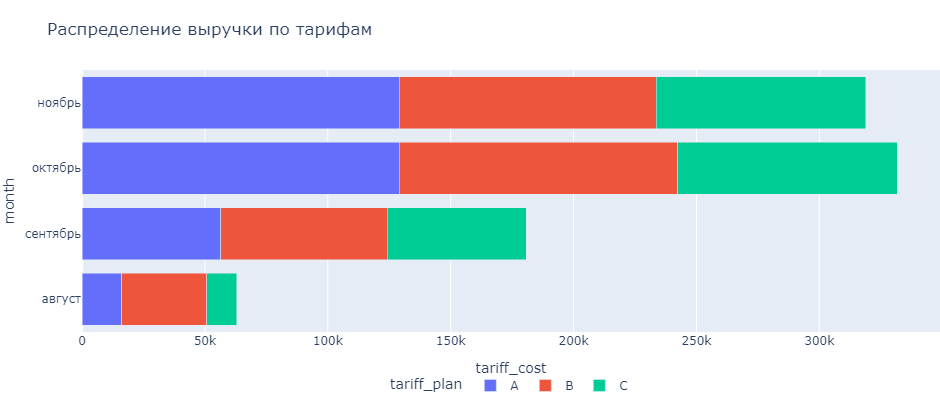

In [118]:

fig = px.bar(
    sum_tariff, 
    y="month",
    x='tariff_cost',
    color="tariff_plan", 
    barmode="stack",
)

fig.update_layout(
                  
                  autosize=False,
                  width=940,
                  height=400,
                  title="Распределение выручки по тарифам",
                  legend_orientation="h",
                  xaxis={'categoryorder':'total descending'},
                  legend=dict(x=.5, xanchor="center", y=-.15),
                  margin=dict(l=0, r=0, t=70, b=0))


fig.show()

В августе наибольшую выручку компании принес тариф В, причем больше чем два других вместе взятых. В сентябре также тариф В был наиболее прибыльным. В октябре и ноябре на первом месте оказался тариф А, причем с точностью до сотен рублей принесший одинаковую выручку. Отметим также, что за счет большей выручки по тарифам В и С октябрьская выручка превосходит ноябрьскую.

### Клиенты с неэффективными тарифами

Отберем по ранее сформированному списку активных клиентов соотвествующие записи о них из таблиц df_total_"месяц"

In [119]:
for i, m in zip(range(4), m_list):
    globals()['act_cost_'+m] = (
        globals()['df_total_'+m][(globals()['df_total_'+m].user_id.isin(lst_out[i])) 
                                     &(globals()['df_total_'+m].user_id.isin(globals()['activ_list_'+m]))]
           )
    display(globals()['act_cost_'+m].sort_values(by='cost', ascending=False))

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
10,166658,"5,257",15,0,B,2000,"6,128","2,628",1500
2,166406,"2,597",3,15,B,2000,"3,598","1,298",300


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
8,166658,"11,127",15,0,B,2000,"9,064","5,564",1500
32,167125,"10,114",8,4,C,1000,"8,880","7,080",800
23,167011,"6,288",6,1,C,1000,"6,002","4,402",600
22,166997,"3,951",6,60,C,1000,"4,366","2,766",600
3,166485,"2,192",4,152,B,2000,"3,496","1,096",400
20,166983,"2,556",5,110,C,1000,"3,289","1,789",500
0,166377,"1,764",4,1,B,2000,"3,282",882,400
1,166406,"1,859",2,1,B,2000,"3,130",930,200
5,166511,"2,407",3,7,C,1000,"2,985","1,685",300
31,167112,"2,359",2,0,C,1000,"2,851","1,651",200


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
61,167626,"51,702",48,1,A,5000,"30,481","20,681",4800
85,168187,"4,336",37,30,A,5000,"10,434","1,734",3700
70,167827,"12,030",3,1,C,1000,"9,721","8,421",300
13,166658,"10,322",16,0,B,2000,"8,761","5,161",1600
46,167285,"6,785",1,7,A,5000,"7,814","2,714",100
37,167125,"8,302",8,3,C,1000,"7,611","5,811",800
1,166405,"6,298",10,13,B,2000,"6,149","3,149",1000
72,167888,"4,676",3,1,C,1000,"4,573","3,273",300
15,166680,"1,877",10,0,B,2000,"3,938",938,1000
7,166520,"2,670",10,1,C,1000,"3,869","1,869",1000


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
86,168361,"72,094",25,1,A,5000,"36,338","28,838",2500
70,168062,"16,462",27,524,A,5000,"14,285","6,585",2700
77,168187,"9,735",46,86,A,5000,"13,494","3,894",4600
12,166658,"9,167",15,0,B,2000,"8,084","4,584",1500
48,167497,"1,853",17,1393,A,5000,"7,441",741,1700
1,166405,"6,781",8,2,B,2000,"6,190","3,390",800
73,168091,"3,940",16,659,B,2000,"5,570","1,970",1600
14,166680,"3,529",13,0,B,2000,"5,064","1,764",1300
87,168412,"4,146",9,1,C,1000,"4,802","2,902",900
85,168336,"2,862",13,50,C,1000,"4,303","2,003",1300


Готово. Как мы и отмечали в пункте 3.2.8 список активных клиентов можно скореектировать, а именно расширить, добавить клиентов с близкими значениями расходов (здесь уже можно задать дополнительно порог активности по месячному рассходу).

Рассчитаем возможные расходы активных клиентов по двум другим (отличным от данных) тарифам. Создадим соотвествующие функции.

In [120]:
# Сетка тарифных планов
subscr_a = 5000
subscr_b = 2000
subscr_c = 1000

sec_a = 0.4
sec_b = 0.5
sec_c = 0.7

op_fee = 100
 
# Функция расчета общей стоимости услуг
# по другому тарифу A->B, B->C, C->A
def abc(row):
    total = row['total_call_duration']
    operator = row['operator_id']
    tariff_plan = row['tariff_plan']
   
    
    if tariff_plan == 'A':
        total_a = subscr_b + total*sec_b + operator*op_fee 
        return total_a
    
    if tariff_plan == 'B':
        total_b = subscr_c + total*sec_c + operator*op_fee 
        return total_b
    
    if tariff_plan == 'C':
        total_c = subscr_a + total*sec_a + operator*op_fee 
        return total_c

# Функция расчета общей стоимости услуг
# по другому тарифу A->C, B->A, C->B
def acb(row):
    total = row['total_call_duration']
    operator = row['operator_id']
    tariff_plan = row['tariff_plan']
   
    
    if tariff_plan == 'A':
        total_a = subscr_c + total*sec_c + operator*op_fee 
        return total_a
    
    if tariff_plan == 'B':
        total_b = subscr_a + total*sec_a + operator*op_fee 
        return total_b
    
    if tariff_plan == 'C':
        total_c = subscr_b + total*sec_b + operator*op_fee 
        return total_c 

Теперь осталось применить эти две функции к полученным таблицам активных клиентов.

In [121]:
# Применяем формулы к строкам каждой из 4 таблиц 
for m in m_list:
    
    globals()['act_cost_'+m] = globals()['act_cost_'+m].copy()
    globals()['act_cost_'+m]['cost_abc'] = globals()['act_cost_'+m].apply(abc, axis=1)
    
    globals()['act_cost_'+m] = globals()['act_cost_'+m].copy()
    globals()['act_cost_'+m]['cost_acb'] = globals()['act_cost_'+m].apply(acb, axis=1)
    
    display(globals()['act_cost_'+m].head(2))

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb
2,166406,"2,597",3,15,B,2000,"3,598","1,298",300,"3,118","6,339"
10,166658,"5,257",15,0,B,2000,"6,128","2,628",1500,"6,180","8,603"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb
0,166377,"1,764",4,1,B,2000,"3,282",882,400,"2,635","6,106"
1,166406,"1,859",2,1,B,2000,"3,130",930,200,"2,501","5,944"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb
1,166405,"6,298",10,13,B,2000,"6,149","3,149",1000,"6,409","8,519"
2,166406,"1,856",2,14,B,2000,"3,128",928,200,"2,499","5,942"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb
1,166405,"6,781",8,2,B,2000,"6,190","3,390",800,"6,547","8,512"
3,166485,"3,346",5,218,B,2000,"4,173","1,673",500,"3,842","6,838"


Теперь мы можем сравнить расходы по всем тарифам и определить клиентов с неэффективными тарифами. 

In [122]:
# Создадим дополнительные поля 
# с разностью между расходом по текущему тарифу и другим тарифом
for m in m_list:
    # diff_abc - разность между A и В, В и С, С и А
    globals()['act_cost_'+m]['diff_abc'] = (
        globals()['act_cost_'+m]['cost'] - globals()['act_cost_'+m]['cost_abc']
    )
    # diff_acb - разность между A и С, В и А, С и В
    globals()['act_cost_'+m]['diff_acb'] = (
        globals()['act_cost_'+m]['cost'] - globals()['act_cost_'+m]['cost_acb']
    )
    display(globals()['act_cost_'+m].head(2))

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
2,166406,"2,597",3,15,B,2000,"3,598","1,298",300,"3,118","6,339",481,"-2,740"
10,166658,"5,257",15,0,B,2000,"6,128","2,628",1500,"6,180","8,603",-51,"-2,474"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
0,166377,"1,764",4,1,B,2000,"3,282",882,400,"2,635","6,106",647,"-2,824"
1,166406,"1,859",2,1,B,2000,"3,130",930,200,"2,501","5,944",628,"-2,814"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
1,166405,"6,298",10,13,B,2000,"6,149","3,149",1000,"6,409","8,519",-260,"-2,370"
2,166406,"1,856",2,14,B,2000,"3,128",928,200,"2,499","5,942",629,"-2,814"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
1,166405,"6,781",8,2,B,2000,"6,190","3,390",800,"6,547","8,512",-356,"-2,322"
3,166485,"3,346",5,218,B,2000,"4,173","1,673",500,"3,842","6,838",331,"-2,665"


Значение положительной разницы является той переплатой, которая возникает у пользователя из-за использования неэффективного тарифа. Отметим также, что если оба числа в `diff_abc` и `diff_acb` положительнее, то любой из двух новых тарифов можно будет считать оптимальнее текущего. Но для компании выгоднее тариф с меньшей разницей. Здесь как раз можно сэкономить предложив тариф выгодный и компании и клиенту!

Если разность расходов текущего тарифа и другого отрицательная, значит текущий тариф оптимальнее, если положительная - оптимальным будет новый тариф. Отфильтруем клиентов с оптимальными тарифами, для них ничего сделать мы уже не можем. Сохраним информацию о них в отдельных таблицах.

In [123]:
for m in m_list:
    globals()['act_cost_opt'+m] = (
        globals()['act_cost_'+m].query('diff_abc < 0 & diff_acb < 0')
    )
    
    display(globals()['act_cost_opt'+m])
list_not = []
for m in m_list:
    list_not.append(globals()['act_cost_opt'+m]['user_id'].to_list())

list_not = list(chain.from_iterable(list_not))
list_not = (list(set(list_not)))
print(list_not)

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
10,166658,"5,257",15,0,B,2000,"6,128","2,628",1500,"6,180","8,603",-51,"-2,474"


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
5,166511,"2,407",3,7,C,1000,"2,985","1,685",300,"6,263","3,504","-3,278",-519
8,166658,"11,127",15,0,B,2000,"9,064","5,564",1500,"10,289","10,951","-1,225","-1,887"
20,166983,"2,556",5,110,C,1000,"3,289","1,789",500,"6,522","3,778","-3,233",-489
22,166997,"3,951",6,60,C,1000,"4,366","2,766",600,"7,180","4,576","-2,815",-210
31,167112,"2,359",2,0,C,1000,"2,851","1,651",200,"6,144","3,380","-3,292",-528


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
1,166405,"6,298",10,13,B,2000,"6,149","3,149",1000,"6,409","8,519",-260,"-2,370"
6,166511,"3,386",3,5,C,1000,"3,670","2,370",300,"6,654","3,993","-2,984",-323
7,166520,"2,670",10,1,C,1000,"3,869","1,869",1000,"7,068","4,335","-3,199",-466
13,166658,"10,322",16,0,B,2000,"8,761","5,161",1600,"9,825","10,729","-1,064","-1,968"
25,166983,"3,516",4,67,C,1000,"3,861","2,461",400,"6,806","4,158","-2,945",-297
35,167112,"2,469",5,1,C,1000,"3,228","1,728",500,"6,488","3,734","-3,259",-506
38,167150,"2,732",7,397,C,1000,"3,612","1,912",700,"6,793","4,066","-3,180",-454
61,167626,"51,702",48,1,A,5000,"30,481","20,681",4800,"32,651","41,991","-2,170","-11,511"
63,167650,"2,310",4,3,C,1000,"3,017","1,617",400,"6,324","3,555","-3,307",-538
72,167888,"4,676",3,1,C,1000,"4,573","3,273",300,"7,170","4,638","-2,597",-65


,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
1,166405,"6,781",8,2,B,2000,"6,190","3,390",800,"6,547","8,512",-356,"-2,322"
6,166511,"2,730",3,1,C,1000,"3,211","1,911",300,"6,392","3,665","-3,181",-454
12,166658,"9,167",15,0,B,2000,"8,084","4,584",1500,"8,917","10,167",-833,"-2,083"
25,166983,"3,202",4,46,C,1000,"3,641","2,241",400,"6,681","4,001","-3,039",-360
33,167150,"2,745",7,216,C,1000,"3,622","1,921",700,"6,798","4,072","-3,176",-451
54,167650,"2,392",4,1,C,1000,"3,074","1,674",400,"6,357","3,596","-3,282",-522
62,167888,"3,446",3,0,C,1000,"3,712","2,412",300,"6,678","4,023","-2,966",-311
85,168336,"2,862",13,50,C,1000,"4,303","2,003",1300,"7,445","4,731","-3,141",-428
86,168361,"72,094",25,1,A,5000,"36,338","28,838",2500,"40,547","53,966","-4,209","-17,628"
87,168412,"4,146",9,1,C,1000,"4,802","2,902",900,"7,558","4,973","-2,756",-171


[166658, 167650, 166405, 166983, 167112, 168361, 167626, 167150, 166511, 167888, 168336, 166997, 166520, 168412]


14 клиентов: 166658, 167650, 166405, 166983, 167112, 168361, 167626, 167150, 166511, 167888, 168336, 166997, 166520, 168412. Клиент 168361 - с максимальным значение в ноябре, хорошо что с оптимальным тарифом. 166658 - активен все 4 месяца, с ростом по расходам от августа к сентябрю, далее небольшой спад в октябре и аналогичное значение в ноябре. 166405 стабильно активен последние два месяца. 167150 - стабильно активен последние три месяца. И т.д., этим клиентам ничего предложить не можем. Их тарифы оптимальны.

Посмотрим количество активных клиентов с неэффективными тарифами в каждом месяце.

In [124]:
list_users = []
for m in m_list:
    globals()['act_cost_x'+m] = (
        globals()['act_cost_'+m].query('diff_abc > 0 | diff_acb > 0')
    )
    list_users.append(globals()['act_cost_x'+m]['user_id'].to_list()) 

res_users_list = list(chain.from_iterable(list_users))
res_users_list = (list(set(res_users_list)))

print('Клиенты, которые используют свой тариф эффективно:', res_users_list)
print('Количество активных пользователей с неэффективными тарифами:', len(res_users_list))

Клиенты, которые используют свой тариф эффективно: [167011, 167479, 166406, 167654, 166377, 167497, 168091, 167827, 167125, 166485, 167285, 166680, 168187, 168062]
Количество активных пользователей с неэффективными тарифами: 14


In [125]:
act_cost_xoct

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb
2,166406,"1,856",2,14,B,2000,"3,128",928,200,"2,499","5,942",629,"-2,814"
4,166485,"1,732",5,310,B,2000,"3,366",866,500,"2,712","6,193",654,"-2,827"
15,166680,"1,877",10,0,B,2000,"3,938",938,1000,"3,314","6,751",625,"-2,812"
37,167125,"8,302",8,3,C,1000,"7,611","5,811",800,"9,121","6,951","-1,509",660
46,167285,"6,785",1,7,A,5000,"7,814","2,714",100,"5,492","5,850","2,322","1,964"
70,167827,"12,030",3,1,C,1000,"9,721","8,421",300,"10,112","8,315",-391,"1,406"
85,168187,"4,336",37,30,A,5000,"10,434","1,734",3700,"7,868","7,735","2,566","2,699"


Остаются **14 клиентов с неэффективными тарифами**, что составляет около **5% от числа всех клиентов** и менее **половины от числа активных клиентов.**

Посчитаем какую выручку они приносили компании, используя свои текущие тарифы. 

In [126]:
non_opt_sum = 0
for m in m_list:
    globals()['non_opt_cost'+m] = globals()['act_cost_x'+m]['cost'].sum()
    print('Выручка компании за', m, ', которую принесли клиенты с неэффективными тарифами:', int(globals()['non_opt_cost'+m]))
    non_opt_sum += globals()['non_opt_cost'+m]
print('Выручка компании за весь ииследуемый период, которую принесли клиенты с неэффективными тарифами:', int(non_opt_sum))

Выручка компании за aug , которую принесли клиенты с неэффективными тарифами: 3598
Выручка компании за sep , которую принесли клиенты с неэффективными тарифами: 24788
Выручка компании за oct , которую принесли клиенты с неэффективными тарифами: 46013
Выручка компании за nov , которую принесли клиенты с неэффективными тарифами: 56438
Выручка компании за весь ииследуемый период, которую принесли клиенты с неэффективными тарифами: 130839


Выручка компании, которую принесли неэффективные клиенты практически пропорциональна общей выручке компании и варьируется от 6 до 18 процентов. Существенные доли. Действительно, терять таких клиентов не хотелось бы.


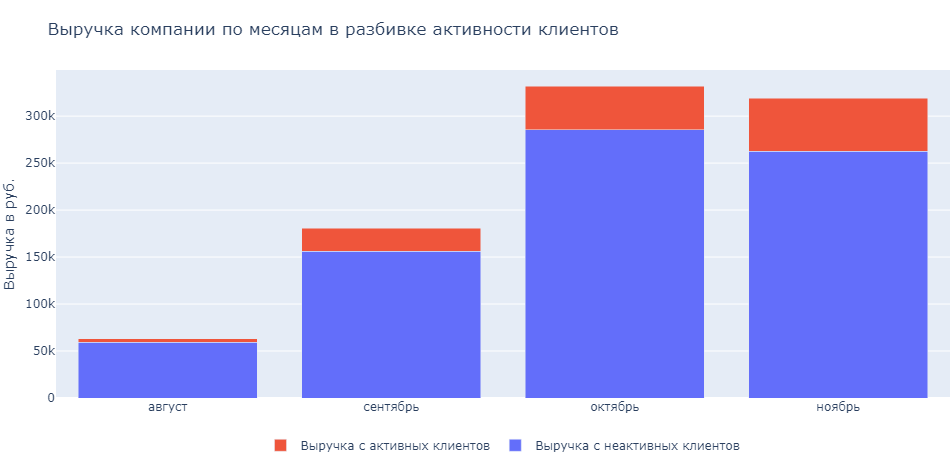

In [127]:
# Визуализируем доли выручки от активных клиентов
df = pd.DataFrame({'cost_activ':
                   [
                       int(non_opt_costaug),
                       int(non_opt_costsep),
                       int(non_opt_costoct),
                       int(non_opt_costnov)
                   ]
                  })
df = pd.concat([total_four_month, df], axis=1)
df['total_sum'] = df['total_sum'] - df['cost_activ']

fig = go.Figure()

fig.add_trace(
        go.Bar(
            x = df['month'],
            y = df['total_sum'],
            name = 'Выручка с неактивных клиентов')
            )
fig.add_trace(
        go.Bar(
            x = df['month'],
            y = df['cost_activ'],
            name = 'Выручка с активных клиентов')
            )


fig.update_layout(
    barmode='stack',
    autosize=False,
    width=950,
    height=460,
    title="Выручка компании по месяцам в разбивке активности клиентов",
    yaxis_title='Выручка в руб.',
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"),
    margin=dict(l=0, r=0, t=70, b=0),
    yaxis={'categoryorder':'total ascending'}
)
                         
fig.show()

Наибольшая доля выручки от активных клиентов за ноябрь, наименьшая - за август.

Посмотрим на количество активных клиентов, для которых любой тариф был бы оптимальнее текущего (переплаты по каждому из двух альтернативных тарифов положительны)

In [128]:
u_list = []
for m in m_list:
    
    u_list.append(globals()['act_cost_'+m].query('diff_abc > 0 & diff_acb > 0')['user_id'].to_list())

In [129]:
ulist = list(chain.from_iterable(u_list))
ulist = list(set(ulist))
print('Количество клиентов, для которых оптимальный тариф можно выбрать из двух оставшихся:', len(ulist))

Количество клиентов, для которых оптимальный тариф можно выбрать из двух оставшихся: 3


Напишем функцию определения оптимального тарифа, который бы сократил расходы клиента, при этом минимально уменьшил выручку компании.

In [130]:
def optimal_x(row):
    tariff = row['tariff_plan']
    diff_abc = row['diff_abc']
    diff_acb = row['diff_acb']
    
 
    if tariff == 'A':
        if diff_abc < 0 and diff_acb < 0:
            return 'A'
        else:
            if (diff_abc < diff_acb and diff_abc > 0) or (diff_abc > 0 and diff_acb < 0):
                return 'B'
            else:
                return 'C'
            
    if tariff == 'B':
        if diff_abc < 0 and diff_acb < 0:
            return 'B'
        else:
            if (diff_abc < diff_acb and diff_abc > 0) or (diff_abc > 0 and diff_acb < 0):
                return 'C'
            else:
                return 'A'
            
    if tariff == 'C':
        if diff_abc < 0 and diff_acb < 0:
            return 'C'
        else:
            if (diff_abc < diff_acb and diff_abc > 0) or (diff_abc > 0 and diff_acb < 0):
                return 'A'
            else:
                return 'B'
            
# Применяем формулу к строкам каждой из 4 таблиц 
for m in m_list:
    
    #globals()['act_cost_y'+m] = globals()['act_cost_'+m].copy()
    globals()['act_cost_'+m]['best_tariff'] = globals()['act_cost_'+m].apply(optimal_x, axis=1)
    display(globals()['act_cost_'+m])
    display(globals()['act_cost_'+m].best_tariff.value_counts())

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb,best_tariff
2,166406,"2,597",3,15,B,2000,"3,598","1,298",300,"3,118","6,339",481,"-2,740",C
10,166658,"5,257",15,0,B,2000,"6,128","2,628",1500,"6,180","8,603",-51,"-2,474",B


C    1
B    1
Name: best_tariff, dtype: int64

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb,best_tariff
0,166377,"1,764",4,1,B,2000,"3,282",882,400,"2,635","6,106",647,"-2,824",C
1,166406,"1,859",2,1,B,2000,"3,130",930,200,"2,501","5,944",628,"-2,814",C
3,166485,"2,192",4,152,B,2000,"3,496","1,096",400,"2,934","6,277",562,"-2,781",C
5,166511,"2,407",3,7,C,1000,"2,985","1,685",300,"6,263","3,504","-3,278",-519,C
8,166658,"11,127",15,0,B,2000,"9,064","5,564",1500,"10,289","10,951","-1,225","-1,887",B
20,166983,"2,556",5,110,C,1000,"3,289","1,789",500,"6,522","3,778","-3,233",-489,C
22,166997,"3,951",6,60,C,1000,"4,366","2,766",600,"7,180","4,576","-2,815",-210,C
23,167011,"6,288",6,1,C,1000,"6,002","4,402",600,"8,115","5,744","-2,114",258,B
31,167112,"2,359",2,0,C,1000,"2,851","1,651",200,"6,144","3,380","-3,292",-528,C
32,167125,"10,114",8,4,C,1000,"8,880","7,080",800,"9,846","7,857",-966,"1,023",B


C    7
B    3
Name: best_tariff, dtype: int64

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb,best_tariff
1,166405,"6,298",10,13,B,2000,"6,149","3,149",1000,"6,409","8,519",-260,"-2,370",B
2,166406,"1,856",2,14,B,2000,"3,128",928,200,"2,499","5,942",629,"-2,814",C
4,166485,"1,732",5,310,B,2000,"3,366",866,500,"2,712","6,193",654,"-2,827",C
6,166511,"3,386",3,5,C,1000,"3,670","2,370",300,"6,654","3,993","-2,984",-323,C
7,166520,"2,670",10,1,C,1000,"3,869","1,869",1000,"7,068","4,335","-3,199",-466,C
13,166658,"10,322",16,0,B,2000,"8,761","5,161",1600,"9,825","10,729","-1,064","-1,968",B
15,166680,"1,877",10,0,B,2000,"3,938",938,1000,"3,314","6,751",625,"-2,812",C
25,166983,"3,516",4,67,C,1000,"3,861","2,461",400,"6,806","4,158","-2,945",-297,C
35,167112,"2,469",5,1,C,1000,"3,228","1,728",500,"6,488","3,734","-3,259",-506,C
37,167125,"8,302",8,3,C,1000,"7,611","5,811",800,"9,121","6,951","-1,509",660,B


C    11
B     5
A     1
Name: best_tariff, dtype: int64

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee,cost_abc,cost_acb,diff_abc,diff_acb,best_tariff
1,166405,"6,781",8,2,B,2000,"6,190","3,390",800,"6,547","8,512",-356,"-2,322",B
3,166485,"3,346",5,218,B,2000,"4,173","1,673",500,"3,842","6,838",331,"-2,665",C
6,166511,"2,730",3,1,C,1000,"3,211","1,911",300,"6,392","3,665","-3,181",-454,C
12,166658,"9,167",15,0,B,2000,"8,084","4,584",1500,"8,917","10,167",-833,"-2,083",B
14,166680,"3,529",13,0,B,2000,"5,064","1,764",1300,"4,770","7,712",294,"-2,647",C
25,166983,"3,202",4,46,C,1000,"3,641","2,241",400,"6,681","4,001","-3,039",-360,C
33,167150,"2,745",7,216,C,1000,"3,622","1,921",700,"6,798","4,072","-3,176",-451,C
47,167479,"2,181",2,0,B,2000,"3,290","1,090",200,"2,727","6,072",564,"-2,782",C
48,167497,"1,853",17,1393,A,5000,"7,441",741,1700,"4,626","3,997","2,815","3,444",B
54,167650,"2,392",4,1,C,1000,"3,074","1,674",400,"6,357","3,596","-3,282",-522,C


C    13
B     4
A     1
Name: best_tariff, dtype: int64

<a id='s_id'></a>. Заметим, что:
* Все переходы на тарифы "высшего" уровня (больше абонентская плата, меньше оплата за звонки).
* Самым эффективным тарифом для активных клиентов оказался тариф С. И переход на него был бы оптимальным для половины всех клиентов в августе, 73% клиентов в сентябре, 75% в октябре и 74% клиентов в ноябре. 
* Всего двум клиентам (одному в октябре и одному в ноябре) предлагается перейти на тариф А. 
* Активных клиентов с неэффективным тарифом А нет в августе и сентябре, а в октябре и ноябре их не более чем 17%.

И наконец посмотрим, сколько переплачивают клиенты. Будем учитывать тот факт, что мы не всем из них предложили самый оптимальный тариф, но при этом тариф, который снизит их расходы. 

In [131]:
# Срез по записям где или хотябы в одном из полей
# diff_abc или diff_acb положительное число
for m in m_list:
    globals()['act_cost_y_'+m] = (
        globals()['act_cost_'+m]
        .query('tariff_plan != best_tariff').reset_index(drop=True)
    )
    

In [132]:
# Функция для определения размера переплаты
# Оптимальный для компании
def overpay_1(row):
    abc = row['diff_abc']
    acb = row['diff_acb']
    
    if abc*acb < 0:
        if abc > acb:
            return abc
        return acb
    elif abc>acb:
        return abc
    return acb
# Оптимальный для клиента    
def overpay_2(row):
    abc = row['diff_abc']
    acb = row['diff_acb']
    
    if abc*acb < 0:
        if abc > acb:
            return abc
        return acb
    elif abc>acb:
        return acb
    return abc
        
for m in m_list:
    globals()['act_cost_y_'+m] = globals()['act_cost_y_'+m].copy()
    globals()['act_cost_z_'+m] = globals()['act_cost_y_'+m].copy()
    
    globals()['act_cost_y_'+m]['overpay'] = globals()['act_cost_y_'+m].apply(overpay_1, axis=1)
    globals()['act_cost_z_'+m]['overpay'] = globals()['act_cost_y_'+m].apply(overpay_2, axis=1)
        
    globals()['act_cost_y_'+m]['over_per'] = (
        (globals()['act_cost_y_'+m]['overpay']/globals()['act_cost_y_'+m]['cost'])*100
    )
    globals()['act_cost_y_'+m] =globals()['act_cost_y_'+m].iloc[:, [0,1,2,4,6,13,14,15]]
    

In [133]:
for m in m_list:
    display(globals()['act_cost_y_'+m].sort_values(by='over_per', ascending=False))

,user_id,total_call_duration,operator_id,tariff_plan,cost,best_tariff,overpay,over_per
0,166406,"2,597",3,B,"3,598",C,481,13


,user_id,total_call_duration,operator_id,tariff_plan,cost,best_tariff,overpay,over_per
1,166406,"1,859",2,B,"3,130",C,628,20
0,166377,"1,764",4,B,"3,282",C,647,20
2,166485,"2,192",4,B,"3,496",C,562,16
4,167125,"10,114",8,C,"8,880",B,"1,023",12
3,167011,"6,288",6,C,"6,002",B,258,4


,user_id,total_call_duration,operator_id,tariff_plan,cost,best_tariff,overpay,over_per
4,167285,"6,785",1,A,"7,814",C,"2,322",30
6,168187,"4,336",37,A,"10,434",B,"2,699",26
0,166406,"1,856",2,B,"3,128",C,629,20
1,166485,"1,732",5,B,"3,366",C,654,19
2,166680,"1,877",10,B,"3,938",C,625,16
5,167827,"12,030",3,C,"9,721",B,"1,406",14
3,167125,"8,302",8,C,"7,611",B,660,9


,user_id,total_call_duration,operator_id,tariff_plan,cost,best_tariff,overpay,over_per
3,167497,"1,853",17,A,"7,441",B,"3,444",46
4,167654,"1,841",2,B,"3,120",C,632,20
2,167479,"2,181",2,B,"3,290",C,564,17
7,168187,"9,735",46,A,"13,494",C,"2,026",15
5,168062,"16,462",27,A,"14,285",B,"1,354",9
0,166485,"3,346",5,B,"4,173",C,331,8
1,166680,"3,529",13,B,"5,064",C,294,6
6,168091,"3,940",16,B,"5,570",C,212,4


Переплаты от 4% до 46% - существенные. Наибольшая из них 3444 руб. у клиента 167497 и наименьшая -  190 руб. у 168018 в ноябре.

Условно можно разделить переплачивающих на 4 категории:
    
1. Переплаты до 10% 
2. Переплаты от 10% до 20%
3. Переплаты от 20% до 30% 
4. Переплаты от 30% до 46 включительно (самая многочисленная группа)

Также отметим, что наибольшие значения и доли переплат в основном приходятся на тариф С, меньшие на В.
Сформируем таблицу `result` из таблиц `act_cost_"месяц"` с полями: user_id, текущий тариф, длительность звонков в месяц, количество операторов, расходы, рекомендуемый тариф, оптимизированные расходы, разница расходов).

In [134]:
for m in m_list:
   
    globals()['act_cost_y_'+m]['new_cost'] = (
        globals()['act_cost_y_'+m]['cost'] - globals()['act_cost_y_'+m]['overpay']
    )
    
    globals()['act_cost_y_'+m]['month'] = m
    

res_aug_sep = pd.concat([act_cost_y_aug, act_cost_y_sep], axis=0)
res_oct_nov = pd.concat([act_cost_y_oct, act_cost_y_nov], axis=0)
result = pd.concat([res_aug_sep, res_oct_nov], axis=0).reset_index(drop=True)
result = result.rename(columns={'operator_id':'operator_count', 'tariff_plan':'current_tariff', 'cost':'current_cost'})

Готово. Сохраним в `customers_inefficient_tariffs.xlsx`

In [135]:
#result.to_excel('.\customers_inefficient_tariffs_2.xlsx',  sheet_name='cust_ineff_traff', index=False)
result.head()

,user_id,total_call_duration,operator_count,current_tariff,current_cost,best_tariff,overpay,over_per,new_cost,month
0,166406,"2,597",3,B,"3,598",C,481,13,"3,118",aug
1,166377,"1,764",4,B,"3,282",C,647,20,"2,635",sep
2,166406,"1,859",2,B,"3,130",C,628,20,"2,501",sep
3,166485,"2,192",4,B,"3,496",C,562,16,"2,934",sep
4,167011,"6,288",6,C,"6,002",B,258,4,"5,744",sep


## А что будет с выручкой?

Рассчитаем новое значение выручки компании по месяцам и за весь исследуемый период и сравним с первоначальным. Заодно посмотрим сколько денег сохраняем предлагая не самый оптимальный тариф.

In [136]:
total_four_month

,month,total_sum
0,август,"62,873"
1,сентябрь,"180,776"
2,октябрь,"331,651"
3,ноябрь,"318,853"


Выручка за 4 месяца: 894152.0 руб.
Снижение выручки за 4 месяца при переходе на самые оптимальные тарифы составило бы: 21448 руб.
Снижение выручки за 4 месяца при переходе на НЕ самые оптимальные тарифы составило бы: 19381 руб.


,month,total_sum,overpay1,overpay2,new_total_1,new_total_2,reduction1,reduction2
0,август,"62,872.80",480,480,"62,392.80","62,392.80",0.76,0.76
1,сентябрь,"180,775.80",3117,3117,"177,658.80","177,658.80",1.72,1.72
2,октябрь,"331,650.60",8994,8504,"322,656.60","323,146.60",2.71,2.56
3,ноябрь,"318,852.80",8857,7280,"309,995.80","311,572.80",2.78,2.28


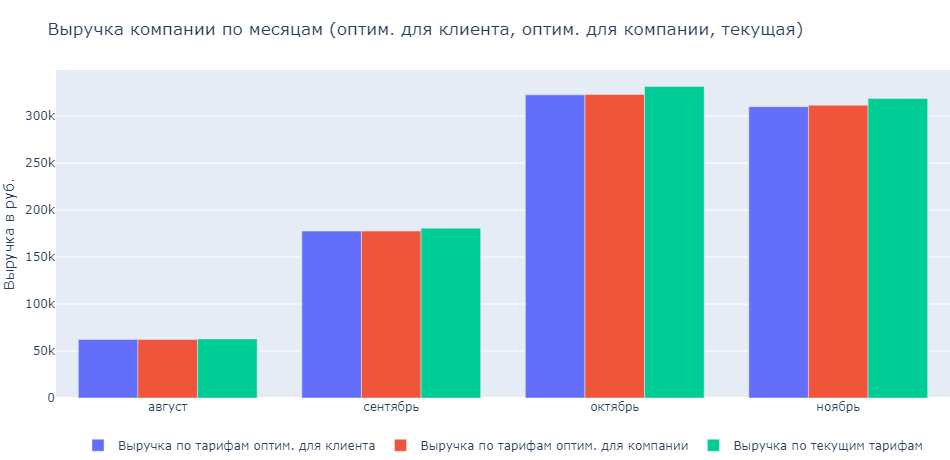

In [137]:
# Рассчет потерь при предложении двух разных вариантов тарифов (оптимальнее и самого оптимального)
pd.options.display.float_format ='{:,.2f}'.format

overpay1_list = []
overpay2_list = []

for m in m_list:
    globals()['overpay1_'+m] = globals()['act_cost_y_'+m]['overpay'].sum()
    overpay1_list.append(globals()['overpay1_'+m])
    globals()['overpay2_'+m] = globals()['act_cost_z_'+m]['overpay'].sum()
    overpay2_list.append(globals()['overpay2_'+m])
        
overpay1_list = list(map(int, overpay1_list))
overpay2_list = list(map(int, overpay2_list))

total_and_overpay = pd.DataFrame(
    {'month':total_four_month.month.to_list(),
    'total_sum':total_four_month.total_sum.to_list(),
    'overpay1':overpay1_list,
    'overpay2':overpay2_list})

total_and_overpay['new_total_1'] =  (
    total_and_overpay['total_sum'] - total_and_overpay['overpay1']
)
total_and_overpay['new_total_2'] =  (
    total_and_overpay['total_sum'] - total_and_overpay['overpay2']
)

total_sum = total_and_overpay['total_sum'].sum()
revenu_reduction1 = total_and_overpay['overpay1'].sum()
revenu_reduction2 = total_and_overpay['overpay2'].sum()

# Процент уменьшения выручки
total_and_overpay['reduction1'] = total_and_overpay['overpay1'] / total_and_overpay['total_sum']*100
total_and_overpay['reduction2'] = total_and_overpay['overpay2'] / total_and_overpay['total_sum']*100

print('Выручка за 4 месяца:', round(total_sum, 1), 'руб.')
print('Снижение выручки за 4 месяца при переходе на самые оптимальные тарифы составило бы:',
      round(revenu_reduction1, 1), 'руб.')
print('Снижение выручки за 4 месяца при переходе на НЕ самые оптимальные тарифы составило бы:',
      round(revenu_reduction2, 1), 'руб.')
display(total_and_overpay)

#Визуализируем выручку
fig = go.Figure()


fig.add_trace(
        go.Bar(
            x = total_and_overpay['month'],
            y = total_and_overpay['new_total_1'],
            name = 'Выручка по тарифам оптим. для клиента')
            )
fig.add_trace(
        go.Bar(
            x = total_and_overpay['month'],
            y = total_and_overpay['new_total_2'],
            name = 'Выручка по тарифам оптим. для компании')
            )
fig.add_trace(
        go.Bar(
            x = total_and_overpay['month'],
            y = total_and_overpay['total_sum'],
            name = 'Выручка по текущим тарифам')
            )


fig.update_layout(
    autosize=False,
    width=950,
    height=460,
    title="Выручка компании по месяцам (оптим. для клиента, оптим. для компании, текущая)",
    yaxis_title='Выручка в руб.',
    legend_orientation="h",
    legend=dict(x=.5, xanchor="center"),
    margin=dict(l=0, r=0, t=70, b=0),
    yaxis={'categoryorder':'total ascending'}
)
                         
fig.show()

Значения в `overpay1` - сокращение выручки в рублях, при переходе клиентов на самые оптимальные для них тарифы.  В `overpay2` - сокращение выручки при переходе клиентов на менее оптимальные для них тарифы, но все равно лучше чем текущие.

Смена на самые оптимальные и менее оптимальные (для клиентов) тарифы может давать в перспективе 4 месяцев почти 2 тыс. руб. разницы. Заметим, что выбор тарифа оптимального и для компании и для клиента экономит компании всего от 0.2% до 0.5% выручки в октябре и ноябре соответственно. Однако учитывая тот факт, что порог активности может быть изменен, можно ожидать увеличения числа клиентов, для которых оба тарифа, отличных от текущих, были бы оптимальными.

В дальнейшем, в качестве индивидуальных предложений, можно снова предложить переход на еще более оптимальный тариф, тем самым снова удерживая клиентов.

#### Формулировка гипотез

На этапе оценки эффективности тарифов заметили, что в оптимизации, в большинстве своем нуждаются клиенты с тарифами В и C. Проверим, по какому тарифу больше переплачивают клиенты в ноябре.

**Гипотеза** 1<br>
Н0 - В ноябре переплаты клиентов тарифа В не отличаются от переплат клиентов тарифа С. <br>
Н1 - В ноябре переплаты клиентов тарифа В меньше переплат клиентов тарифа С.

Подготовим данные. Будем брать максимальные переплаты (т.е. сравнение с самым оптимальным тарифом)

In [138]:
# Функция подсчета максимальных переплат
def over(row):
    abc = row['diff_abc']
    acb = row['diff_acb']
    
    if abc>acb:
        return abc
    return acb

In [139]:
for m in m_list:
    globals()['act_cost_x'+m] = globals()['act_cost_x'+m].copy()
    
    # Берем данные клиентов с неэффективными тарифами (ранее созданные act_cost_x"месяц")
    globals()['act_cost_x'+m]['bc'] = globals()['act_cost_x'+m].apply(over, axis=1) 
    
    # Таблица переплат клиентов с текущим тарифом B
    globals()['over_b_'+m] = (
        globals()['act_cost_x'+m]
        .query('tariff_plan == "B"')[['user_id', 'total_call_duration', 'tariff_plan', 'bc']]
    )
    # Таблица переплат клиентов с текущим тарифом С
    globals()['over_c_'+m] = (
        globals()['act_cost_x'+m]
        .query('tariff_plan == "C"')[['user_id', 'total_call_duration', 'tariff_plan', 'bc']]
    )

# Объединяем 4 таблицы тарифов В и 4 таблицы тарифов С
df_b = pd.concat([over_b_aug, over_b_sep, over_b_oct, over_b_nov], axis=0).reset_index(drop=True)
df_c = pd.concat([over_c_aug, over_c_sep, over_c_oct, over_c_nov], axis=0).reset_index(drop=True)

# Создаем списки переплат df_b и df_c тарифов В и С соотвественно
df_c = df_c['bc'].to_list()
df_b = df_b['bc'].to_list()

Готво. Списки созданы. Осталось проверить гипотезы. Для выбора подходящего стат критерия проверим распределения переплат на нормальность. Используем критерий Шапиро-Уилка для проверки распределения на нормальность.

In [140]:
stat, p = scipy.stats.shapiro(df_b) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.5f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности распределения переплат по тарифу В')
else:
    print('Отклонить гипотезу о нормальности распределения переплат по тарифу В')
    
stat, p = scipy.stats.shapiro(df_c)
print('Statistics=%.3f, p-value=%.5f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности распределения переплат по тарифу С')
else:
    print('Отклонить гипотезу о нормальности распределения переплат по тарифу С')

Statistics=0.794, p-value=0.00811
Отклонить гипотезу о нормальности распределения переплат по тарифу В
Statistics=0.995, p-value=0.98243
Принять гипотезу о нормальности распределения переплат по тарифу С


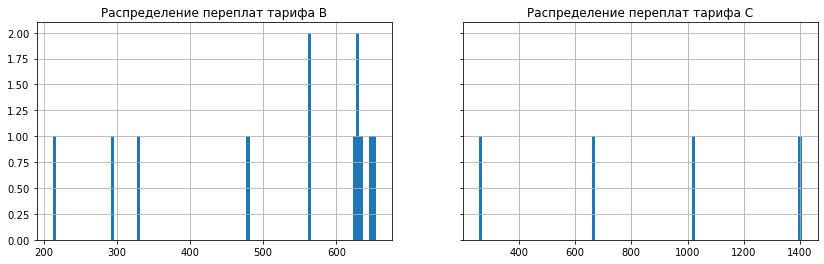

In [141]:


plt.rcParams ['figure.figsize'] = [14,4]

fig, axs = plt.subplots(1, 2)

axs[0] = plt.subplot(121)
axs[0].hist(df_b, bins=100)
axs[0].set_title('Распределение переплат тарифа В')
axs[0].grid()


axs[1] = plt.subplot(122, sharey=axs[0])
axs[1].hist(df_c, bins=100)
axs[1].set_title('Распределение переплат тарифа C')
axs[1].grid()
plt.setp(axs[1].get_yticklabels(), visible=False)

plt.show()

И критерий Шапиро_Уилка и визуализация распределений на гистограмме подтвержают ненормальность распределения переплат по тарифу В и равномерность распределения переплат по тарифу С. Значит для проверки гипотез будем использовать непараметрический стат U-критерий Манна—Уитни.

In [142]:
alpha = 0.05

# Используем U-критерий Мана-Уитни
results = stats.mannwhitneyu(df_b, df_c, alternative='less')

print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-value: 0.06648351648351648
Не можем отвергнуть нулевую гипотезу


Уровень значимости превышает установленный, а значит мы не можем отвергнуть нулевую гипотезу, и стат значимых различий между переплатами нет.

In [143]:
m_b = mean(df_b)
m_c = mean(df_c)

print('Средняя переплата по В:', round(m_b), 'руб.')
print('Средняя переплата по С:', round(m_c), 'руб.')

Средняя переплата по В: 521 руб.
Средняя переплата по С: 837 руб.


**Гипотеза номер 2**<br>
Цель перевода активных клиентов на более оптимальные тарифы - их сохранение, продолжение сотрудничества с ними. Но там где мы помогаем экономить клиенту, предлагая оптимальный тариф и тем самым сокращая его расходы, мы сокращаем и выручку компании. В ходе исследования мы уже выдвигали предложения об одном из способов минимизации потерь выручки компании после оптимизации тарифов - предлагать более эффективный тариф, но не самый оптимальный. 

А есть ли метрики, которые при смене тарифа клиента на более оптимальный могут показать рост и далее нивелировать уменьшение выручки, а в долгосрочной перспективе даже повысить ее. На ум приходит RR (retention rate - удержание).

Что если у активных клиентов с оптимальным тарифом RR выше чем у тех, кто пользуется неэффективным тарифом? Возможно оптимальность тарифа и RR связаны. Для ответа на этот вопрос рассмотрим  RR активных клиентов в ноябре. Рассмотрим две группы. Первая - клиенты, которые в п.4.1 были отнесены к группе клиентов с оптимальными тарифами и вторая - активных клиенты не попавших в эту группу.

In [144]:
# Список активных клиентов с оптимальными тарифами
op_users = [168187, 167497, 168062, 168361]

# Посмотрим на общие показатели расходов клиентов из этого списка в ноябре
df_total_op = df_total_nov[df_total_nov['user_id'].isin(op_users)]
df_total_op.sort_values(by='cost', ascending=False).head(20)

,user_id,total_call_duration,operator_id,int_out_duration,tariff_plan,tariff_fee,cost,calls_fee,oper_fee
86,168361,"72,094.00",25,1,A,5000,"36,337.60","28,837.60",2500
70,168062,"16,462.00",27,524,A,5000,"14,284.80","6,584.80",2700
77,168187,"9,735.00",46,86,A,5000,"13,494.00","3,894.00",4600
48,167497,"1,853.00",17,1393,A,5000,"7,441.20",741.20,1700


Обратим внимание, что среди этих активных клиентов с оптимальными тарифами есть два клиента из топ-3 по расходам в ноябре - 168361 и 168062!

In [145]:
# Выбираем дни первой активности клиентов из списка в ноябре
start_op = df_nov[df_nov['user_id'].isin(op_users)].groupby('user_id')['date'].min().reset_index()
start_op

,user_id,date
0,167497,2019-11-01
1,168062,2019-11-01
2,168187,2019-11-01
3,168361,2019-11-01


Все клиенты стартовали 1.11.19. Среди активных с неэффективными тарифами отберем также стартовавших в этот день.

In [146]:
# Выбираем дни первой активности в ноябре клиентов с неэффективными тарифами
df_nov_act = df_nov[df_nov['user_id'].isin(activ_list_nov)]
start_notop = df_nov_act.query('user_id not in [168187, 167497, 168062, 168361]').groupby('user_id')['date'].min().reset_index()

start_notop = start_notop[start_notop['date'] == datetime.date(2019,11,1)]

start_notop.head(4)

,user_id,date
0,166405,2019-11-01
1,166485,2019-11-01
2,166511,2019-11-01
3,166658,2019-11-01


In [147]:
#Переименуем столбцы
start_op = start_op.rename(columns={'date':'start_day'})
start_notop = start_notop.rename(columns={'date':'start_day'})

# Переименовываем столбец дата в день
sess_op = df_nov.rename(columns={'date':'day'})
sess_op['day'] = pd.to_datetime(sess_op['day'] ).dt.date

sess_notop = df_nov.rename(columns={'date':'day'})
sess_notop['day'] = pd.to_datetime(sess_notop['day'] ).dt.date

# Отбираем нужные столбцы
sess_op = sess_op[['user_id', 'day', 'total_call_duration']]
sess_notop = sess_notop[['user_id', 'day', 'total_call_duration']]

# Присоединяем к таблице сессий столбец стартов активности
res_op = sess_op.merge(start_op, on='user_id', how='left')
res_notop = sess_notop.merge(start_notop, on='user_id', how='left')

res_op = res_op.dropna()
res_notop = res_notop.dropna()

# Добавлям столбец лайфтаймов
res_op['lifetime'] = (
    res_op['day'] - res_op['start_day']
).dt.days

res_notop['lifetime'] = (
    res_notop['day'] - res_notop['start_day']
).dt.days

# Строим сводные
res_piv_op = res_op.pivot_table(
    index='start_day', columns='lifetime', values='user_id', aggfunc='nunique'
)

res_piv_notop = res_notop.pivot_table(
    index='start_day', columns='lifetime', values='user_id', aggfunc='nunique'
)
# Формат вывода чисел
pd.options.display.float_format ='{:,.3f}'.format

# Считаем размер когорты
cohort_sizes_op = (
    res_op.groupby('day')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
# Объединяем размер когорты и сводную
res_gr_op = cohort_sizes_op.merge(
    res_piv_op, left_on=cohort_sizes_op.index, right_on='start_day', how='inner'
).fillna(0)

# Считаем размер когорты
cohort_sizes_not = (
    res_notop.groupby('day')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)
# Объединяем размер когорты и сводную
res_gr_not = cohort_sizes_not.merge(
    res_piv_notop, left_on=cohort_sizes_not.index, right_on='start_day', how='inner'
).fillna(0)

# Исключаем из результата все лайфтаймы, превышающие горизонт анализа
#res_gr_op= res_gr_op[['cohort_size'] + list(range(21))]
#res_gr_not= res_gr_not[['cohort_size'] + list(range(21))]

res_gr_op = res_gr_op.iloc[:,1:]
res_gr_not = res_gr_not.iloc[:,1:]

# Делим каждый элемент строки на размер когорты
res_gr_op = res_gr_op.div(res_gr_op[0], axis=0)
res_gr_not = res_gr_not.div(res_gr_not[0], axis=0)

Готово. Построим визуализацию.

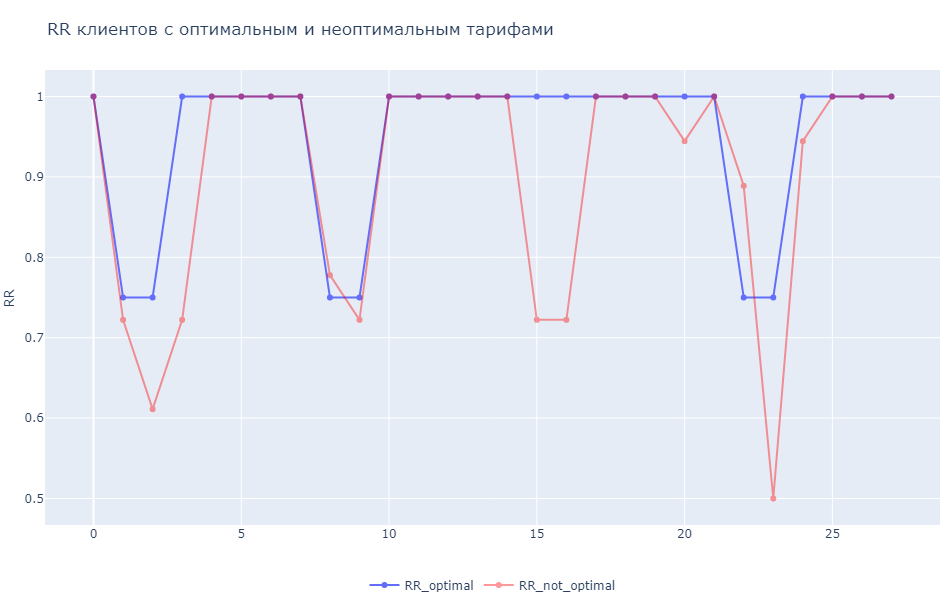

In [148]:
# Подготовим данные
res_gr_op = res_gr_op.T.reset_index()
res_gr_not = res_gr_not.T.reset_index()

res_gr_o = res_gr_op[1:].reset_index(drop=True).rename(columns={'index':'life_time', 0:'RR'})
res_gr_n = res_gr_not[1:].reset_index(drop=True).rename(columns={'index':'life_time', 0:'RR'})

fig = make_subplots(rows=1, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)


fig.add_trace(go.Scatter(
        x=res_gr_o['life_time'],
        y=res_gr_o['RR'],
        mode='lines+markers',
        name='RR_optimal'))

fig.add_trace(go.Scatter(
        opacity=0.4,
        name='RR_not_optimal',
         x=res_gr_n['life_time'],
        y=res_gr_n['RR'],
        mode = "lines+markers",
        marker = dict(color = 'red')
    ),row=1, col=1)


fig.update_layout(
                  autosize=False,
                  width=940,
                  height=600,
                  title="RR клиентов с оптимальным и неоптимальным тарифами",
                  yaxis_title='RR',
                  legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=70, b=0))

fig.show()

Видим, что по отдельным лайфтаймам клиенты с оптимальными тарифами имеют RR выше клиентов с неоптимальными. Однако проверим есть ли между ними различия при задом уровне значимости.

Сформулируем нулевую и альтернативную гипотезы:<br>
Н0 - RR клиентов с оптимальными и неоптимальными тарифами в ноябре не отличаются.<br>
H1 - RR клиентов с оптимальными тарифами в ноябре больше чем у клиентов с неоптимальными.

In [149]:
alpha = 0.05

# Используем U-критерий Мана-Уитни
results = stats.mannwhitneyu(res_gr_o['RR'].to_list(), res_gr_n['RR'].to_list(), alternative='greater')

print('p-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-value: 0.056722134370875615
Не можем отвергнуть нулевую гипотезу


Статистически значимых различий обнаружить не удалось, отвергнуть нулевую гипотезу не можем, значит RR клиентов с оптимальными тарифами стат значимо не отличается от RR клиентов с неоптимальными тарифами.

**ВЫВОДЫ**<br>
* Были сформулированы и проверены две гипотезы относительно использования тарифов клиентами
* Проверка первой гипотезы показала стат значимые различия между расходами клиентов по текущим неоптимальным тарифам В и С, и что стат значимо расходы по тарифу В меньше С
* При поверке гипотезы о различии RR клиентов с оптимальными и неоптимальными тарифами в ноябре стат значимых различий определено не было, но на графике были замечены отдельные лайфтаймы клиентов с неоптимальными тарифами имеющие значения меньше соответствующих у клиентов с оптимальными тарифами.

## Выводы и рекомендации

В нашем распоряжении были данные телеком провайдера "Нупозвони!", в которых содержалась информация о клиентах, операторах и звонках, которые совершают операторы по заказу клиентов. 

По заказу коммерческого отдела телеком провайдера "Нупозвони!" мы провели исследование данных и готовы предложить пути решения вопроса об эффективности тарифов, используемых клиентами, дабы предлагая им более выгодные тарифы повысить ratantion rate, вместе с тем LTV, а в конечном счете чистую прибыль. 

В ходе предобработки данных были обнаружены пропуски и аномалии, информацию о которых было решено поместить в баг-репорт. Они касаются пропусков в `operaor_id` и `internal` и аномальных значений в количестве звонков, продолжительности звонков.

В ходе исследовательского анализа данных было установлено:
* Количество уникальных клиентов таблиц clients и data 732 и 307. Количество уникальных операторов - 1057. Наибольшее количество операторов приходится на клиента 168187 - 50. Клиентов без операторов - 17, или 6%.
* Дата первой регистрации клиентов - 01.08.2019, последней - 31.10.2019. Дата первой активности клиентов - 02.08.2019, последней - 28.11.2019, временной интервал данных в днях: 118. 
* Самый "активный" (наибольшее число клиентов) месяц - октябрь (272 клиента). Далее по убыванию: ноябрь (261 клиент), сентябрь (172 клиента), и почти с двукратным отставанием август (84 клиента).
* Наибольшая доля клиентов только с исходящими звонками в августе - около 42% от числа всех клиентов, пользующихся услугами компании в этом месяце. Наименьшая - около 31% в ноябре и сентябре.
* Количество вызовов в месяц растет от сентября к ноябрю. Внутренних вызовов в каждом месяце на порядки меньше внешних. Рост количества вызовов с сентября по октябрь более чем двукратный. Абсолютный лидер по количеству совершенных вызовов - ноябрь.
* Входящих вызовов намного (до 4 раз) меньше исходящих. Наибольшее число вызовов (вне зависимости от месяца) - внешние исходящие вызовы. Наименьшее число - внутренние входящие. Самый большой "скачек" в общей продолжительности внутренних и внешних звонков произошел с августа на сентябрь (в 4 и в 5 раз соответственно).
* Клиентов можно разделить на две группы по типу звонков. В первой группе клиенты только с входящими вызовами, во второй с входящими и исходящими. Первая группа проигрывает второй как по количеству операторов, так и по общей продолжительности звонков и их количеству. 
* По таким показателям как количество звонков в день и продолжительность звонков в день для любого месяца среднее значение больше медианы, а значит значения распределены значений ассиметрично, и мы имеем большое количество клиентов с низкими показателями и несколько клиентов с очень высокими показателями. 
* В целом можно сказать, что до половины всех клиентов мало активны (количество рабочих дней за 4 месяца не превосходит и 30 дней!). 
* Всего не более чем 11% клиентов имеют более 2800 звонков в месяц. 
* Не более 5% в октябре и ноябре и не более 1% имеют 200 и больше звонков в день.


В ходе исследования были решены **следующие задачи, поставленные заказчиком:**

1. Были определены списки активных клиентов по месяцам (см. приложение 1). По выбранным пороговым значениям активности таких клиентов оказалось 32, или около 10% от числа всех клиентов компании. Их распределение по месяцам:
* Август - 2
* Сентябрь - 10
* Октябрь - 17
* Ноябрь - 18

Среди них один клиент был активен все четыре месяца, пятеро - три месяца, восемь клиентов - два и остальные только один месяц. 


2. Из числа активных клиентов были определены те, кто использует оптимальные тарифы и те, чьи тарифы не являются эффективными (см. приложение 1). 14 клиентов - 166658, 167650, 166405, 166983, 167112, 168361, 167626, 167150, 166511, 167888, 168336, 166997, 166520, 168412 используют оптимальные тарифы (т.е. 44% активных клиентов используют оптимальные тарифы). Остальные клиенты могли бы сократить свои расходы, если бы перешли на более оптимальный тариф. 

3. Для клиентов с неэффективными тарифами были предложены более оптимальные тарифы. При этом из двух тарифов выбирался тот, при котором потери выручки компании были бы минимальными (см. приложение 1.) Таких клиентов оказалось всего 3, что конечно же связано с порогом активности, который может варьироваться по предложению заказчика. Активных клиентов с неэффективными тарифами оказалось 14 или около 5% от числа всех. Т.е. 44% от числа активных клиентов переплачивают по своим текущим тарифам, и их переплаты составляют от 4% до 46% (наибольшая из них 3444 руб. у клиента 167497 и наименьшая - 190 руб. у 168018 в ноябре). Условно можно разделить таких клиентов на тех кто переплачивает 10%, от 10% до 20%, от 20% до 30%, от 30% до 46% включительно (самая многочисленная группа). Также отметим, что наибольшие значения и доли переплат в основном приходятся на тариф С, меньшие на В. 


4. Выручка компании по месяцам составила: август - 62.9 тыс. руб., сентябрь - 180.8 тыс. руб., октябрь - 331.7 тыс. руб., ноябрь - 318.9 тыс. руб. Или в процентах за август, сентябрь, октябрь и ноябрь 7, 20, 37 и 36 соответственно. Выручка компании за все четыре месяца составила 894.2 тыс. руб. Выручка компании по месяцам, которую принесли неэффективные клиенты практически пропорциональна (кроме октября и ноября) общей выручке компании и варьируется от 6 до 18 процентов от общей выручки по месяцам. Она составила 3.6 тыс. руб в августе, 24.9 тыс. руб. в сентябре, 46 тыс. руб. в октябре, 56.4 тыс. руб. в ноябре. Выручка компании за весь исследуемый период, которую принесли клиенты с неэффективными тарифами составила 130.8 тыс. руб. или почти 15% от всей выручки за четыре месяца.


5. Снижение выручки за 4 месяца при переходе на самые оптимальные тарифы составило бы  21.4 тыс. руб., а при переходе на НЕ самые оптимальные тарифы составило бы 19.4 тыс. руб. Снижение выручки компании может быть нивелировано от части предложением из двух тарифов оптимального как для клиента, так и для компании, и со снижением порога активности клиентов, разница может становиться все более значимой. С другой стороны стоит обратить внимание на лимит исходящих внутри сети (установленные 2000 мин в месяц по данным исследования никто не преодолел). А также обратить внимание на работу отдельных операторов, по расходу времени работы на входящие и исходящие, а также на пропущенные звонки и их количество (отдельное исследование эффективности их работы).


6. На данных за ноябрь были проверены две гипотезы. В первой выяснили, что стат значимо переплаты клиентов по тарифу В от переплат клиентов по тарифу С не отличаются.  Во второй, что стат значимого различия между RR клиентов с оптимальными и неоптимальными тарифами нет, однако на графике отметили различия RR для отдельных лайфтаймов.

**Практическое применение**<br>
Используя результаты исследования коммерческим отделом могут быть приняты меры по удержанию клиентов, за счет адресного, индивидуально подобранного экономически выгодного тарифа. При этом рекомендации, полученные из исследования, в долгосрочной перспективе могу поднять уровень LTV и в целом лояльность клиентов к компании.

**РЕКОМЕНДАЦИИ**<br>
* Проверить организацию сбора, хранения и выгрузки информации по клиентам (см. баг-репорт)
* Проверить работу отдельных операторов, на предмет переработки (зачастую с нулевой выручкой) и причин с этим связанных.
* Обратить внимание на то, что до половины клиентов компании имеют низкие показатели активности (число рабочих дней, число операторов и звонков ,продолжительность звонков в месяц).
* Никто из клиентов ни в один из четырех месяцев не преодолел лимит в 2000 мин на исходящие внутри сети, возможно стоит снизить этот порог и тем самым нивелировать часть потерь по выручке.
* Из двух оптимальных тарифов для клиентов с неэффективным текущим тарифов, предлагать тариф, который с одной стороны сокращает расходы клиента, с другой - окажет меньше негативного эффекта на выручку компании ("соломонов" тариф). Список клиентов и тарифов в приложении 1.

Можно считать, что цель исследования была достигнута.

## Результаты исследования

* Основные выводы, к которым мы пришли в ходе исследования отражены в п.6.
* Результаты исследования оптимальности тарифов сформированы в файл customers_inefficient_tariffs.xlsx, содержащий клиентов с неэффективными тарифами (user_id, , длительность звонков в месяц, количество операторов, текущий тариф, текущие расходы, рекомендуемый тариф, переплата в рублях, переплата в процентах, оптимизированные расходы, месяц).

[ПРИЛОЖЕНИЕ 1 customers_inefficient_tariffs_2.xlsx](https://disk.yandex.ru/i/gT9Jk486OViwHA)

[Баг_репорт](https://disk.yandex.ru/d/G481Z9KH8WbMJg)

[Презентация](https://disk.yandex.ru/i/fnsE-aawWY8tdA)